In [222]:
from qiskit import *
from qutip import *
import qutip as qt
from qiskit import Aer, IBMQ
from typing import Dict
#from qiskit_ibm_provider import IBMProvider
import matplotlib.pyplot as plt
from qiskit.providers.fake_provider import FakeMumbai, FakeLagos, FakePerth
from qiskit import execute, Aer, IBMQ
from qiskit.providers.aer.noise import NoiseModel
import qiskit.providers.aer.noise as noise
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)
from qiskit.visualization import plot_histogram, plot_bloch_multivector, timeline_drawer

In [223]:
from qiskit import quantum_info as qi

In [224]:
from qiskit import IBMQ

#IBMQ.save_account('e127bb01d5ce01ff7045134571dc415cf737cda222b081df84d6f046c18c8f1839ed5fb327b16e49dc744d12f449f6ad2069bcb342d2ed55bb0da924e874c4e4')
#IBMQ.load_account() # Load account from disk
#IBMQ.providers()    # List all available providers

In [225]:
#provider = IBMQ.get_provider(hub='ibm-q')
#provider.backends()

In [226]:
#backend = provider.get_backend('ibm_perth')

In [227]:
import qiskit
import numpy as np

In [228]:
from qiskit.circuit.library import XGate, HGate, RXGate, PhaseGate, TGate, TdgGate
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import ALAPScheduleAnalysis, PadDynamicalDecoupling
from qiskit.transpiler.passes import CXCancellation, InverseCancellation
from matplotlib import rcParams

In [229]:
def figure_styling():
    # using aliases for color, linestyle and linewidth; gray, solid, thick
    #rcParams.update({'figure.autolayout': True})
    plt.rc("grid", c=".25", ls=":", lw=0.5)
    plt.rc("lines", lw=1.2, color="g")
    # plt.rcParams['axes.labelsize'] = 16
    # plt.rcParams['axes.titlesize'] = 16

    # params = {'axes.labelsize': 16,
    #      'axes.titlesize': 16}
    # plt.rcParams.update(params)
    plt.rc("axes", linewidth=1.3, labelsize=14,titlesize=25)
    # the axes attributes need to be set before the call to subplot
    # plt.rc('font', weight='bold')
    plt.rc("xtick.major", size=11, pad=7)
    plt.rc("ytick.major", size=11, pad=7)
    plt.rc("xtick.minor", size=6, pad=7)
    plt.rc("ytick.minor", size=6, pad=7)
    plt.rc("xtick", labelsize=12)
    plt.rc("ytick", labelsize=12)

    # plt.rcParams["font.family"] = "Times New Roman"
    # plt.rcParams["font.family"] = "serif"
    # plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
    rc = {"font.family": "serif", "mathtext.fontset": "stix"}
    plt.rcParams.update(rc)
    plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]


# plt.text(2.5, 1., "comic sans", family="Comic Sans MS")
def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

In [230]:
#import sys  
#sys.path.insert(0, '/home/itp/sgupta/Desktop/Quantum simulation/QLLM/quantum-simulation-main/src/quantum_simulation')
#import ED as ED
#import quantum_error_mitigation as qem

import sys  
sys.path.append("/Users/sabhy/Downloads/quantum_simulation/Quantum simulation/QLLM/quantum-simulation-main/src/quantum_simulation/")
import ED as ED

### Circuits (non-calibrated and calibrated)

#### 2 plaquette

In [10]:
def trotter_circuit_two_plaquette(steps,dt):
    
    circuit = QuantumCircuit(1)

    for i in range(steps):
        circuit.rx(2*-1.414*dt,0)        
        circuit.rz(2*0.5*dt,0)             
    
    return circuit
circuit=trotter_circuit_two_plaquette(1,0.1)

In [11]:
print(dict(circuit.count_ops()))
print("Circuit depth: ",circuit.depth())

{'rx': 1, 'rz': 1}
Circuit depth:  2


In [12]:

S2 = 1.5*qt.identity(2) + 0.5*qt.sigmaz()


In [13]:
#flip-flip correlation
h2_11 = 0.5*qt.identity(2) + 0.5*qt.sigmaz()
h2_12 = 0.75*qt.identity(2) + 0.25*qt.sigmaz()

#### 4 plaquette

In [14]:

def trotter_circuit_four_plaquette(steps, dt):
    
    circuit = QuantumCircuit(2)

    for i in range(steps):
        circuit.rx(-2*dt,1)
        circuit.rz(2*dt,1)
        circuit.rz(2*dt,0)
        circuit.rzx(-2*dt,0,1)
        circuit.rxx(-2*0.707*dt,0,1)
        circuit.ryy(-2*0.707*dt,0,1)
        
    return circuit


In [15]:
S4 =  2*qt.tensor([qt.identity(2), qt.identity(2)]) +qt.tensor([qt.identity(2), qt.sigmaz()]) + qt.tensor([qt.sigmaz(), qt.identity(2)]) 
#S4

In [16]:
circuit = trotter_circuit_four_plaquette(1, 0.1)
tcirc=circuit.decompose().decompose()
print(dict(tcirc.count_ops()))
print("Circuit depth: ",tcirc.depth())
#tcirc.draw()

{'u2': 6, 'cx': 6, 'r': 4, 'u3': 3, 'u1': 3}
Circuit depth:  17


In [26]:
def trotter_circuit_four_plaquette_calibrated(steps, dt):
    
    circuit = QuantumCircuit(2)

    for i in range(steps):
        circuit.rx(-2*dt,1)
        circuit.rz(2*dt,1)
        circuit.rz(2*dt,0)
        
        #zx
        #circuit.rz(pi / 2, 0)
        circuit.rz(pi / 2, 1)
        #circuit.sx(0)
        circuit.sx(1)
       # circuit.rz(pi / 2, 0)
        circuit.rz(pi / 2, 1)
        circuit.rzz(-2*dt,0,1)
        
        circuit.add_calibration('rzz', [0,1], Rzz_gate_schedule(q1,q2,-2*dt), [-2*dt])  ##Rzz_gate_schedule import from RZZ custom schedule
        #circuit.rz(pi / 2, 0)
        circuit.rz(pi / 2, 1)
        #circuit.sx(0)
        circuit.sx(1)
        #circuit.rz(pi / 2, 0)
        circuit.rz(pi / 2, 1)
        
        
        
        #xx
        circuit.rz(pi / 2, 0)
        circuit.rz(pi / 2, 1)
        circuit.sx(0)
        circuit.sx(1)
        circuit.rz(pi / 2, 0)
        circuit.rz(pi / 2, 1)
        circuit.rzz(-2*0.707*dt,0,1)
        circuit.add_calibration('rzz', [0,1], Rzz_gate_schedule(0,1,-2*0.707*dt), [-2*0.707*dt])   ##Rzz_gate_schedule import from RZZ custom schedule
        circuit.rz(pi / 2, 0)
        circuit.rz(pi / 2, 1)
        circuit.sx(0)
        circuit.sx(1)
        circuit.rz(pi / 2, 0)
        circuit.rz(pi / 2, 1)        
        
        #yy
        #circuit.rz(pi / 2, 0)
        #circuit.rz(pi / 2, 1)
        circuit.sx(0)
        circuit.sx(1)
        
        circuit.rzz(-2*0.707*dt,0,1)
        circuit.add_calibration('rzz', [0,1], Rzz_gate_schedule(0,1,-2*0.707*dt), [-2*0.707*dt])     #### ##Rzz_gate_schedule import from RZZ custom schedule   
        circuit.rz(-pi, 0)
        circuit.rz(-pi, 1)
        circuit.sx(0)
        circuit.sx(1)
        circuit.rz(-pi , 0)
        circuit.rz(-pi , 1)
        
    return circuit

In [27]:
circuit = trotter_circuit_four_plaquette_calibrated(1, 0.1)
print(dict(circuit.count_ops()))
print("Circuit depth: ",circuit.depth())

{'rz': 18, 'sx': 10, 'rzz': 3, 'rx': 1}
Circuit depth:  21


In [28]:
S4 =  2*qt.tensor([qt.identity(2), qt.identity(2)]) +qt.tensor([qt.identity(2), qt.sigmaz()]) + qt.tensor([qt.sigmaz(), qt.identity(2)]) 
S4

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[4. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 0.]]

In [29]:
h4_11=0.5*qt.tensor([qt.identity(2), qt.identity(2)])+0.25*qt.tensor([qt.identity(2), qt.sigmaz()])+0.25*qt.tensor([qt.sigmaz(),qt.identity(2)])

In [30]:
h4_11

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1.  0.  0.  0. ]
 [0.  0.5 0.  0. ]
 [0.  0.  0.5 0. ]
 [0.  0.  0.  0. ]]

In [31]:
h4_12=0.25*qt.tensor([qt.identity(2), qt.identity(2)])+0.25*qt.tensor([qt.identity(2), qt.sigmaz()])+0.25*qt.tensor([qt.sigmaz(),qt.identity(2)])+0.25*qt.tensor([qt.sigmaz(), qt.sigmaz()]) 
h4_12

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

In [32]:
h412n=0.125*qt.tensor([qt.identity(2), qt.identity(2)])-0.125*qt.tensor([qt.sigmaz(),qt.sigmaz()])

In [33]:
def trotter_six_plaquette(steps, dt):
    
    circ = QuantumCircuit(3)

    for i in range(steps):
        circ.rx(-1.22474487*dt, 0)
        circ.rz(1.5*dt, 0)
        circ.rx(-0.70710678*dt, 1)
        circ.rxx(-1.0*dt, 0,  1)
        circ.rzx(0.70710678*dt, 0,  1)
        circ.ryy(-1.0*dt, 0,  1)
        circ.rz(2.0*dt, 1)
        circ.rzx(-1.22474487*dt, 1,  0)
        circ.rzz(1.0*dt, 0,  1)
        circ.rxx(-0.866025405*dt, 1,  2)
        circ.h( 1)
        circ.h( 2)
        circ.cx( 2,  1)
        circ.cx( 1,  0)
        circ.rz(-0.866025405*dt, 0)
        circ.cx( 1,  0)
        circ.cx( 2,  1)
        circ.h( 1)
        circ.h( 2)
        circ.ryy(-0.866025405*dt, 1,  2)
        circ.sdg( 1)
        circ.h( 1)
        circ.sdg( 2)
        circ.h( 2)
        circ.cx( 2,  1)
        circ.cx( 1,  0)
        circ.rz(-0.866025405*dt, 0)
        circ.cx( 1,  0)
        circ.cx( 2,  1)
        circ.h( 1)
        circ.s( 1)
        circ.h( 2)
        circ.s( 2)
        circ.rz(3.0*dt, 2)
        circ.rzx(-1.22474487*dt, 2,  0)
        circ.h( 0)
        circ.rzx(-0.70710678*dt, 2,  1)
        circ.h( 1)
        circ.cx( 2,  1)
        circ.cx( 1,  0)
        circ.rz(-1.0*dt, 0)
        circ.cx( 1,  0)
        circ.h( 0)
        circ.cx( 2,  1)
        circ.h( 1)
        circ.h( 1)
        circ.cx( 2,  1)
        circ.cx( 1,  0)
        circ.rz(0.70710678*dt, 0)
        circ.cx( 1,  0)
        circ.sdg( 0)
        circ.h( 0)
        circ.cx( 2,  1)
        circ.h( 1)
        circ.sdg( 1)
        circ.h( 1)
        circ.cx( 2,  1)
        circ.cx( 1,  0)
        circ.rz(-1.0*dt, 0)
        circ.cx( 1,  0)
        circ.h( 0)
        circ.s( 0)
        circ.h( 0)
        circ.cx( 2,  1)
        circ.h( 1)
        circ.s( 1)
        circ.rzz(0.5*dt, 1,  2)
        circ.cx( 2,  1)
        circ.cx( 1,  0)
        circ.rz(-1.22474487*dt, 0)
        circ.cx( 1,  0)
        circ.h( 0)
        circ.cx( 2,  1)
        circ.cx( 2,  1)
        circ.cx( 1,  0)
        circ.rz(-0.5*dt, 0)
        circ.cx( 1,  0)
        circ.cx( 2,  1)
        
    #circ.measure_all()
        
    return circ

# h4 =trotter_six_plaquette(1,0.1)
# h4.draw()

In [34]:
circuit6 = trotter_six_plaquette(1, 0.1)
tcirc6=circuit6.decompose().decompose()
print(dict(tcirc6.count_ops()))
#print(dict(circuit.count_ops()))
print("Circuit depth: ",tcirc6.depth())

{'cx': 48, 'u3': 40, 'u2': 16, 'u1': 10, 'r': 8}
Circuit depth:  95


In [35]:
def trotter_six_plaquette_calibrated(steps, dt):
    
    circ = QuantumCircuit(3)

    for i in range(steps):
        circ.rx(-1.22474487*dt, 0)
        circ.rz(1.5*dt, 0)
        circ.rx(-0.70710678*dt, 1)
        circ.h(1)
        circ.h(0)
        circ.rzz(-1.0*dt, 0, 1)
        circ.add_calibration('rzz', [0,1], Rzz_gate_schedule(0,1,-1.0*dt), [-1.0*dt])## add calibration
        circ.h(0)
        circ.h(1)
        circ.h(1)
        circ.rzz(0.70710678*dt, 0, 1)   ## add calibration
        circ.h(1)
        circ.rx(np.pi/2, 0)
        circ.rx(np.pi/2, 1)
        circ.rzz(-1.0*dt, 0, 1)   ### add calibration
        circ.add_calibration('rzz', [0,1], Rzz_gate_schedule(0,1,-1.0*dt), [-1.0*dt])## add calibration
        circ.rx(-1*np.pi/2, 0)
        circ.rx(-1*np.pi/2, 1)
        circ.rz(2.0*dt, 1)
        circ.h(0)
        circ.rzz(-1.22474487*dt, 1, 0) ## add calibration
        circ.add_calibration('rzz', [1,0], Rzz_gate_schedule(1,0,-1.22474487*dt), [-1.22474487*dt])## add calibration
        circ.h(0)
        circ.rzz(1.0*dt, 0, 1)   
        circ.add_calibration('rzz', [0,1], Rzz_gate_schedule(0,1,1.0*dt), [1.0*dt])## add calib
        circ.h(1)
        circ.h(2)
        circ.rzz(-0.866025405*dt, 1, 2)   
        circ.add_calibration('rzz', [1,2], Rzz_gate_schedule(1,2,-0.866025405*dt), [-0.866025405*dt])## add calibration
        circ.h(1)
        circ.h(2)
        circ.h(1)
        circ.h(2)
        circ.cx(2, 1)
        #circ.cx(1, 0)
        circ.rzz(-0.866025405*dt, 1, 0)   
        circ.add_calibration('rzz', [1,0], Rzz_gate_schedule(1,0,-0.866025405*dt), [-0.866025405*dt])# add calib
        #circ.cx(1, 0)
        circ.cx(2, 1)
        circ.h(1)
        circ.h(2)
        circ.rx(np.pi/2, 2)
        circ.rx(np.pi/2, 1)
        circ.rzz(-0.866025405*dt, 1, 2) 
        circ.add_calibration('rzz', [1,2], Rzz_gate_schedule(1,2,-0.866025405*dt), [-0.866025405*dt])## add calib
        circ.rx(-1*np.pi/2, 2)
        circ.rx(-1*np.pi/2, 1)
        circ.sdg(1)
        circ.h(1)
        circ.sdg(2)
        circ.h(2)
        circ.cx(2, 1)
        #circ.cx(1, 0)
        circ.rzz(-0.866025405*dt, 1, 0)   
        circ.add_calibration('rzz', [1,0], Rzz_gate_schedule(1,0,-0.866025405*dt), [-0.866025405*dt])### add calib
        #circ.cx(1, 0)
        circ.cx(2, 1)
        circ.h(1)
        circ.s(1)
        circ.h(2)
        circ.s(2)
        circ.rz(3.0*dt, 2)
        circ.h(0)
        circ.rzz(-1.22474487*dt, 2, 0)   
        circ.add_calibration('rzz', [2,0], Rzz_gate_schedule(2,0,-1.22474487*dt), [-1.22474487*dt])## add calib
        circ.h(0)
        circ.h(0)
        circ.h(1)
        circ.rzz(-0.70710678*dt, 2, 1)
        circ.add_calibration('rzz', [2,1], Rzz_gate_schedule(2,1,-0.70710678*dt), [-0.70710678*dt])#### add calibration
        circ.h(1)
        circ.h(1)
        circ.cx(2, 1)
        #circ.cx(1, 0)
        circ.rzz(-1.0*dt, 1, 0)  
        circ.add_calibration('rzz', [1,0], Rzz_gate_schedule(1,0,-1.0*dt), [-1.0*dt])## add calib
        #circ.cx(1, 0)
        circ.h(0)
        circ.cx(2, 1)
        circ.h(1)
        circ.h(1)
        circ.cx(2, 1)
        #circ.cx(1, 0)
        circ.rzz(0.70710678*dt, 1, 0)   
        circ.add_calibration('rzz', [1,0], Rzz_gate_schedule(1,0,0.70710678*dt), [0.70710678*dt])## add calib
        #circ.cx(1, 0)
        circ.sdg(0)
        circ.h(0)
        circ.cx(2, 1)
        circ.h(1)
        circ.sdg(1)
        circ.h(1)
        circ.cx(2, 1)        #circ.cx(1, 0)
        circ.rzz(-1.0*dt, 1, 0) 
        circ.add_calibration('rzz', [1,0], Rzz_gate_schedule(1,0,-1.0*dt), [-1.0*dt])## add calib
        #circ.cx(1, 0)
        circ.h(0)
        circ.s(0)
        circ.h(0)
        circ.cx(2, 1)
        circ.h(1)
        circ.s(1)
        circ.rzz(0.5*dt, 1, 2)   
        circ.add_calibration('rzz', [1,2], Rzz_gate_schedule(1,2,0.5*dt), [0.5*dt])### add calib
        circ.cx(2, 1)        #circ.cx(1, 0)
        circ.rzz(-1.22474487*dt, 1, 0)    
        circ.add_calibration('rzz', [1,0], Rzz_gate_schedule(1,0,-1.22474487*dt), [-1.22474487*dt])## add calib
        #circ.cx(1, 0)
        circ.h(0)
        circ.cx(2, 1)
        circ.cx(2, 1)
        #circ.cx(1, 0)
        circ.rzz(-0.5*dt, 1, 0) 
        circ.add_calibration('rzz', [1,0], Rzz_gate_schedule(1,0,-0.5*dt), [-0.5*dt])
        ### add calib
        #circ.cx(1, 0)
        circ.cx(2, 1)



        
    #circ.measure_all()
        
    return circ

# h4 =trotter_six_plaquette_calibrated(1,0.1)
# h4.draw('mpl')

In [32]:
circuit6c = trotter_six_plaquette_calibrated(1, 0.1)
#tcirc6c=circuit6c.decompose().decompose()
print(dict(circuit6c.count_ops()))
print("Circuit depth: ",circuit6c.depth())

{'h': 36, 'rzz': 17, 'cx': 14, 'rx': 10, 'sdg': 4, 's': 4, 'rz': 3}
Circuit depth:  61


In [33]:
#tcirc6.draw()

In [34]:
#h4 =trotter_six_plaquette_calibrated(1,0.1)
# h4.draw('mpl')

In [36]:

S6= 2.25*qt.tensor([qt.tensor([qt.identity(2), qt.identity(2)]),qt.identity(2)])+ 0.75*qt.tensor([qt.tensor([qt.identity(2), qt.identity(2)]),qt.sigmaz()])+1*qt.tensor([qt.tensor([qt.identity(2), qt.sigmaz()]),qt.identity(2)])+  0.5*qt.tensor([qt.tensor([qt.identity(2), qt.sigmaz()]),qt.sigmaz()])+1.5*qt.tensor([qt.tensor([qt.sigmaz(), qt.identity(2)]),qt.identity(2)])+0.25*qt.tensor([qt.tensor([qt.sigmaz(), qt.sigmaz()]),qt.identity(2)])-0.25*qt.tensor([qt.tensor([qt.sigmaz(), qt.sigmaz()]),qt.sigmaz()])
#S6

In [37]:
h6_11=0.125*qt.tensor([qt.identity(2), qt.identity(2), qt.identity(2)])+0.125*qt.tensor([qt.identity(2), qt.identity(2), qt.sigmaz()])+0.125*qt.tensor([qt.identity(2),qt.sigmaz(), qt.identity(2)])+0.125*qt.tensor([qt.identity(2),qt.sigmaz(), qt.sigmaz()])+0.125*qt.tensor([qt.sigmaz(), qt.identity(2), qt.identity(2)])+0.125*qt.tensor([qt.sigmaz(), qt.identity(2), qt.sigmaz()])+0.125*qt.tensor([qt.sigmaz(), qt.sigmaz(),qt.identity(2)])+0.125*qt.tensor([qt.sigmaz(), qt.sigmaz(),qt.sigmaz()])
#h6_11

In [38]:
h6_12=0.16662499999999994*qt.tensor([qt.identity(2), qt.identity(2), qt.identity(2)])+0.08337500000000003*qt.tensor([qt.identity(2), qt.identity(2), qt.sigmaz()])+0.166625*qt.tensor([qt.identity(2),qt.sigmaz(), qt.identity(2)])+0.0833750000*qt.tensor([qt.identity(2),qt.sigmaz(), qt.sigmaz()])+0.166625*qt.tensor([qt.sigmaz(), qt.identity(2), qt.identity(2)])+0.0833750000*qt.tensor([qt.sigmaz(), qt.identity(2), qt.sigmaz()])+0.166625*qt.tensor([qt.sigmaz(), qt.sigmaz(),qt.identity(2)])+0.0833750000*qt.tensor([qt.sigmaz(), qt.sigmaz(),qt.sigmaz()])
#h6_12

In [39]:
h6_13=0.27083337499999993*qt.tensor([qt.identity(2), qt.identity(2), qt.identity(2)])+0.145833375*qt.tensor([qt.identity(2), qt.identity(2), qt.sigmaz()])+0.145833375*qt.tensor([qt.identity(2),qt.sigmaz(), qt.identity(2)])+0.020833375*qt.tensor([qt.identity(2),qt.sigmaz(), qt.sigmaz()])+0.22916662499999996*qt.tensor([qt.sigmaz(), qt.identity(2), qt.identity(2)])+0.104166625*qt.tensor([qt.sigmaz(), qt.identity(2), qt.sigmaz()])+0.104166625*qt.tensor([qt.sigmaz(), qt.sigmaz(),qt.identity(2)])-0.020833375*qt.tensor([qt.sigmaz(), qt.sigmaz(),qt.sigmaz()])
#h6_13

In [40]:
h6_14=0.20832875*qt.tensor([qt.identity(2), qt.identity(2), qt.identity(2)])+0.04167124999999999*qt.tensor([qt.identity(2), qt.identity(2), qt.sigmaz()])+0.12499624999999998*qt.tensor([qt.identity(2),qt.sigmaz(), qt.identity(2)])+0.12500375000000002*qt.tensor([qt.identity(2),qt.sigmaz(), qt.sigmaz()])+0.20832875*qt.tensor([qt.sigmaz(), qt.identity(2), qt.identity(2)])+0.04167124999999999*qt.tensor([qt.sigmaz(), qt.identity(2), qt.sigmaz()])+0.12499624999999998*qt.tensor([qt.sigmaz(), qt.sigmaz(),qt.identity(2)])+0.12500375000000002*qt.tensor([qt.sigmaz(), qt.sigmaz(),qt.sigmaz()])
#h6_14

In [231]:
def trotter_circuit_eight_plaquette(steps, dt):
    
    circ = QuantumCircuit(3)

    for i in range(steps):
        circ.rx(-2.12121356*dt, 0)
        circ.rz(0.5*dt, 0)
        circ.rx(-2.0*dt, 1)
        circ.rxx(-1.0*dt, 0,  1)
        circ.rzx(2.0*dt, 0,  1)
        circ.ryy(-1.0*dt, 0,  1)
        circ.rz(1.5*dt, 1)
        circ.rzx(-2.12121356*dt, 1,  0)
        circ.rzz(0.5*dt, 0,  1)
        circ.h( 1)
        circ.rx(-0.5*dt, 2)
        circ.rxx(-1.707*dt, 0,  2)
        circ.rzx(-0.5*dt, 0,  2)
        circ.h( 0)
        circ.h( 2)
        circ.cx( 2,  1)
        circ.cx( 1,  0)
        circ.rz(-1.0*dt, 0)
        circ.cx( 1,  0)
        circ.h( 0)
        circ.sdg( 0)
        circ.h( 0)
        circ.cx( 2,  1)
        circ.h( 1)
        circ.sdg( 1)
        circ.h( 1)
        circ.h( 2)
        circ.h( 2)
        circ.cx( 2,  1)
        circ.cx( 1,  0)
        circ.rz(-1.0*dt, 0)
        circ.cx( 1,  0)
        circ.h( 0)
        circ.s( 0)
        circ.h( 0)
        circ.cx( 2,  1)
        circ.h( 1)
        circ.s( 1)
        circ.h( 2)
        circ.rzx(0.5*dt, 1,  2)
        circ.h( 2)
        circ.cx( 2,  1)
        circ.cx( 1,  0)
        circ.rz(0.293*dt, 0)
        circ.cx( 1,  0)
        circ.h( 0)
        circ.cx( 2,  1)
        circ.h( 2)
        circ.h( 2)
        circ.cx( 2,  1)
        circ.cx( 1,  0)
        circ.rz(0.5*dt, 0)
        circ.cx( 1,  0)
        circ.cx( 2,  1)
        circ.h( 1)
        circ.h( 2)
        circ.ryy(-1.707*dt, 0,  2)
        circ.sdg( 0)
        circ.h( 0)
        circ.sdg( 2)
        circ.h( 2)
        circ.cx( 2,  1)
        circ.cx( 1,  0)
        circ.rz(1.0*dt, 0)
        circ.cx( 1,  0)
        circ.h( 0)
        circ.s( 0)
        circ.h( 0)
        circ.cx( 2,  1)
        circ.h( 1)
        circ.sdg( 1)
        circ.h( 1)
        circ.h( 2)
        circ.s( 2)
        circ.sdg( 2)
        circ.h( 2)
        circ.cx( 2,  1)
        circ.cx( 1,  0)
        circ.rz(-1.0*dt, 0)
        circ.cx( 1,  0)
        circ.h( 0)
        circ.sdg( 0)
        circ.h( 0)
        circ.cx( 2,  1)
        circ.h( 1)
        circ.s( 1)
        circ.h( 2)
        circ.s( 2)
        circ.sdg( 2)
        circ.h( 2)
        circ.cx( 2,  1)
        circ.cx( 1,  0)
        circ.rz(0.293*dt, 0)
        circ.cx( 1,  0)
        circ.h( 0)
        circ.s( 0)
        circ.cx( 2,  1)
        circ.h( 1)
        circ.h( 2)
        circ.s( 2)
        circ.rz(2.0*dt, 2)
        circ.rzx(-0.70721356*dt, 2,  0)
        circ.rzz(1.0*dt, 0,  2)
        circ.h( 0)
        circ.cx( 2,  1)
        circ.cx( 1,  0)
        circ.rz(-1.0*dt, 0)
        circ.cx( 1,  0)
        circ.h( 0)
        circ.sdg( 0)
        circ.h( 0)
        circ.cx( 2,  1)
        circ.h( 1)
        circ.sdg( 1)
        circ.h( 1)
        circ.cx( 2,  1)
        circ.cx( 1,  0)
        circ.rz(-1.0*dt, 0)
        circ.cx( 1,  0)
        circ.h( 0)
        circ.s( 0)
        circ.h( 0)
        circ.cx( 2,  1)
        circ.h( 1)
        circ.s( 1)
        circ.rzz(1.0*dt, 1,  2)
        circ.cx( 2,  1)
        circ.cx( 1,  0)
        circ.rz(-0.70721356*dt, 0)
        circ.cx( 1,  0)
        circ.h( 0)
        circ.cx( 2,  1)
        
    return circ

In [232]:
circuit8 = trotter_circuit_eight_plaquette(1, 0.1)
tcirc8=circuit8.decompose().decompose()
print(dict(tcirc8.count_ops()))
print("Circuit depth: ",tcirc8.depth())

{'u3': 80, 'cx': 64, 'u2': 18, 'u1': 12, 'r': 8}
Circuit depth:  132


In [233]:
def trotter_circuit_eight_plaquette_calibrated(steps, dt):
    
    circ = QuantumCircuit(3)

    for i in range(steps):
        circ.rx(-2.12121356*dt, 0)
        circ.rz(0.5*dt, 0)
        circ.rx(-2.0*dt, 1)
        circ.h( 0)
        circ.h( 1)
        circ.rzz(-1.0*dt, 0,  1)
        circ.add_calibration('rzz', [0,1], Rzz_gate_schedule(0,1,-1*dt), [-1*dt])
        circ.h( 0)
        circ.h( 1)
        circ.h( 1)
        circ.rzz(2.0*dt, 0,  1)
        circ.add_calibration('rzz', [0,1], Rzz_gate_schedule(0,1,2*dt), [2*dt])
        circ.h( 1)
        circ.rx(np.pi/2, 0)
        circ.rx(np.pi/2, 1)
        circ.rzz(-1.0*dt, 0,  1)
        circ.add_calibration('rzz', [0,1], Rzz_gate_schedule(0,1,-1*dt), [-1*dt])
        circ.rx(-1*np.pi/2, 0)
        circ.rx(-1*np.pi/2, 1)
        circ.rz(1.5*dt, 1)
        circ.h( 0)
        circ.rzz(-2.12121356*dt, 1,  0)
        circ.add_calibration('rzz', [1,0], Rzz_gate_schedule(1,0,-2.12121356*dt), [-2.12121356*dt])
        circ.h( 0)
        circ.rzz(0.5*dt, 0,  1)
        circ.add_calibration('rzz', [0,1], Rzz_gate_schedule(0,1,0.5*dt), [0.5*dt])
        circ.h( 1)
        circ.rx(-0.5*dt, 2)
        circ.h( 0)
        circ.h( 2)
        circ.rzz(-1.707*dt, 0,  2)
        circ.add_calibration('rzz', [0,2], Rzz_gate_schedule(0,2,-1.707*dt), [-1.707*dt])
        circ.h( 0)
        circ.h( 2)
        circ.h( 2)
        circ.rzz(-0.5*dt, 0,  2)
        circ.add_calibration('rzz', [0,2], Rzz_gate_schedule(0,2,-0.5*dt), [-0.5*dt])
        circ.h( 2)
        circ.h( 0)
        circ.h( 2)
        circ.cx( 2,  1)
        #circ.cx( 1,  0)
        circ.rzz(-1.0*dt,1, 0)
        circ.add_calibration('rzz', [1,0], Rzz_gate_schedule(1,0,-1*dt), [-1*dt])
        #circ.cx( 1,  0)
        circ.h( 0)
        circ.sdg( 0)
        circ.h( 0)
        circ.cx( 2,  1)
        circ.h( 1)
        circ.sdg( 1)
        circ.h( 1)
        circ.h( 2)
        circ.h( 2)
        circ.cx( 2,  1)
        #circ.cx( 1,  0)
        circ.rzz(-1.0*dt, 1,0)
        circ.add_calibration('rzz', [1,0], Rzz_gate_schedule(1,0,-1*dt), [-1*dt])
        #circ.cx( 1,  0)
        circ.h( 0)
        circ.s( 0)
        circ.h( 0)
        circ.cx( 2,  1)
        circ.h( 1)
        circ.s( 1)
        circ.h( 2)
        circ.h( 2)
        circ.rzz(0.5*dt, 1,  2)
        circ.add_calibration('rzz', [1,2], Rzz_gate_schedule(1,2,0.5*dt), [0.5*dt])
        circ.h( 2)
        circ.h( 2)
        circ.cx( 2,  1)
        #circ.cx( 1,  0)
        circ.rzz(0.293*dt, 1,0)
        circ.add_calibration('rzz', [1,0], Rzz_gate_schedule(1,0,0.293*dt), [0.293*dt])
        #circ.cx( 1,  0)
        circ.h( 0)
        circ.cx( 2,  1)
        circ.h( 2)
        circ.h( 2)
        circ.cx( 2,  1)
        #circ.cx( 1,  0)
        circ.rzz(0.5*dt, 1,0)
        circ.add_calibration('rzz', [1,0], Rzz_gate_schedule(1,0,0.5*dt), [0.5*dt])
        #circ.cx( 1,  0)
        circ.cx( 2,  1)
        circ.h( 1)
        circ.h( 2)
        circ.rx(np.pi/2, 0)
        circ.rx(np.pi/2, 2)
        circ.rzz(-1.707*dt, 0,  2)
        circ.add_calibration('rzz', [0,2], Rzz_gate_schedule(0,2,-1.707*dt), [-1.707*dt])
        circ.rx(-1*np.pi/2, 0)
        circ.rx(-1*np.pi/2, 2)
        circ.sdg( 0)
        circ.h( 0)
        circ.sdg( 2)
        circ.h( 2)
        circ.cx( 2,  1)
        #circ.cx( 1,  0)
        circ.rzz(1.0*dt,1, 0)
        circ.add_calibration('rzz', [1,0], Rzz_gate_schedule(1,0,1*dt), [1*dt])
        #circ.cx( 1,  0)
        circ.h( 0)
        circ.s( 0)
        circ.h( 0)
        circ.cx( 2,  1)
        circ.h( 1)
        circ.sdg( 1)
        circ.h( 1)
        circ.h( 2)
        circ.s( 2)
        circ.sdg( 2)
        circ.h( 2)
        circ.cx( 2,  1)
        #circ.cx( 1,  0)
        circ.rzz(-1.0*dt,1, 0)
        circ.add_calibration('rzz', [1,0], Rzz_gate_schedule(1,0,-1*dt), [-1*dt])
        #circ.cx( 1,  0)
        circ.h( 0)
        circ.sdg( 0)
        circ.h( 0)
        circ.cx( 2,  1)
        circ.h( 1)
        circ.s( 1)
        circ.h( 2)
        circ.s( 2)
        circ.sdg( 2)
        circ.h( 2)
        circ.cx( 2,  1)
        #circ.cx( 1,  0)
        circ.rzz(0.293*dt,1, 0)
        circ.add_calibration('rzz', [1,0], Rzz_gate_schedule(1,0,0.293*dt), [0.293*dt])
        #circ.cx( 1,  0)
        circ.h( 0)
        circ.s( 0)
        circ.cx( 2,  1)
        circ.h( 1)
        circ.h( 2)
        circ.s( 2)
        circ.rz(2.0*dt, 2)
        circ.h( 0)
        circ.rzz(-0.70721356*dt, 2,  0)
        circ.add_calibration('rzz', [2,0], Rzz_gate_schedule(2,0,-0.70721356*dt), [-0.70721356*dt])
        circ.h( 0)
        circ.rzz(1.0*dt, 0,  2)
        circ.add_calibration('rzz', [0,2], Rzz_gate_schedule(0,2,1*dt), [1*dt])
        circ.h( 0)
        circ.cx( 2,  1)
        #circ.cx( 1,  0)
        circ.rzz(-1.0*dt,1, 0)
        circ.add_calibration('rzz', [1,0], Rzz_gate_schedule(1,0,-1*dt), [-1*dt])
        #circ.cx( 1,  0)
        circ.h( 0)
        circ.sdg( 0)
        circ.h( 0)
        circ.cx( 2,  1)
        circ.h( 1)
        circ.sdg( 1)
        circ.h( 1)
        circ.cx( 2,  1)
        #circ.cx( 1,  0)
        circ.rzz(-1.0*dt,1, 0)
        circ.add_calibration('rzz', [1,0], Rzz_gate_schedule(1,0,-1*dt), [-1*dt])
        #circ.cx( 1,  0)
        circ.h( 0)
        circ.s( 0)
        circ.h( 0)
        circ.cx( 2,  1)
        circ.h( 1)
        circ.s( 1)
        circ.rzz(1.0*dt, 1,  2)
        circ.add_calibration('rzz', [1,2], Rzz_gate_schedule(1,2,1*dt), [1*dt])
        circ.cx( 2,  1)
        #circ.cx( 1,  0)
        circ.rzz(-0.70721356*dt,1, 0)
        circ.add_calibration('rzz', [1,0], Rzz_gate_schedule(1,0,-0.70721356*dt), [-0.70721356*dt])
        #circ.cx( 1,  0)
        circ.h( 0)
        circ.cx( 2,  1)

        
    return circ


In [234]:
circ8cal=trotter_circuit_eight_plaquette_calibrated(1, 0.1)
#circ8cal.draw('mpl')
print(dict(circ8cal.count_ops()))
print("Circuit depth: ",circ8cal.depth())

{'h': 62, 'rzz': 22, 'cx': 20, 'rx': 11, 'sdg': 10, 's': 10, 'rz': 3}
Circuit depth:  88


In [235]:
S8=4.75*qt.tensor([qt.identity(2), qt.identity(2), qt.identity(2)])+0.25*qt.tensor([qt.identity(2), qt.identity(2), qt.sigmaz()])+0.75*qt.tensor([qt.identity(2),qt.sigmaz(), qt.identity(2)])+0.25*qt.tensor([qt.identity(2),qt.sigmaz(), qt.sigmaz()])+1*qt.tensor([qt.sigmaz(), qt.identity(2), qt.identity(2)])+0.5*qt.tensor([qt.sigmaz(), qt.identity(2), qt.sigmaz()])+0.5*qt.tensor([qt.sigmaz(), qt.sigmaz(),qt.identity(2)])
#S8

In [236]:
h8_11 = 0.59375 * qt.tensor([qt.identity(2), qt.identity(2), qt.identity(2)]) + \
        0.03125 * qt.tensor([qt.identity(2), qt.identity(2), qt.sigmaz()]) + \
        0.03125 * qt.tensor([qt.identity(2), qt.sigmax(), qt.identity(2)]) + \
        0.03125 * qt.tensor([qt.identity(2), qt.sigmax(), qt.sigmax()]) - \
        0.03125 * qt.tensor([qt.identity(2), qt.sigmax(), qt.sigmaz()]) + \
        0.03125 * qt.tensor([qt.identity(2), qt.sigmay(), qt.sigmay()]) + \
        0.09375 * qt.tensor([qt.identity(2), qt.sigmaz(), qt.identity(2)]) + \
        0.03125 * qt.tensor([qt.identity(2), qt.sigmaz(), qt.sigmaz()]) + \
        0.125 * qt.tensor([qt.sigmaz(), qt.identity(2), qt.identity(2)]) + \
        0.0625 * qt.tensor([qt.sigmaz(), qt.identity(2), qt.sigmaz()]) + \
        0.0625 * qt.tensor([qt.sigmaz(), qt.sigmaz(), qt.identity(2)]) + \
        0.03125 * qt.tensor([qt.sigmaz(), qt.sigmax(), qt.identity(2)]) + \
        0.03125 * qt.tensor([qt.sigmaz(), qt.sigmax(), qt.sigmax()]) - \
        0.03125 * qt.tensor([qt.sigmaz(), qt.sigmax(), qt.sigmaz()]) + \
        0.03125 * qt.tensor([qt.sigmaz(), qt.sigmay(), qt.sigmay()])
#h8_11

In [237]:
h8_12 = 0.234375 * qt.tensor([qt.identity(2), qt.identity(2), qt.identity(2)]) + \
        0.078125 * qt.tensor([qt.identity(2), qt.identity(2), qt.sigmaz()]) + \
        0.03125 * qt.tensor([qt.identity(2), qt.sigmax(), qt.identity(2)]) + \
        0.03125 * qt.tensor([qt.identity(2), qt.sigmax(), qt.sigmax()]) - \
        0.03125 * qt.tensor([qt.identity(2), qt.sigmax(), qt.sigmaz()]) + \
        0.03125 * qt.tensor([qt.identity(2), qt.sigmay(), qt.sigmay()]) + \
        0.140625 * qt.tensor([qt.identity(2), qt.sigmaz(), qt.identity(2)]) + \
        0.046875 * qt.tensor([qt.identity(2), qt.sigmaz(), qt.sigmaz()]) + \
        0.234375 * qt.tensor([qt.sigmaz(), qt.identity(2), qt.identity(2)]) + \
        0.078125 * qt.tensor([qt.sigmaz(), qt.identity(2), qt.sigmaz()]) + \
        0.140625 * qt.tensor([qt.sigmaz(), qt.sigmaz(), qt.identity(2)]) + \
        0.03125 * qt.tensor([qt.sigmaz(), qt.sigmax(), qt.identity(2)]) + \
        0.03125 * qt.tensor([qt.sigmaz(), qt.sigmax(), qt.sigmax()]) - \
        0.03125 * qt.tensor([qt.sigmaz(), qt.sigmax(), qt.sigmaz()]) + \
        0.03125 * qt.tensor([qt.sigmaz(), qt.sigmay(), qt.sigmay()]) + \
        0.046875 * qt.tensor([qt.sigmaz(), qt.sigmaz(), qt.sigmaz()])
#h8_12

In [238]:
h8_13 = 0.515625 * qt.tensor([qt.identity(2), qt.identity(2), qt.identity(2)]) + \
        0.015625 * qt.tensor([qt.identity(2), qt.identity(2), qt.sigmaz()]) + \
        0.03125 * qt.tensor([qt.identity(2), qt.sigmax(), qt.identity(2)]) + \
        0.03125 * qt.tensor([qt.identity(2), qt.sigmax(), qt.sigmax()]) - \
        0.03125 * qt.tensor([qt.identity(2), qt.sigmax(), qt.sigmaz()]) + \
        0.03125 * qt.tensor([qt.identity(2), qt.sigmay(), qt.sigmay()]) + \
        0.140625 * qt.tensor([qt.identity(2), qt.sigmaz(), qt.identity(2)]) + \
        0.078125 * qt.tensor([qt.identity(2), qt.sigmaz(), qt.sigmaz()]) + \
        0.109375 * qt.tensor([qt.sigmaz(), qt.identity(2), qt.identity(2)]) + \
        0.109375 * qt.tensor([qt.sigmaz(), qt.identity(2), qt.sigmaz()]) + \
        0.046875 * qt.tensor([qt.sigmaz(), qt.sigmaz(), qt.identity(2)]) + \
        0.03125 * qt.tensor([qt.sigmaz(), qt.sigmax(), qt.identity(2)]) + \
        0.03125 * qt.tensor([qt.sigmaz(), qt.sigmax(), qt.sigmax()]) - \
        0.03125 * qt.tensor([qt.sigmaz(), qt.sigmax(), qt.sigmaz()]) + \
        0.03125 * qt.tensor([qt.sigmaz(), qt.sigmay(), qt.sigmay()]) - \
        0.015625 * qt.tensor([qt.sigmaz(), qt.sigmaz(), qt.sigmaz()])
#h8_13

In [239]:
h8_14 = 0.296875 * qt.tensor([qt.identity(2), qt.identity(2), qt.identity(2)]) + \
        0.078125 * qt.tensor([qt.identity(2), qt.identity(2), qt.sigmaz()]) + \
        0.03125 * qt.tensor([qt.identity(2), qt.sigmax(), qt.identity(2)]) - \
        0.03125 * qt.tensor([qt.identity(2), qt.sigmax(), qt.sigmaz()]) + \
        0.078125 * qt.tensor([qt.identity(2), qt.sigmaz(), qt.identity(2)]) + \
        0.046875 * qt.tensor([qt.identity(2), qt.sigmaz(), qt.sigmaz()]) + \
        0.234375 * qt.tensor([qt.sigmaz(), qt.identity(2), qt.identity(2)]) + \
        0.015625 * qt.tensor([qt.sigmaz(), qt.identity(2), qt.sigmaz()]) + \
        0.140625 * qt.tensor([qt.sigmaz(), qt.sigmaz(), qt.identity(2)]) + \
        0.03125 * qt.tensor([qt.sigmaz(), qt.sigmax(), qt.identity(2)]) - \
        0.03125 * qt.tensor([qt.sigmaz(), qt.sigmax(), qt.sigmaz()]) + \
        0.109375 * qt.tensor([qt.sigmaz(), qt.sigmaz(), qt.sigmaz()])

#h8_14

In [240]:
h8_15 = 0.453125 * qt.tensor([qt.identity(2), qt.identity(2), qt.identity(2)]) + \
        0.046875 * qt.tensor([qt.identity(2), qt.identity(2), qt.sigmaz()]) + \
        0.03125 * qt.tensor([qt.identity(2), qt.sigmax(), qt.identity(2)]) + \
        0.03125 * qt.tensor([qt.identity(2), qt.sigmax(), qt.sigmax()]) - \
        0.03125 * qt.tensor([qt.identity(2), qt.sigmax(), qt.sigmaz()]) + \
        0.03125 * qt.tensor([qt.identity(2), qt.sigmay(), qt.sigmay()]) + \
        0.171875 * qt.tensor([qt.identity(2), qt.sigmaz(), qt.identity(2)]) + \
        0.078125 * qt.tensor([qt.identity(2), qt.sigmaz(), qt.sigmaz()]) + \
        0.078125 * qt.tensor([qt.sigmaz(), qt.identity(2), qt.identity(2)]) + \
        0.171875 * qt.tensor([qt.sigmaz(), qt.identity(2), qt.sigmaz()]) + \
        0.046875 * qt.tensor([qt.sigmaz(), qt.sigmaz(), qt.identity(2)]) + \
        0.03125 * qt.tensor([qt.sigmaz(), qt.sigmax(), qt.identity(2)]) + \
        0.03125 * qt.tensor([qt.sigmaz(), qt.sigmax(), qt.sigmax()]) - \
        0.03125 * qt.tensor([qt.sigmaz(), qt.sigmax(), qt.sigmaz()]) + \
        0.03125 * qt.tensor([qt.sigmaz(), qt.sigmay(), qt.sigmay()]) - \
        0.046875 * qt.tensor([qt.sigmaz(), qt.sigmaz(), qt.sigmaz()])
#h8_15

In [ ]:
circ = trotter_circuit_eight_plaquette(1,0.1)
        #circuit = trotter_circuit_four_plaquette(steps,dt)
transpiled_circuit =transpile(circ,  optimization_level=1)

In [36]:
backend_durations = qiskit.transpiler.instruction_durations.InstructionDurations.from_backend(backend)
backend_durations

In [35]:
#circ6 = trotter_six_plaquette_calibrated(1,0.1)
#circ = trotter_circuit_eight_plaquette(steps,dt)
#backend_durations = qiskit.transpiler.instruction_durations.InstructionDurations.from_backend(backend)
#dd_sequence = [XGate(), XGate()]
#pm = PassManager([ALAPScheduleAnalysis(backend_durations),PadDynamicalDecoupling(backend_durations, dd_sequence),])
        #circuit = trotter_circuit_four_plaquette(steps,dt)
#transpiled_circuit =transpile(circ6, backend=backend,scheduling_method='alap')
#circ_dd = pm.run(transpiled_circuit)

In [36]:
#circ_dd.draw('mpl')
#timeline_drawer(circ_dd)

In [29]:
#timeline_drawer(circ6)

In [60]:
 backend=Aer.get_backend('qasm_simulator')

In [241]:
import qutip as qt


In [202]:
backend = FakeLagos()

In [46]:
loc_sz = lambda x : qt.basis(2, 0) if (x == '0') else qt.basis(2, 1)


def compute_expect_z(op, counts: Dict):
    k = 0
    shots = sum(counts.values())
    for key, val in counts.items():
        state = qt.tensor([loc_sz(i) for i in key])
        k += ((val/shots)**1)*qt.expect(op, state)
    #print(k)
    return k


In [61]:
def run_czz():

    #J=1
    #L=1
    dt = 0.1
    T =  10.0+ dt/2
    #time = np.arange(0.0, 5.0+ dt/2, 0.1)
    
    czzlists2= [2.0]
    #czzlist611 = [1.0]
    #czzlist612 = [1.0]
    #czzlist613 = [1.0]
    #czzlist614 = [1.0]
    czzlist211 = [1.0]
    czzlist212 = [1.0]
    steps = 1
    nshots = 20000
    
    
    op=S2
    op2_1=h2_11
    op2_2=h2_12
    #op=h4_11
    #op1=h6_11
    #op2=h6_12
    #op3=h6_13
    #op4=h6_14
    #op=S4
    tlist2 = []
    t = 0
    
    tlist2.append(t)

    while t < T:
        #circuit = trotter_circuit_six_plaq_ham(steps,dt) #### eval f circ
        circ2 = trotter_circuit_two_plaquette(steps,dt)
        circ2.measure_all()
        #circ = trotter_circuit_eight_plaquette(steps,dt)
        #backend_durations = qiskit.transpiler.InstructionDurations.from_backend(backend)
        #dd_sequence = [XGate(), XGate(),XGate(), XGate()]
        #pm = PassManager([ALAPScheduleAnalysis(backend_durations),PadDynamicalDecoupling(backend_durations, dd_sequence),])
        #circuit = trotter_circuit_four_plaquette(steps,dt)
        #transpiled_circuit =transpile(circ4,backend=backend,scheduling_method='alap')
        #tcirc4 =transpile(circ4,backend=backend,optimization_level=3)
        #tcirc4.measure_all()
        #transpiled_circuit.measure_all()
        #circ_dd = pm.run(transpiled_circuit)
        #transpiled_circuit =transpile(circ2,  optimization_level=3)
        #folded = fold_gates_at_random(circuit, scale_factor=scaling) # generate scaled circuit
        #circ_dd.measure_all()
        #transpiled_circuit.measure_all()
        #backend='ibmq_qasm_simulator'
        #result = execute(circ, backend=FakeLagos(),shots=nshots).result()
        job2 = execute(circ2,backend=FakeLagos(),shots=nshots)
        result2 = job2.result()
        counts2 = result2.get_counts()
        #result = execute(transpiled_circuit,Aer.get_backend('qasm_simulator'),shots=nshots).result()
        #result = execute(circ_dd, backend=FakeLagos(),shots=nshots).result()
        #counts = result.get_counts()
        
        czz2 = compute_expect_z(op, counts2)
        czz211 = compute_expect_z(op2_1, counts2)
        czz212 = compute_expect_z(op2_2, counts2)

        #czz611 = compute_expect_z(op1, counts)
        #czz612 = compute_expect_z(op2, counts)
        #czz613 = compute_expect_z(op3, counts)
        #czz614 = compute_expect_z(op4, counts)
        #czz = compute_expect_z(op, counts)
        t=steps*dt
        #print(t, czz, end='\r' )
        tlist2.append(t)
        czzlists2.append(czz2)
        czzlist211.append(czz211)
        czzlist212.append(czz212)
        #czzlist614.append(czz614)
       
    
        steps += 1
        
    #print(tlist,czz_list)
    print(steps)
    return czzlists2,czzlist211,czzlist212, tlist2


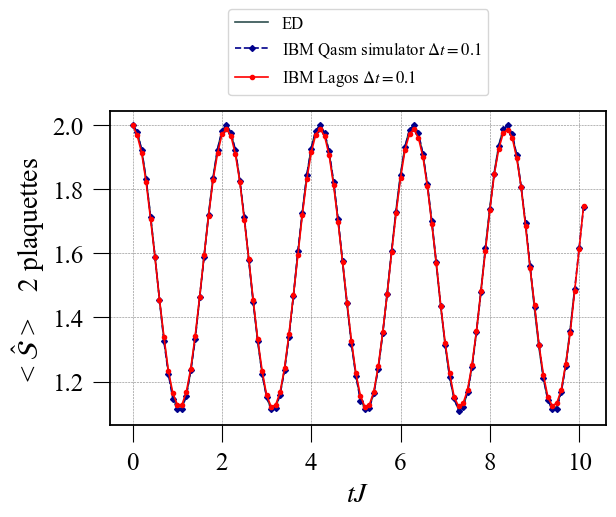

<Figure size 640x480 with 0 Axes>

In [130]:
#czzlists2n1,czzlist211n1,czzlist212n1, tlist2n1 = run_czz()

#czzlists2c1,czzlist211c1,czzlist212c1, tlist2c1 = run_czz()

#figure_styling()
fig, ax = plt.subplots()
#fig.set_size_inches(6, 4)
#fig.tight_layout()
ax.plot(tlist2, klist2,label='ED',color='darkslategray')
#ax.plot(ktlist4, clists4,label='ED',color='grey')
#ax.plot(tlist4, czzlists4l,label=' IBM cal',color='red', marker='s', markersize=3)
#ax.plot(ktlist2, klist2,label='ED',color='grey')
ax.plot(tlist2n1, czzlists2n1,label='IBM Qasm simulator $\Delta t = 0.1$',color='darkblue',marker='D',markersize=3,linestyle='dashed')
#ax.plot(tlist4n3, czzlists4n3,label='IBM Lagos native $\Delta t = 0.3$', marker='s',color='green', markersize=3)

ax.plot(tlist2c1, czzlists2c1,label='IBM Lagos $\Delta t = 0.1$', marker='o',color='red', markersize=3)

#ax.plot(tlist2, czzlist211,label='h11',color='magenta',marker='o')

#ax.plot(tlist2, czzlist212,label='h12',color='red',marker='o')
#ax.plot(tlist6, czz_list6_14,label='s614',color='darkgreen')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

    # plt.rcParams["font.family"] = "Times New Roman"
    # plt.rcParams["font.family"] = "serif"
    # plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
rc = {"font.family": "serif", "mathtext.fontset": "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

legend = ax.legend()
plt.xlabel('$tJ$',fontsize=20)
plt.ylabel('< $\hat{\mathcal{S}}$ >    2 plaquettes ',fontsize=20)
#plt.ylabel('< $\hat{\mathcal{C}}_{ij}$ > (4 plaquettes)',fontsize=16)
#plt.title('2 plaquette')
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.4)
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width, pos.height * 0.85])
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.35),
    fontsize=12
)
#plt.legend(bbox_to_anchor=(0.2,1),fontsize=12)
#plt.legend(fontsize=8)
#plt.style.use("cyberpunk")
#mplcyberpunk.add_glow_effects()
plt.figure()
plt.savefig('2_plaq_s.pdf')
plt.savefig('2_plaq_s.png')
plt.show()



In [366]:
#czzlists2c1
#tlist2c1

In [91]:
#czzlist212c1

In [92]:
tlist2=[0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1,
       5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4,
       6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7,
       7.8, 7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. ,
       9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9]
klist2=[2.000000000000001,
 1.9801495507224924,
 1.9223713844043027,
 1.8318266525647404,
 1.7166034464340778,
 1.5869943118523135,
 1.454576846803073,
 1.3311795090667307,
 1.2278250153150023,
 1.1537457146590846,
 1.1155588903998026,
 1.1166756578182828,
 1.1569962594070462,
 1.2329189759110497,
 1.3376618571819123,
 1.461868533586321,
 1.5944439926397551,
 1.7235456634279926,
 1.8376412781967275,
 1.9265390154840727,
 1.982297905177941,
 1.999937171725963,
 1.9778811519815689,
 1.9181000445001593,
 1.8259339175698917,
 1.7096156968155678,
 1.5795357424722887,
 1.4473137094507593,
 1.3247605981703625,
 1.2228237130678228,
 1.1506087724956995,
 1.1145665220210654,
 1.1179165085359442,
 1.1603594877220624,
 1.2381041546545792,
 1.3442058097795595,
 1.4691867082420744,
 1.601882678606978,
 1.7304403850435088,
 1.8433761505128352,
 1.9306017594366638,
 1.9843256079496057,
 1.999748704667114,
 1.975493350293273,
 1.9137262033957563,
 1.8199647392488414,
 1.702584390199577,
 1.572070393240367,
 1.440081175016108,
 1.3184069392937252,
 1.2179164831738576,
 1.1475863198158698,
 1.1136988332516378,
 1.1192810917304967,
 1.1638344487278973,
 1.2433790855543505,
 1.3508095167060623,
 1.476529301723061,
 1.6093082666348804,
 1.7372856619550605,
 1.8490296481084814,
 1.9345584676137233,
 1.98623208575069,
 1.999434652108224,
 1.9729868207541654,
 1.9092510976950876,
 1.8139208052508606,
 1.695511514527971,
 1.5646003748140798,
 1.4328812883335686,
 1.3121203287892138,
 1.2131047130406365,
 1.1446792111492794,
 1.1129560694107647,
 1.1207690215971087,
 1.1674201599584384,
 1.248742277243747,
 1.3574711109136308,
 1.4838942380781417,
 1.6167186573075036,
 1.7440795588164444,
 1.8546001725859325,
 1.9384080213460915,
 1.9880167995680014,
 1.9989951028405035,
 1.9703622720284104,
 1.9046759926324042,
 1.8078038243606864,
 1.6883990694953193,
 1.5571277991710697,
 1.425716085007184,
 1.3059025440528236,
 1.208389763086616,
 1.141888268414718,
 1.112338440498012,
 1.1223798774574862,
 1.1711156076354734,
 1.2541922134024197,
 1.3641887089881677,
 1.4912794350392375]
kcorr211=[1.0000000000000004,
 0.9900747753612462,
 0.9611856922021513,
 0.9159133262823702,
 0.8583017232170389,
 0.7934971559261568,
 0.7272884234015367,
 0.6655897545333653,
 0.6139125076575012,
 0.5768728573295422,
 0.5577794451999012,
 0.5583378289091414,
 0.5784981297035231,
 0.6164594879555249,
 0.668830928590956,
 0.7309342667931604,
 0.7972219963198777,
 0.8617728317139963,
 0.9188206390983638,
 0.9632695077420362,
 0.9911489525889705,
 0.9999685858629817,
 0.9889405759907846,
 0.9590500222500797,
 0.9129669587849458,
 0.8548078484077839,
 0.7897678712361443,
 0.7236568547253796,
 0.6623802990851813,
 0.6114118565339114,
 0.5753043862478497,
 0.5572832610105327,
 0.5589582542679721,
 0.5801797438610312,
 0.6190520773272896,
 0.6721029048897798,
 0.7345933541210372,
 0.8009413393034891,
 0.8652201925217544,
 0.9216880752564177,
 0.965300879718332,
 0.9921628039748028,
 0.9998743523335571,
 0.9877466751466365,
 0.956863101697878,
 0.9099823696244207,
 0.8512921950997884,
 0.7860351966201835,
 0.720040587508054,
 0.6592034696468626,
 0.6089582415869288,
 0.5737931599079349,
 0.5568494166258189,
 0.5596405458652484,
 0.5819172243639487,
 0.6216895427771753,
 0.6754047583530312,
 0.7382646508615305,
 0.8046541333174402,
 0.8686428309775303,
 0.9245148240542407,
 0.9672792338068615,
 0.993116042875345,
 0.999717326054112,
 0.9864934103770826,
 0.9546255488475437,
 0.9069604026254303,
 0.8477557572639856,
 0.7823001874070399,
 0.7164406441667843,
 0.6560601643946069,
 0.6065523565203182,
 0.5723396055746397,
 0.5564780347053824,
 0.5603845107985543,
 0.5837100799792192,
 0.6243711386218734,
 0.6787355554568155,
 0.7419471190390707,
 0.8083593286537517,
 0.8720397794082223,
 0.9273000862929663,
 0.9692040106730457,
 0.9940083997840007,
 0.9994975514202518,
 0.9851811360142051,
 0.9523379963162021,
 0.9039019121803432,
 0.8441995347476597,
 0.7785638995855348,
 0.712858042503592,
 0.6529512720264117,
 0.604194881543308,
 0.570944134207359,
 0.556169220249006,
 0.5611899387287432,
 0.5855578038177367,
 0.6270961067012099,
 0.6820943544940837,
 0.7456397175196188]
kcorr212=[1.0000000000000004,
 0.980149550722492,
 0.922371384404302,
 0.83182665256474,
 0.7166034464340774,
 0.5869943118523129,
 0.4545768468030726,
 0.3311795090667301,
 0.22782501531500196,
 0.15374571465908396,
 0.11555889039980205,
 0.11667565781828235,
 0.156996259407046,
 0.23291897591104915,
 0.33766185718191166,
 0.4618685335863205,
 0.5944439926397548,
 0.7235456634279922,
 0.8376412781967271,
 0.9265390154840718,
 0.9822979051779408,
 0.9999371717259627,
 0.9778811519815688,
 0.9181000445001589,
 0.825933917569891,
 0.7096156968155672,
 0.5795357424722883,
 0.44731370945075866,
 0.3247605981703619,
 0.22282371306782225,
 0.15060877249569907,
 0.1145665220210651,
 0.1179165085359438,
 0.16035948772206204,
 0.23810415465457868,
 0.3442058097795593,
 0.4691867082420739,
 0.6018826786069778,
 0.7304403850435081,
 0.843376150512835,
 0.9306017594366637,
 0.9843256079496051,
 0.9997487046671137,
 0.9754933502932722,
 0.9137262033957556,
 0.819964739248841,
 0.7025843901995763,
 0.5720703932403663,
 0.44008117501610755,
 0.31840693929372466,
 0.21791648317385703,
 0.1475863198158695,
 0.1136988332516376,
 0.11928109173049614,
 0.16383444872789674,
 0.24337908555435006,
 0.3508095167060618,
 0.47652930172306046,
 0.6093082666348799,
 0.7372856619550601,
 0.8490296481084809,
 0.9345584676137224,
 0.9862320857506895,
 0.9994346521082235,
 0.9729868207541646,
 0.9092510976950866,
 0.8139208052508602,
 0.6955115145279706,
 0.5646003748140793,
 0.4328812883335682,
 0.31212032878921353,
 0.21310471304063583,
 0.14467921114927912,
 0.11295606941076453,
 0.12076902159710831,
 0.16742015995843795,
 0.24874227724374623,
 0.35747111091363054,
 0.4838942380781409,
 0.616718657307503,
 0.7440795588164442,
 0.8546001725859319,
 0.938408021346091,
 0.9880167995680008,
 0.9989951028405029,
 0.9703622720284099,
 0.9046759926324038,
 0.8078038243606859,
 0.6883990694953188,
 0.557127799171069,
 0.4257160850071834,
 0.305902544052823,
 0.20838976308661541,
 0.1418882684147175,
 0.11233844049801153,
 0.12237987745748576,
 0.17111560763547307,
 0.2541922134024192,
 0.364188708988167,
 0.49127943503923693]

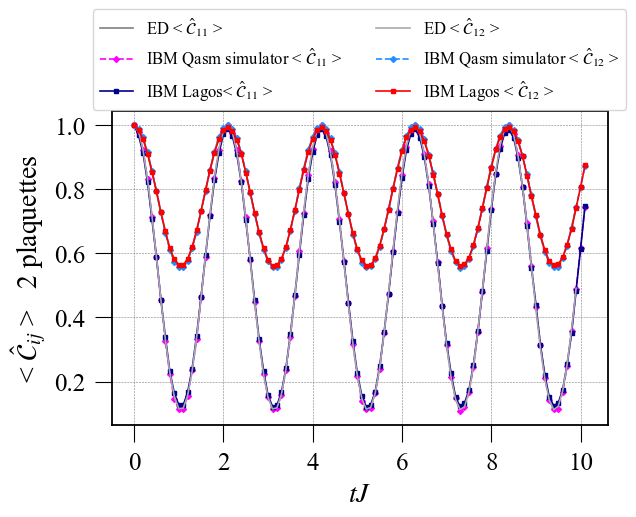

<Figure size 640x480 with 0 Axes>

In [129]:
#czzlists2n1,czzlist211n1,czzlist212n1, tlist2n1 = run_czz()
#figure_styling()
fig, ax = plt.subplots()
#fig.set_size_inches(6, 4)
#fig.tight_layout()
#ax.plot(ktlist2, klist211,label='< $\hat{\mathcal{C}}_{11}$ > ED',color='darkslategray')
ax.plot(tlist2, kcorr211,label='ED < $\hat{\mathcal{C}}_{11}$ > ',color='grey')
ax.plot(tlist2n1,czzlist211n1,label='IBM Qasm simulator < $\hat{\mathcal{C}}_{11}$ >',color='magenta',marker='D',markersize=3,linestyle='dashed')
ax.plot(tlist2c1, czzlist211c1,label='IBM Lagos< $\hat{\mathcal{C}}_{11}$ >', marker='s', color='darkblue',markersize=3)
#ax.plot(tlist4c1, czzlist411c1,label='IBM Lagos scaled < $\hat{\mathcal{C}}_{11}$ >', marker='o',color='magenta', markersize=3)

ax.plot(tlist2, kcorr212,label='ED < $\hat{\mathcal{C}}_{12}$ > ',color='darkgrey')
#ax.plot(tlist4, czzlists4l,label=' IBM cal',color='red', marker='s', markersize=3)

ax.plot(tlist2n1,czzlist212n1,label='IBM Qasm simulator < $\hat{\mathcal{C}}_{12}$ >',color='dodgerblue',marker='D',markersize=3,linestyle='dashed')


ax.plot(tlist2c1,czzlist212c1,label='IBM Lagos < $\hat{\mathcal{C}}_{12}$ >', marker='s', color='red',markersize=3)
#ax.plot(tlist4n3, czzlists4n3,label='IBM Lagos native $\Delta t = 0.3$', marker='s',color='green', markersize=3)


#ax.plot(tlist4c1, czzlist412c1,label='IBM Lagos scaled < $\hat{\mathcal{C}}_{12}$ >', marker='o',color='red', markersize=3)
#ax.plot(tlists2, czzlists4s2,label=' IBM ideal 2', marker='o',color='cornflowerblue', markersize=3)
#ax.plot(tlists3, czzlists4s3,label=' IBM ideal 3',color='navy', marker='o', markersize=3)
#ax.plot(tlist2, czzlist212,label='< $\hat{\mathcal{C}}_{12}$ > IBM qasm simulator',color='royalblue', marker='o', markersize=4)
#ax.plot(tlist2, czzlist211l,label='< $\hat{\mathcal{C}}_{11}$ > IBM Lagos',color='firebrick', marker='s', markersize=4)
#ax.plot(tlist2, czzlist212l,label='< $\hat{\mathcal{C}}_{12}$ > IBM Lagos',color='indianred', marker='s', markersize=4)


#ax.plot(tlist2, czzlist211,label='h11',color='magenta',marker='o')

#ax.plot(tlist2, czzlist212,label='h12',color='red',marker='o')
#ax.plot(tlist6, czz_list6_14,label='s614',color='darkgreen')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

    # plt.rcParams["font.family"] = "Times New Roman"
    # plt.rcParams["font.family"] = "serif"
    # plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
rc = {"font.family": "serif", "mathtext.fontset": "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

legend = ax.legend()
plt.xlabel('$tJ$',fontsize=20)
plt.ylabel('< $\hat{\mathcal{C}}_{ij}$ >   2 plaquettes',fontsize=20)
#plt.ylabel('< $\hat{\mathcal{C}}_{ij}$ > (4 plaquettes)',fontsize=16)
#plt.title('2 plaquette')
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.4)
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width, pos.height * 0.85])
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.35),
    ncol=2, fontsize=12
)
#plt.legend(bbox_to_anchor=(0.06,1),fontsize=12,ncol=2)
#plt.legend(fontsize=8)
#plt.style.use("cyberpunk")
#mplcyberpunk.add_glow_effects()
plt.figure()
plt.savefig('2_plaq_s.pdf')
plt.savefig('2_plaq_s.png')
plt.show()





In [266]:
ktlist2= [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1,
       5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4,
       6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7,
       7.8, 7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. ,
       9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9]

klist2=[2.000000000000001,
 1.9801495507224924,
 1.9223713844043027,
 1.8318266525647404,
 1.7166034464340778,
 1.5869943118523135,
 1.454576846803073,
 1.3311795090667307,
 1.2278250153150023,
 1.1537457146590846,
 1.1155588903998026,
 1.1166756578182828,
 1.1569962594070462,
 1.2329189759110497,
 1.3376618571819123,
 1.461868533586321,
 1.5944439926397551,
 1.7235456634279926,
 1.8376412781967275,
 1.9265390154840727,
 1.982297905177941,
 1.999937171725963,
 1.9778811519815689,
 1.9181000445001593,
 1.8259339175698917,
 1.7096156968155678,
 1.5795357424722887,
 1.4473137094507593,
 1.3247605981703625,
 1.2228237130678228,
 1.1506087724956995,
 1.1145665220210654,
 1.1179165085359442,
 1.1603594877220624,
 1.2381041546545792,
 1.3442058097795595,
 1.4691867082420744,
 1.601882678606978,
 1.7304403850435088,
 1.8433761505128352,
 1.9306017594366638,
 1.9843256079496057,
 1.999748704667114,
 1.975493350293273,
 1.9137262033957563,
 1.8199647392488414,
 1.702584390199577,
 1.572070393240367,
 1.440081175016108,
 1.3184069392937252,
 1.2179164831738576,
 1.1475863198158698,
 1.1136988332516378,
 1.1192810917304967,
 1.1638344487278973,
 1.2433790855543505,
 1.3508095167060623,
 1.476529301723061,
 1.6093082666348804,
 1.7372856619550605,
 1.8490296481084814,
 1.9345584676137233,
 1.98623208575069,
 1.999434652108224,
 1.9729868207541654,
 1.9092510976950876,
 1.8139208052508606,
 1.695511514527971,
 1.5646003748140798,
 1.4328812883335686,
 1.3121203287892138,
 1.2131047130406365,
 1.1446792111492794,
 1.1129560694107647,
 1.1207690215971087,
 1.1674201599584384,
 1.248742277243747,
 1.3574711109136308,
 1.4838942380781417,
 1.6167186573075036,
 1.7440795588164444,
 1.8546001725859325,
 1.9384080213460915,
 1.9880167995680014,
 1.9989951028405035,
 1.9703622720284104,
 1.9046759926324042,
 1.8078038243606864,
 1.6883990694953193,
 1.5571277991710697,
 1.425716085007184,
 1.3059025440528236,
 1.208389763086616,
 1.141888268414718,
 1.112338440498012,
 1.1223798774574862,
 1.1711156076354734,
 1.2541922134024197,
 1.3641887089881677,
 1.4912794350392375]
kcorr211=[1.0000000000000004,
 0.9900747753612462,
 0.9611856922021513,
 0.9159133262823702,
 0.8583017232170389,
 0.7934971559261568,
 0.7272884234015367,
 0.6655897545333653,
 0.6139125076575012,
 0.5768728573295422,
 0.5577794451999012,
 0.5583378289091414,
 0.5784981297035231,
 0.6164594879555249,
 0.668830928590956,
 0.7309342667931604,
 0.7972219963198777,
 0.8617728317139963,
 0.9188206390983638,
 0.9632695077420362,
 0.9911489525889705,
 0.9999685858629817,
 0.9889405759907846,
 0.9590500222500797,
 0.9129669587849458,
 0.8548078484077839,
 0.7897678712361443,
 0.7236568547253796,
 0.6623802990851813,
 0.6114118565339114,
 0.5753043862478497,
 0.5572832610105327,
 0.5589582542679721,
 0.5801797438610312,
 0.6190520773272896,
 0.6721029048897798,
 0.7345933541210372,
 0.8009413393034891,
 0.8652201925217544,
 0.9216880752564177,
 0.965300879718332,
 0.9921628039748028,
 0.9998743523335571,
 0.9877466751466365,
 0.956863101697878,
 0.9099823696244207,
 0.8512921950997884,
 0.7860351966201835,
 0.720040587508054,
 0.6592034696468626,
 0.6089582415869288,
 0.5737931599079349,
 0.5568494166258189,
 0.5596405458652484,
 0.5819172243639487,
 0.6216895427771753,
 0.6754047583530312,
 0.7382646508615305,
 0.8046541333174402,
 0.8686428309775303,
 0.9245148240542407,
 0.9672792338068615,
 0.993116042875345,
 0.999717326054112,
 0.9864934103770826,
 0.9546255488475437,
 0.9069604026254303,
 0.8477557572639856,
 0.7823001874070399,
 0.7164406441667843,
 0.6560601643946069,
 0.6065523565203182,
 0.5723396055746397,
 0.5564780347053824,
 0.5603845107985543,
 0.5837100799792192,
 0.6243711386218734,
 0.6787355554568155,
 0.7419471190390707,
 0.8083593286537517,
 0.8720397794082223,
 0.9273000862929663,
 0.9692040106730457,
 0.9940083997840007,
 0.9994975514202518,
 0.9851811360142051,
 0.9523379963162021,
 0.9039019121803432,
 0.8441995347476597,
 0.7785638995855348,
 0.712858042503592,
 0.6529512720264117,
 0.604194881543308,
 0.570944134207359,
 0.556169220249006,
 0.5611899387287432,
 0.5855578038177367,
 0.6270961067012099,
 0.6820943544940837,
 0.7456397175196188]

In [276]:
kcorr211=[1.0000000000000004,
 0.9900747753612462,
 0.9611856922021513,
 0.9159133262823702,
 0.8583017232170389,
 0.7934971559261568,
 0.7272884234015367,
 0.6655897545333653,
 0.6139125076575012,
 0.5768728573295422,
 0.5577794451999012,
 0.5583378289091414,
 0.5784981297035231,
 0.6164594879555249,
 0.668830928590956,
 0.7309342667931604,
 0.7972219963198777,
 0.8617728317139963,
 0.9188206390983638,
 0.9632695077420362,
 0.9911489525889705,
 0.9999685858629817,
 0.9889405759907846,
 0.9590500222500797,
 0.9129669587849458,
 0.8548078484077839,
 0.7897678712361443,
 0.7236568547253796,
 0.6623802990851813,
 0.6114118565339114,
 0.5753043862478497,
 0.5572832610105327,
 0.5589582542679721,
 0.5801797438610312,
 0.6190520773272896,
 0.6721029048897798,
 0.7345933541210372,
 0.8009413393034891,
 0.8652201925217544,
 0.9216880752564177,
 0.965300879718332,
 0.9921628039748028,
 0.9998743523335571,
 0.9877466751466365,
 0.956863101697878,
 0.9099823696244207,
 0.8512921950997884,
 0.7860351966201835,
 0.720040587508054,
 0.6592034696468626,
 0.6089582415869288,
 0.5737931599079349,
 0.5568494166258189,
 0.5596405458652484,
 0.5819172243639487,
 0.6216895427771753,
 0.6754047583530312,
 0.7382646508615305,
 0.8046541333174402,
 0.8686428309775303,
 0.9245148240542407,
 0.9672792338068615,
 0.993116042875345,
 0.999717326054112,
 0.9864934103770826,
 0.9546255488475437,
 0.9069604026254303,
 0.8477557572639856,
 0.7823001874070399,
 0.7164406441667843,
 0.6560601643946069,
 0.6065523565203182,
 0.5723396055746397,
 0.5564780347053824,
 0.5603845107985543,
 0.5837100799792192,
 0.6243711386218734,
 0.6787355554568155,
 0.7419471190390707,
 0.8083593286537517,
 0.8720397794082223,
 0.9273000862929663,
 0.9692040106730457,
 0.9940083997840007,
 0.9994975514202518,
 0.9851811360142051,
 0.9523379963162021,
 0.9039019121803432,
 0.8441995347476597,
 0.7785638995855348,
 0.712858042503592,
 0.6529512720264117,
 0.604194881543308,
 0.570944134207359,
 0.556169220249006,
 0.5611899387287432,
 0.5855578038177367,
 0.6270961067012099,
 0.6820943544940837,
 0.7456397175196188]
kcorr212=[1.0000000000000004,
 0.980149550722492,
 0.922371384404302,
 0.83182665256474,
 0.7166034464340774,
 0.5869943118523129,
 0.4545768468030726,
 0.3311795090667301,
 0.22782501531500196,
 0.15374571465908396,
 0.11555889039980205,
 0.11667565781828235,
 0.156996259407046,
 0.23291897591104915,
 0.33766185718191166,
 0.4618685335863205,
 0.5944439926397548,
 0.7235456634279922,
 0.8376412781967271,
 0.9265390154840718,
 0.9822979051779408,
 0.9999371717259627,
 0.9778811519815688,
 0.9181000445001589,
 0.825933917569891,
 0.7096156968155672,
 0.5795357424722883,
 0.44731370945075866,
 0.3247605981703619,
 0.22282371306782225,
 0.15060877249569907,
 0.1145665220210651,
 0.1179165085359438,
 0.16035948772206204,
 0.23810415465457868,
 0.3442058097795593,
 0.4691867082420739,
 0.6018826786069778,
 0.7304403850435081,
 0.843376150512835,
 0.9306017594366637,
 0.9843256079496051,
 0.9997487046671137,
 0.9754933502932722,
 0.9137262033957556,
 0.819964739248841,
 0.7025843901995763,
 0.5720703932403663,
 0.44008117501610755,
 0.31840693929372466,
 0.21791648317385703,
 0.1475863198158695,
 0.1136988332516376,
 0.11928109173049614,
 0.16383444872789674,
 0.24337908555435006,
 0.3508095167060618,
 0.47652930172306046,
 0.6093082666348799,
 0.7372856619550601,
 0.8490296481084809,
 0.9345584676137224,
 0.9862320857506895,
 0.9994346521082235,
 0.9729868207541646,
 0.9092510976950866,
 0.8139208052508602,
 0.6955115145279706,
 0.5646003748140793,
 0.4328812883335682,
 0.31212032878921353,
 0.21310471304063583,
 0.14467921114927912,
 0.11295606941076453,
 0.12076902159710831,
 0.16742015995843795,
 0.24874227724374623,
 0.35747111091363054,
 0.4838942380781409,
 0.616718657307503,
 0.7440795588164442,
 0.8546001725859319,
 0.938408021346091,
 0.9880167995680008,
 0.9989951028405029,
 0.9703622720284099,
 0.9046759926324038,
 0.8078038243606859,
 0.6883990694953188,
 0.557127799171069,
 0.4257160850071834,
 0.305902544052823,
 0.20838976308661541,
 0.1418882684147175,
 0.11233844049801153,
 0.12237987745748576,
 0.17111560763547307,
 0.2541922134024192,
 0.364188708988167,
 0.49127943503923693]

In [141]:
def run_czz():

    #J=1
    #L=1
    dt = 0.1
    T =  10.0+ dt/2
    #time = np.arange(0.0, 5.0+ dt/2, 0.1)
    
    czzlists4= [4.0]
    #czzlist611 = [1.0]
    #czzlist612 = [1.0]
    #czzlist613 = [1.0]
    #czzlist614 = [1.0]
    czzlist411 = [1.0]
    czzlist412 = [1.0]
    steps = 1
    nshots = 20000
    
    
    op=S4
    op4_1=h4_11
    op4_2=h4_12
    #op=h4_11
    #op1=h6_11
    #op2=h6_12
    #op3=h6_13
    #op4=h6_14
    #op=S4
    tlist4 = []
    t = 0
    
    tlist4.append(t)

    while t < T:
        #circuit = trotter_circuit_six_plaq_ham(steps,dt) #### eval f circ
        circ4 = trotter_circuit_four_plaquette_calibrated(steps,dt)
        circ4.measure_all()
        #circ = trotter_circuit_eight_plaquette(steps,dt)
        #backend_durations = qiskit.transpiler.InstructionDurations.from_backend(backend)
        #dd_sequence = [XGate(), XGate(),XGate(), XGate()]
        #pm = PassManager([ALAPScheduleAnalysis(backend_durations),PadDynamicalDecoupling(backend_durations, dd_sequence),])
        #circuit = trotter_circuit_four_plaquette(steps,dt)
        #transpiled_circuit =transpile(circ4,backend=backend,scheduling_method='alap')
        #tcirc4 =transpile(circ4,backend=backend,optimization_level=3)
        #tcirc4.measure_all()
        #transpiled_circuit.measure_all()
        #circ_dd = pm.run(transpiled_circuit)
        #transpiled_circuit =transpile(circ2,  optimization_level=3)
        #folded = fold_gates_at_random(circuit, scale_factor=scaling) # generate scaled circuit
        #circ_dd.measure_all()
        #transpiled_circuit.measure_all()
        #backend='ibmq_qasm_simulator'
        #result = execute(circ, backend=FakeLagos(),shots=nshots).result()
        job4 = execute(circ4,backend=FakeLagos(),shots=nshots)
        result4 = job4.result()
        counts4 = result4.get_counts()
        #result = execute(transpiled_circuit,Aer.get_backend('qasm_simulator'),shots=nshots).result()
        #result = execute(circ_dd, backend=FakeLagos(),shots=nshots).result()
        #counts = result.get_counts()
        
        czz4 = compute_expect_z(op, counts4)
        czz411 = compute_expect_z(op4_1, counts4)
        czz412 = compute_expect_z(op4_2, counts4)

        #czz611 = compute_expect_z(op1, counts)
        #czz612 = compute_expect_z(op2, counts)
        #czz613 = compute_expect_z(op3, counts)
        #czz614 = compute_expect_z(op4, counts)
        #czz = compute_expect_z(op, counts)
        t=steps*dt
        #print(t, czz, end='\r' )
        tlist4.append(t)
        czzlists4.append(czz4)
        czzlist411.append(czz411)
        czzlist412.append(czz412)
        #czzlist614.append(czz614)
       
    
        steps += 1
        
    #print(tlist,czz_list)
    print(steps)
    return czzlists4,czzlist411,czzlist412, tlist4


In [47]:
import numpy as np


In [48]:
#device =provider.backend('ibmq_qasm_simulator')

In [131]:
import qiskit

In [132]:
#s operator
ktlist4= [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1,
       5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4,
       6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7,
       7.8, 7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. ,
       9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9]
clists4=[4.0,
 3.9214536664198985,
 3.702647239812509,
 3.3896991169128343,
 3.0460944301842634,
 2.7365368432122996,
 2.511034318621224,
 2.393569893574057,
 2.3783675025359763,
 2.434578824384756,
 2.5178156298660626,
 2.5850195232889,
 2.6082481121032473,
 2.58332135052358,
 2.530805486780842,
 2.48907104330855,
 2.5014941607709797,
 2.6016050097619376,
 2.8006221167216454,
 3.081161972101409,
 3.399162427358543,
 3.6937057927693635,
 3.902146448395288,
 3.9763923837432995,
 3.89580830576904,
 3.67311306570232,
 3.3515820476352465,
 2.9942866690516787,
 2.668320719786617,
 2.428347256566155,
 2.303958157477501,
 2.294228678420893,
 2.370790324859827,
 2.4883260450494333,
 2.5993027840353764,
 2.6685926265962276,
 2.6837241870317214,
 2.6578200977513395,
 2.6244334499077366,
 2.6258737771932616,
 2.6985268019500817,
 2.8595703233851455,
 3.099111474320699,
 3.380224323759064,
 3.647093483017228,
 3.8391203923438777,
 3.907098687960372,
 3.8269177009227113,
 3.606898287357649,
 3.286623172719277,
 2.9274969253212744,
 2.597584474211866,
 2.3548739260654417,
 2.2335355982018843,
 2.23688461202072,
 2.3388468865974064,
 2.493322685246765,
 2.6486239464381547,
 2.762762587035699,
 2.8151828167855504,
 2.8116092226091345,
 2.780710551981646,
 2.763671972098643,
 2.7998376102377973,
 2.9127354304308115,
 3.1006969747931477,
 3.3349629901470634,
 3.5660011560024594,
 3.7363752198833753,
 3.7965816781729385,
 3.71936478561012,
 3.508396620296399,
 3.1987633457842186,
 2.84899159553128,
 2.52672821289824,
 2.291974968091405,
 2.1824678343215482,
 2.205181953212253,
 2.336212094479561,
 2.5289176903696644,
 2.7279037986390904,
 2.8847938388374303,
 2.9712944340244083,
 2.985882913377295,
 2.9523220875369067,
 2.91058479927165,
 2.9029691575838115,
 2.9595733495845313,
 3.087478579615227,
 3.2669090049703384,
 3.455608977416639,
 3.6002834340351684,
 3.651875423467028,
 3.5803023194965546,
 3.38437332646847,
 3.0939408200327536,
 2.763520320782508,
 2.459027335392762,
 2.241235655184116,
 2.150502290983106]

102


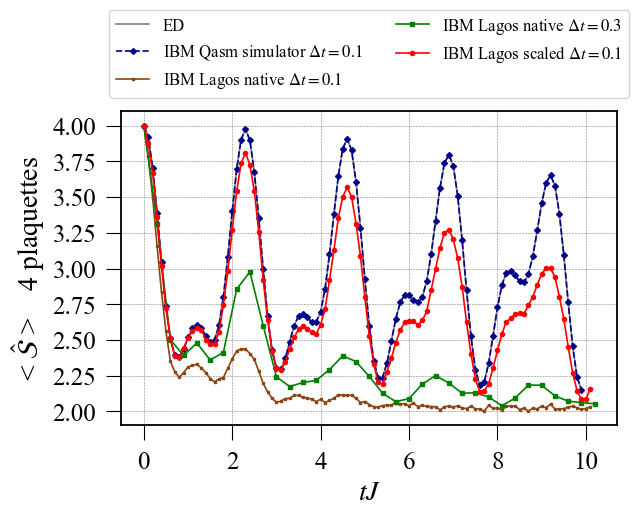

<Figure size 640x480 with 0 Axes>

In [142]:
#czzlists4n1,czzlist411n1,czzlist412n1, tlist4n1 = run_czz()
#czzlists4n3,czzlist411n3,czzlist412n3, tlist4n3 = run_czz()
#czzlists4c1,czzlist411c1,czzlist412c1, tlist4c1 = run_czz()

figure_styling()
fig, ax = plt.subplots()
#fig.set_size_inches(6, 4)
#fig.tight_layout()
#ax.plot(ktlist2, klist211,label='< $\hat{\mathcal{C}}_{11}$ > ED',color='darkslategray')
ax.plot(ktlist4, clists4,label='ED',color='grey')
#ax.plot(tlist4, czzlists4l,label=' IBM cal',color='red', marker='s', markersize=3)
ax.plot(ktlist4, clists4,label='IBM Qasm simulator $\Delta t = 0.1$',color='darkblue',marker='D',markersize=3,linestyle='dashed')
ax.plot(tlist4n1, czzlists4n1,label='IBM Lagos native $\Delta t = 0.1$', marker='s', color='saddlebrown',markersize=2)
ax.plot(tlist4n3, czzlists4n3,label='IBM Lagos native $\Delta t = 0.3$', marker='s',color='green', markersize=3)

ax.plot(tlist4c1, czzlists4c1,label='IBM Lagos scaled $\Delta t = 0.1$', marker='o',color='red', markersize=3)
#ax.plot(tlists2, czzlists4s2,label=' IBM ideal 2', marker='o',color='cornflowerblue', markersize=3)
#ax.plot(tlists3, czzlists4s3,label=' IBM ideal 3',color='navy', marker='o', markersize=3)
#ax.plot(tlist2, czzlist212,label='< $\hat{\mathcal{C}}_{12}$ > IBM qasm simulator',color='royalblue', marker='o', markersize=4)
#ax.plot(tlist2, czzlist211l,label='< $\hat{\mathcal{C}}_{11}$ > IBM Lagos',color='firebrick', marker='s', markersize=4)
#ax.plot(tlist2, czzlist212l,label='< $\hat{\mathcal{C}}_{12}$ > IBM Lagos',color='indianred', marker='s', markersize=4)


#ax.plot(tlist2, czzlist211,label='h11',color='magenta',marker='o')

#ax.plot(tlist2, czzlist212,label='h12',color='red',marker='o')
#ax.plot(tlist6, czz_list6_14,label='s614',color='darkgreen')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

    # plt.rcParams["font.family"] = "Times New Roman"
    # plt.rcParams["font.family"] = "serif"
    # plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
rc = {"font.family": "serif", "mathtext.fontset": "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

legend = ax.legend()
plt.xlabel('$tJ$',fontsize=20)
plt.ylabel('< $\hat{\mathcal{S}}$ >    4 plaquettes',fontsize=20)
#plt.ylabel('< $\hat{\mathcal{C}}_{ij}$ > (4 plaquettes)',fontsize=16)
#plt.title('2 plaquette')
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.4)
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width, pos.height * 0.85])
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.35),
    ncol=2, fontsize=12
)
#plt.legend(bbox_to_anchor=(0.06,1),fontsize=12,ncol=2)
#plt.legend(fontsize=8)
#plt.style.use("cyberpunk")
#mplcyberpunk.add_glow_effects()
plt.figure()
plt.savefig('4_plaq_s.pdf')
plt.savefig('4_plaq_s.png')
plt.show()





In [144]:
#czzlists4n1

In [146]:
#czzlists4n3

In [152]:
#tlist4c1

In [154]:
#czzlists4c1

In [150]:
#tlist4n1

In [148]:
#tlist4n3

In [158]:
klist411=[1.0,
 0.9803634166049746,
 0.9256618099531272,
 0.8474247792282086,
 0.7615236075460659,
 0.6841342108030749,
 0.627758579655306,
 0.5983924733935142,
 0.5945918756339942,
 0.608644706096189,
 0.6294539074665156,
 0.6462548808222252,
 0.6520620280258118,
 0.645830337630895,
 0.6327013716952106,
 0.6222677608271375,
 0.6253735401927449,
 0.6504012524404844,
 0.7001555291804114,
 0.7702904930253525,
 0.8497906068396356,
 0.9234264481923408,
 0.975536612098822,
 0.9940980959358249,
 0.97395207644226,
 0.91827826642558,
 0.8378955119088115,
 0.7485716672629196,
 0.6670801799466544,
 0.6070868141415389,
 0.5759895393693754,
 0.5735571696052233,
 0.5926975812149567,
 0.6220815112623584,
 0.6498256960088442,
 0.6671481566490569,
 0.6709310467579302,
 0.6644550244378349,
 0.656108362476934,
 0.6564684442983155,
 0.6746317004875204,
 0.7148925808462864,
 0.7747778685801746,
 0.8450560809397663,
 0.911773370754307,
 0.9597800980859695,
 0.976774671990093,
 0.9567294252306778,
 0.9017245718394123,
 0.8216557931798194,
 0.7318742313303186,
 0.6493961185529664,
 0.5887184815163604,
 0.5583838995504712,
 0.55922115300518,
 0.5847117216493516,
 0.6233306713116914,
 0.6621559866095387,
 0.6906906467589248,
 0.7037957041963876,
 0.7029023056522837,
 0.6951776379954115,
 0.6909179930246607,
 0.6999594025594492,
 0.7281838576077028,
 0.7751742436982869,
 0.8337407475367659,
 0.8915002890006148,
 0.9340938049708438,
 0.9491454195432346,
 0.92984119640253,
 0.8770991550740997,
 0.7996908364460548,
 0.7122478988828198,
 0.63168205322456,
 0.5729937420228512,
 0.5456169585803871,
 0.5512954883030633,
 0.5840530236198902,
 0.6322294225924161,
 0.6819759496597726,
 0.7211984597093578,
 0.742823608506102,
 0.7464707283443236,
 0.7380805218842268,
 0.7276461998179125,
 0.7257422893959529,
 0.7398933373961329,
 0.7718696449038067,
 0.8167272512425844,
 0.8639022443541599,
 0.9000708585087922,
 0.9129688558667569,
 0.8950755798741385,
 0.8460933316171174,
 0.7734852050081885,
 0.6908800801956271,
 0.6147568338481905,
 0.560308913796029,
 0.5376255727457765]
klist412= [1.0,
 0.9607268332099492,
 0.8513236199062546,
 0.694849558456417,
 0.5230472150921315,
 0.3682684216061497,
 0.25551715931061214,
 0.19678494678702865,
 0.1891837512679883,
 0.21728941219237813,
 0.2589078149330314,
 0.29250976164445047,
 0.3041240560516237,
 0.29166067526179007,
 0.2654027433904211,
 0.2445355216542749,
 0.25074708038549004,
 0.30080250488096894,
 0.40031105836082276,
 0.5405809860507048,
 0.6995812136792712,
 0.8468528963846818,
 0.9510732241976442,
 0.9881961918716499,
 0.94790415288452,
 0.8365565328511597,
 0.6757910238176233,
 0.49714333452583936,
 0.3341603598933088,
 0.21417362828307773,
 0.15197907873875088,
 0.14711433921044667,
 0.18539516242991352,
 0.24416302252471683,
 0.2996513920176883,
 0.3342963132981138,
 0.3418620935158606,
 0.3289100488756699,
 0.31221672495386826,
 0.3129368885966311,
 0.3492634009750409,
 0.42978516169257275,
 0.549555737160349,
 0.6901121618795324,
 0.8235467415086138,
 0.9195601961719391,
 0.9535493439801861,
 0.9134588504613556,
 0.8034491436788247,
 0.6433115863596388,
 0.4637484626606374,
 0.29879223710593317,
 0.17743696303272094,
 0.11676779910094243,
 0.11844230601036024,
 0.16942344329870335,
 0.24666134262338268,
 0.32431197321907734,
 0.38138129351784966,
 0.4075914083927755,
 0.40580461130456724,
 0.39035527599082315,
 0.3818359860493217,
 0.39991880511889843,
 0.45636771521540553,
 0.5503484873965739,
 0.6674814950735316,
 0.7830005780012298,
 0.8681876099416879,
 0.898290839086469,
 0.8596823928050602,
 0.7541983101481995,
 0.5993816728921098,
 0.42449579776563967,
 0.2633641064491202,
 0.14598748404570244,
 0.09123391716077442,
 0.10259097660612682,
 0.16810604723978026,
 0.26445884518483254,
 0.36395189931954536,
 0.4423969194187157,
 0.4856472170122038,
 0.49294145668864753,
 0.4761610437684534,
 0.45529239963582496,
 0.4514845787919062,
 0.47978667479226556,
 0.543739289807613,
 0.6334545024851688,
 0.7278044887083194,
 0.8001417170175843,
 0.8259377117335138,
 0.7901511597482772,
 0.6921866632342351,
 0.5469704100163773,
 0.38176016039125427,
 0.22951366769638123,
 0.12061782759205797,
 0.07525114549155301]

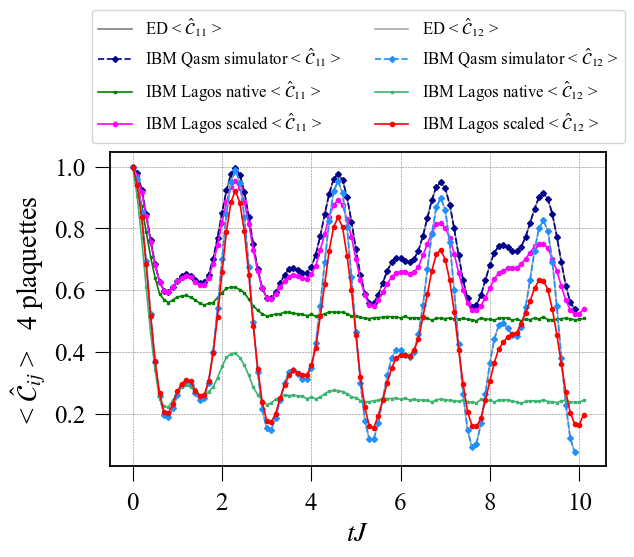

<Figure size 640x480 with 0 Axes>

In [164]:
#czzlists4n1,czzlist411n1,czzlist412n1, tlist4n1 = run_czz()
#czzlists4n3,czzlist411n3,czzlist412n3, tlist4n3 = run_czz()
#czzlists4c1,czzlist411c1,czzlist412c1, tlist4c1 = run_czz()

#figure_styling()
fig, ax = plt.subplots()
#fig.set_size_inches(6, 4)
#fig.tight_layout()
#ax.plot(ktlist2, klist211,label='< $\hat{\mathcal{C}}_{11}$ > ED',color='darkslategray')
ax.plot(ktlist4, klist411,label='ED < $\hat{\mathcal{C}}_{11}$ > ',color='grey')
ax.plot(ktlist4, klist411,label='IBM Qasm simulator < $\hat{\mathcal{C}}_{11}$ >',color='darkblue',marker='D',markersize=3,linestyle='dashed')
ax.plot(tlist4n1, czzlist411n1,label='IBM Lagos native < $\hat{\mathcal{C}}_{11}$ >', marker='s', color='green',markersize=2)
ax.plot(tlist4c1, czzlist411c1,label='IBM Lagos scaled < $\hat{\mathcal{C}}_{11}$ >', marker='o',color='magenta', markersize=3)

ax.plot(ktlist4, klist412,label='ED < $\hat{\mathcal{C}}_{12}$ > ',color='darkgrey')
#ax.plot(tlist4, czzlists4l,label=' IBM cal',color='red', marker='s', markersize=3)

ax.plot(ktlist4, klist412,label='IBM Qasm simulator < $\hat{\mathcal{C}}_{12}$ >',color='dodgerblue',marker='D',markersize=3,linestyle='dashed')


ax.plot(tlist4n1, czzlist412n1,label='IBM Lagos native < $\hat{\mathcal{C}}_{12}$ >', marker='s', color='mediumseagreen',markersize=2)
#ax.plot(tlist4n3, czzlists4n3,label='IBM Lagos native $\Delta t = 0.3$', marker='s',color='green', markersize=3)


ax.plot(tlist4c1, czzlist412c1,label='IBM Lagos scaled < $\hat{\mathcal{C}}_{12}$ >', marker='o',color='red', markersize=3)
#ax.plot(tlists2, czzlists4s2,label=' IBM ideal 2', marker='o',color='cornflowerblue', markersize=3)
#ax.plot(tlists3, czzlists4s3,label=' IBM ideal 3',color='navy', marker='o', markersize=3)
#ax.plot(tlist2, czzlist212,label='< $\hat{\mathcal{C}}_{12}$ > IBM qasm simulator',color='royalblue', marker='o', markersize=4)
#ax.plot(tlist2, czzlist211l,label='< $\hat{\mathcal{C}}_{11}$ > IBM Lagos',color='firebrick', marker='s', markersize=4)
#ax.plot(tlist2, czzlist212l,label='< $\hat{\mathcal{C}}_{12}$ > IBM Lagos',color='indianred', marker='s', markersize=4)


#ax.plot(tlist2, czzlist211,label='h11',color='magenta',marker='o')

#ax.plot(tlist2, czzlist212,label='h12',color='red',marker='o')
#ax.plot(tlist6, czz_list6_14,label='s614',color='darkgreen')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

    # plt.rcParams["font.family"] = "Times New Roman"
    # plt.rcParams["font.family"] = "serif"
    # plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
rc = {"font.family": "serif", "mathtext.fontset": "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

legend = ax.legend()
plt.xlabel('$tJ$',fontsize=20)
plt.ylabel('< $\hat{\mathcal{C}}_{ij}$ >   4 plaquettes',fontsize=20)
#plt.ylabel('< $\hat{\mathcal{C}}_{ij}$ > (4 plaquettes)',fontsize=16)
#plt.title('2 plaquette')
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.4)
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width, pos.height * 0.85])
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.48),
    ncol=2, fontsize=12
)
#plt.legend(bbox_to_anchor=(0.06,1),fontsize=12,ncol=2)
#plt.legend(fontsize=8)
#plt.style.use("cyberpunk")
#mplcyberpunk.add_glow_effects()
plt.figure()
plt.savefig('4_plaq_corr.pdf')
plt.savefig('4_plaq_corr.png')
plt.show()



In [167]:
#czzlist412n1

In [170]:
#czzlist412c1

In [199]:
ktlist4= [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1,
       5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4,
       6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7,
       7.8, 7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. ,
       9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9]
klist411=[1.0,
 0.9803634166049746,
 0.9256618099531272,
 0.8474247792282086,
 0.7615236075460659,
 0.6841342108030749,
 0.627758579655306,
 0.5983924733935142,
 0.5945918756339942,
 0.608644706096189,
 0.6294539074665156,
 0.6462548808222252,
 0.6520620280258118,
 0.645830337630895,
 0.6327013716952106,
 0.6222677608271375,
 0.6253735401927449,
 0.6504012524404844,
 0.7001555291804114,
 0.7702904930253525,
 0.8497906068396356,
 0.9234264481923408,
 0.975536612098822,
 0.9940980959358249,
 0.97395207644226,
 0.91827826642558,
 0.8378955119088115,
 0.7485716672629196,
 0.6670801799466544,
 0.6070868141415389,
 0.5759895393693754,
 0.5735571696052233,
 0.5926975812149567,
 0.6220815112623584,
 0.6498256960088442,
 0.6671481566490569,
 0.6709310467579302,
 0.6644550244378349,
 0.656108362476934,
 0.6564684442983155,
 0.6746317004875204,
 0.7148925808462864,
 0.7747778685801746,
 0.8450560809397663,
 0.911773370754307,
 0.9597800980859695,
 0.976774671990093,
 0.9567294252306778,
 0.9017245718394123,
 0.8216557931798194,
 0.7318742313303186,
 0.6493961185529664,
 0.5887184815163604,
 0.5583838995504712,
 0.55922115300518,
 0.5847117216493516,
 0.6233306713116914,
 0.6621559866095387,
 0.6906906467589248,
 0.7037957041963876,
 0.7029023056522837,
 0.6951776379954115,
 0.6909179930246607,
 0.6999594025594492,
 0.7281838576077028,
 0.7751742436982869,
 0.8337407475367659,
 0.8915002890006148,
 0.9340938049708438,
 0.9491454195432346,
 0.92984119640253,
 0.8770991550740997,
 0.7996908364460548,
 0.7122478988828198,
 0.63168205322456,
 0.5729937420228512,
 0.5456169585803871,
 0.5512954883030633,
 0.5840530236198902,
 0.6322294225924161,
 0.6819759496597726,
 0.7211984597093578,
 0.742823608506102,
 0.7464707283443236,
 0.7380805218842268,
 0.7276461998179125,
 0.7257422893959529,
 0.7398933373961329,
 0.7718696449038067,
 0.8167272512425844,
 0.8639022443541599,
 0.9000708585087922,
 0.9129688558667569,
 0.8950755798741385,
 0.8460933316171174,
 0.7734852050081885,
 0.6908800801956271,
 0.6147568338481905,
 0.560308913796029,
 0.5376255727457765]

klist412=[1.0,
 0.9607268332099492,
 0.8513236199062546,
 0.694849558456417,
 0.5230472150921315,
 0.3682684216061497,
 0.25551715931061214,
 0.19678494678702865,
 0.1891837512679883,
 0.21728941219237813,
 0.2589078149330314,
 0.29250976164445047,
 0.3041240560516237,
 0.29166067526179007,
 0.2654027433904211,
 0.2445355216542749,
 0.25074708038549004,
 0.30080250488096894,
 0.40031105836082276,
 0.5405809860507048,
 0.6995812136792712,
 0.8468528963846818,
 0.9510732241976442,
 0.9881961918716499,
 0.94790415288452,
 0.8365565328511597,
 0.6757910238176233,
 0.49714333452583936,
 0.3341603598933088,
 0.21417362828307773,
 0.15197907873875088,
 0.14711433921044667,
 0.18539516242991352,
 0.24416302252471683,
 0.2996513920176883,
 0.3342963132981138,
 0.3418620935158606,
 0.3289100488756699,
 0.31221672495386826,
 0.3129368885966311,
 0.3492634009750409,
 0.42978516169257275,
 0.549555737160349,
 0.6901121618795324,
 0.8235467415086138,
 0.9195601961719391,
 0.9535493439801861,
 0.9134588504613556,
 0.8034491436788247,
 0.6433115863596388,
 0.4637484626606374,
 0.29879223710593317,
 0.17743696303272094,
 0.11676779910094243,
 0.11844230601036024,
 0.16942344329870335,
 0.24666134262338268,
 0.32431197321907734,
 0.38138129351784966,
 0.4075914083927755,
 0.40580461130456724,
 0.39035527599082315,
 0.3818359860493217,
 0.39991880511889843,
 0.45636771521540553,
 0.5503484873965739,
 0.6674814950735316,
 0.7830005780012298,
 0.8681876099416879,
 0.898290839086469,
 0.8596823928050602,
 0.7541983101481995,
 0.5993816728921098,
 0.42449579776563967,
 0.2633641064491202,
 0.14598748404570244,
 0.09123391716077442,
 0.10259097660612682,
 0.16810604723978026,
 0.26445884518483254,
 0.36395189931954536,
 0.4423969194187157,
 0.4856472170122038,
 0.49294145668864753,
 0.4761610437684534,
 0.45529239963582496,
 0.4514845787919062,
 0.47978667479226556,
 0.543739289807613,
 0.6334545024851688,
 0.7278044887083194,
 0.8001417170175843,
 0.8259377117335138,
 0.7901511597482772,
 0.6921866632342351,
 0.5469704100163773,
 0.38176016039125427,
 0.22951366769638123,
 0.12061782759205797,
 0.07525114549155301]


In [188]:
#np.loadtxt('t4.txt')

In [36]:
np.savetxt('2sims2.txt', czzlist2)
np.savetxt('2simh11.txt', czzlist211)
np.savetxt('2simh12.txt', czzlist212)
np.savetxt('2simtime.txt', tlist2)
np.savetxt('2lsims2.txt', czzlist2l)
np.savetxt('2lsimh11.txt', czzlist211l)
np.savetxt('2lsimh12.txt', czzlist212l)

# 6 plaquette

In [180]:
def run_czz():

    #J=1
    #L=1
    dt = 0.25
    T =  10.0+ dt/2
    #time = np.arange(0.0, 5.0+ dt/2, 0.1)
    
    czzlists6= [6.0]
    czzlist611 = [1.0]
    czzlist612 = [1.0]
    czzlist613 = [1.0]
    czzlist614 = [1.0]
    #czzlist411 = [1.0]
    #czzlist412 = [1.0]
    steps = 1
    nshots = 20000
    
    
    op=S6
    #op4_1=h4_11
    #op4_2=h4_12
    #op=h4_11
    op1=h6_11
    op2=h6_12
    op3=h6_13
    op4=h6_14
    #op=S4
    tlist6 = []
    t = 0
    
    tlist6.append(t)

    while t < T:
        #circuit = trotter_circuit_six_plaq_ham(steps,dt) #### eval f circ
        #circ6 = trotter_six_plaquette(steps,dt)
        circ6 = trotter_six_plaquette_calibrated(steps,dt)
        circ6.measure_all()
        #circ = trotter_circuit_eight_plaquette(steps,dt)
        #backend_durations = qiskit.transpiler.InstructionDurations.from_backend(backend)
        #dd_sequence = [XGate(), XGate(),XGate(), XGate()]
        #pm = PassManager([ALAPScheduleAnalysis(backend_durations),PadDynamicalDecoupling(backend_durations, dd_sequence),])
        #circuit = trotter_circuit_four_plaquette(steps,dt)
        #transpiled_circuit =transpile(circ4,backend=backend,scheduling_method='alap')
        #tcirc4 =transpile(circ4,backend=backend,optimization_level=3)
        #tcirc4.measure_all()
        #transpiled_circuit.measure_all()
        #circ_dd = pm.run(transpiled_circuit)
        #transpiled_circuit =transpile(circ2,  optimization_level=3)
        #folded = fold_gates_at_random(circuit, scale_factor=scaling) # generate scaled circuit
        #circ_dd.measure_all()
        #transpiled_circuit.measure_all()
        #backend='ibmq_qasm_simulator'
        #result = execute(circ, backend=FakeLagos(),shots=nshots).result()
        #job6 = execute(circ6,backend=Aer.get_backend('qasm_simulator'),shots=nshots)
        job6 = execute(circ6,backend=FakeLagos(),shots=nshots)
        result6 = job6.result()
        counts6 = result6.get_counts()
        #result = execute(transpiled_circuit,Aer.get_backend('qasm_simulator'),shots=nshots).result()
        #result = execute(circ_dd, backend=FakeLagos(),shots=nshots).result()
        #counts = result.get_counts()
        
        czz6 = compute_expect_z(op, counts6)
        #czz411 = compute_expect_z(op4_1, counts4)
        #czz412 = compute_expect_z(op4_2, counts4)

        czz611 = compute_expect_z(op1, counts6)
        czz612 = compute_expect_z(op2, counts6)
        czz613 = compute_expect_z(op3, counts6)
        czz614 = compute_expect_z(op4, counts6)
        #czz = compute_expect_z(op, counts)
        t=steps*dt
        #print(t, czz, end='\r' )
        tlist6.append(t)
        czzlists6.append(czz6)
        czzlist611.append(czz611)
        czzlist612.append(czz612)
        czzlist613.append(czz613)
        czzlist614.append(czz614)
       
    
        steps += 1
        
    #print(tlist,czz_list)
    print(steps)
    return czzlists6,czzlist611,czzlist612,czzlist613,czzlist614, tlist6

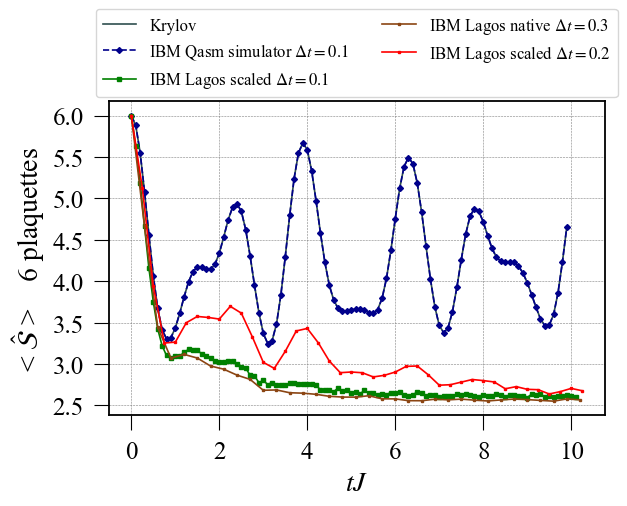

<Figure size 640x480 with 0 Axes>

In [186]:
#czzlists6n,czzlist611n,czzlist612n,czzlist613n,czzlist614n, tlist6n = run_czz()
#czzlists4n3,czzlist411n3,czzlist412n3, tlist4n3 = run_czz()
#czzlists6c1,czzlist611c1,czzlist612c1,czzlist613c1,czzlist614c1, tlist6c1 = run_czz()
#czzlists6c2,czzlist611c2,czzlist612c2,czzlist613c2,czzlist614c2, tlist6c2 = run_czz()

figure_styling()
fig, ax = plt.subplots()
#fig.set_size_inches(6, 4)
#fig.tight_layout()
ax.plot(tlist6, klist6,label='Krylov',color='darkslategray')
ax.plot(tlist6, klist6,label='IBM Qasm simulator $\Delta t = 0.1$',color='darkblue',marker='D',markersize=3,linestyle='dashed')
#ax.plot(ktlist4, clists4,label='ED',color='grey')
#ax.plot(tlist4, czzlists4l,label=' IBM cal',color='red', marker='s', markersize=3)
#ax.plot(ktlist4, clists4,label='IBM Qasm simulator $\Delta t = 0.1$',color='darkblue',marker='D',markersize=3,linestyle='dashed')
ax.plot(tlist6c1, czzlists6c1,label='IBM Lagos scaled $\Delta t = 0.1$', marker='s', color='green',markersize=3)
ax.plot(tlist6n, czzlists6n,label='IBM Lagos native $\Delta t = 0.3$', marker='s',color='saddlebrown', markersize=2)
ax.plot(tlist6c2, czzlists6c2,label='IBM Lagos scaled $\Delta t = 0.2$', marker='s', color='red',markersize=2)


#ax.plot(tlist4c1, czzlists4c1,label='IBM Lagos scaled $\Delta t = 0.1$', marker='o',color='red', markersize=3)
#ax.plot(tlists2, czzlists4s2,label=' IBM ideal 2', marker='o',color='cornflowerblue', markersize=3)
#ax.plot(tlists3, czzlists4s3,label=' IBM ideal 3',color='navy', marker='o', markersize=3)
#ax.plot(tlist2, czzlist212,label='< $\hat{\mathcal{C}}_{12}$ > IBM qasm simulator',color='royalblue', marker='o', markersize=4)
#ax.plot(tlist2, czzlist211l,label='< $\hat{\mathcal{C}}_{11}$ > IBM Lagos',color='firebrick', marker='s', markersize=4)
#ax.plot(tlist2, czzlist212l,label='< $\hat{\mathcal{C}}_{12}$ > IBM Lagos',color='indianred', marker='s', markersize=4)


#ax.plot(tlist2, czzlist211,label='h11',color='magenta',marker='o')

#ax.plot(tlist2, czzlist212,label='h12',color='red',marker='o')
#ax.plot(tlist6, czz_list6_14,label='s614',color='darkgreen')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

    # plt.rcParams["font.family"] = "Times New Roman"
    # plt.rcParams["font.family"] = "serif"
    # plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
rc = {"font.family": "serif", "mathtext.fontset": "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

legend = ax.legend()
plt.xlabel('$tJ$',fontsize=20)
plt.ylabel('< $\hat{\mathcal{S}}$ >    6 plaquettes',fontsize=20)
#plt.ylabel('< $\hat{\mathcal{C}}_{ij}$ > (4 plaquettes)',fontsize=16)
#plt.title('2 plaquette')
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.4)
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width, pos.height * 0.85])
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.32),
    ncol=2, fontsize=12
)
#plt.legend(bbox_to_anchor=(0.06,1),fontsize=12,ncol=2)
#plt.legend(fontsize=8)
#plt.style.use("cyberpunk")
#mplcyberpunk.add_glow_effects()
plt.figure()
plt.savefig('6_plaq_s.pdf')
plt.savefig('6_plaq_s.png')
plt.show()

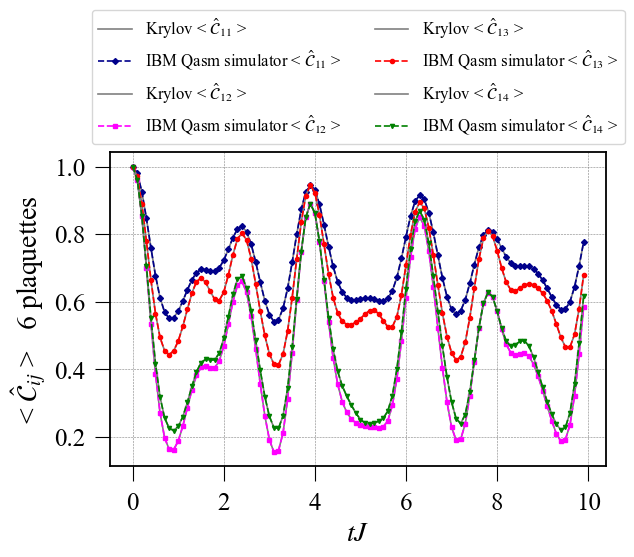

<Figure size 640x480 with 0 Axes>

In [197]:
#figure_styling()
fig, ax = plt.subplots()
#fig.set_size_inches(6, 4)
#fig.tight_layout()
#ax.plot(ktlist2, klist211,label='< $\hat{\mathcal{C}}_{11}$ > ED',color='darkslategray')
ax.plot(tlist6, k611,label='Krylov < $\hat{\mathcal{C}}_{11}$ > ',color='grey')
ax.plot(tlist6, k611,label='IBM Qasm simulator < $\hat{\mathcal{C}}_{11}$ >',color='darkblue',marker='D',markersize=3,linestyle='dashed')
#ax.plot(tlist6n,czzlist611n,label='IBM Lagos native < $\hat{\mathcal{C}}_{11}$ >', marker='D', color='darkgreen',markersize=2)
#ax.plot(tlist6c2, czzlist611c2,label='IBM Lagos scaled < $\hat{\mathcal{C}}_{11}$ >', marker='D',color='magenta', markersize=3)

ax.plot(tlist6, k612,label='Krylov < $\hat{\mathcal{C}}_{12}$ > ',color='grey')
ax.plot(tlist6, k612,label='IBM Qasm simulator < $\hat{\mathcal{C}}_{12}$ >',color='magenta',marker='s',markersize=3,linestyle='dashed')
#ax.plot(tlist6n,czzlist612n,label='IBM Lagos native < $\hat{\mathcal{C}}_{12}$ >', marker='s', color='green',markersize=2)
#ax.plot(tlist6c2, czzlist612c2,label='IBM Lagos scaled < $\hat{\mathcal{C}}_{12}$ >', marker='s',color='red', markersize=3)


ax.plot(tlist6, k613,label='Krylov < $\hat{\mathcal{C}}_{13}$ > ',color='grey')
ax.plot(tlist6, k613,label='IBM Qasm simulator < $\hat{\mathcal{C}}_{13}$ >',color='red',marker='o',markersize=3,linestyle='dashed')
#ax.plot(tlist6n,czzlist613n,label='IBM Lagos native < $\hat{\mathcal{C}}_{13}$ >', marker='o', color='lightgreen',markersize=2)
#ax.plot(tlist6c2, czzlist613c2,label='IBM Lagos scaled < $\hat{\mathcal{C}}_{13}$ >', marker='o',color='orange', markersize=3)


ax.plot(tlist6, k614,label='Krylov < $\hat{\mathcal{C}}_{14}$ > ',color='grey')
ax.plot(tlist6, k614,label='IBM Qasm simulator < $\hat{\mathcal{C}}_{14}$ >',color='green',marker='v',markersize=3,linestyle='dashed')
#ax.plot(tlist6n,czzlist614n,label='IBM Lagos native < $\hat{\mathcal{C}}_{14}$ >', marker='v', color='darkolivegreen',markersize=2)
#ax.plot(tlist6c2, czzlist614c2,label='IBM Lagos scaled < $\hat{\mathcal{C}}_{14}$ >', marker='v',color='firebrick', markersize=3)


#ax.plot(ktlist4, klist412,label='ED < $\hat{\mathcal{C}}_{12}$ > ',color='darkgrey')
#ax.plot(tlist4, czzlists4l,label=' IBM cal',color='red', marker='s', markersize=3)

#ax.plot(ktlist4, klist412,label='IBM Qasm simulator < $\hat{\mathcal{C}}_{12}$ >',color='dodgerblue',marker='D',markersize=3,linestyle='dashed')


##ax.plot(tlist4n1, czzlist412n1,label='IBM Lagos native < $\hat{\mathcal{C}}_{12}$ >', marker='s', color='mediumseagreen',markersize=2)
#ax.plot(tlist4n3, czzlists4n3,label='IBM Lagos native $\Delta t = 0.3$', marker='s',color='green', markersize=3)


#ax.plot(tlist4c1, czzlist412c1,label='IBM Lagos scaled < $\hat{\mathcal{C}}_{12}$ >', marker='o',color='red', markersize=3)
#ax.plot(tlists2, czzlists4s2,label=' IBM ideal 2', marker='o',color='cornflowerblue', markersize=3)
#ax.plot(tlists3, czzlists4s3,label=' IBM ideal 3',color='navy', marker='o', markersize=3)
#ax.plot(tlist2, czzlist212,label='< $\hat{\mathcal{C}}_{12}$ > IBM qasm simulator',color='royalblue', marker='o', markersize=4)
#ax.plot(tlist2, czzlist211l,label='< $\hat{\mathcal{C}}_{11}$ > IBM Lagos',color='firebrick', marker='s', markersize=4)
#ax.plot(tlist2, czzlist212l,label='< $\hat{\mathcal{C}}_{12}$ > IBM Lagos',color='indianred', marker='s', markersize=4)


#ax.plot(tlist2, czzlist211,label='h11',color='magenta',marker='o')

#ax.plot(tlist2, czzlist212,label='h12',color='red',marker='o')
#ax.plot(tlist6, czz_list6_14,label='s614',color='darkgreen')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

    # plt.rcParams["font.family"] = "Times New Roman"
    # plt.rcParams["font.family"] = "serif"
    # plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
rc = {"font.family": "serif", "mathtext.fontset": "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

legend = ax.legend()
plt.xlabel('$tJ$',fontsize=20)
plt.ylabel('< $\hat{\mathcal{C}}_{ij}$ >   6 plaquettes',fontsize=20)
#plt.ylabel('< $\hat{\mathcal{C}}_{ij}$ > (4 plaquettes)',fontsize=16)
#plt.title('2 plaquette')
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.4)
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width, pos.height * 0.85])
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.48),
    ncol=2, fontsize=12
)
#plt.legend(bbox_to_anchor=(0.06,1),fontsize=12,ncol=2)
#plt.legend(fontsize=8)
#plt.style.use("cyberpunk")
#mplcyberpunk.add_glow_effects()
plt.figure()
plt.savefig('6_plaq_corr.pdf')
plt.savefig('6_plaq_corr.png')
plt.show()


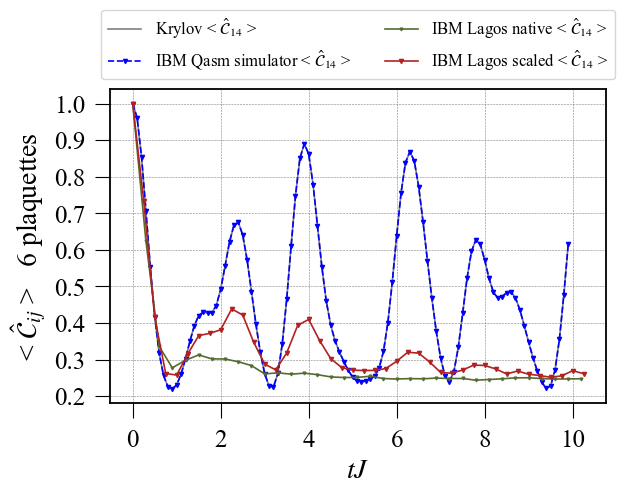

<Figure size 640x480 with 0 Axes>

In [206]:
#figure_styling()
fig, ax = plt.subplots()
#fig.set_size_inches(6, 4)
#fig.tight_layout()
#ax.plot(ktlist2, klist211,label='< $\hat{\mathcal{C}}_{11}$ > ED',color='darkslategray')
#ax.plot(tlist6, k611,label='Krylov < $\hat{\mathcal{C}}_{11}$ > ',color='grey')
#ax.plot(tlist6, k611,label='IBM Qasm simulator < $\hat{\mathcal{C}}_{11}$ >',color='darkblue',marker='D',markersize=3,linestyle='dashed')
#ax.plot(tlist6n,czzlist611n,label='IBM Lagos native < $\hat{\mathcal{C}}_{11}$ >', marker='D', color='darkgreen',markersize=2)
#ax.plot(tlist6c2, czzlist611c2,label='IBM Lagos scaled < $\hat{\mathcal{C}}_{11}$ >', marker='D',color='magenta', markersize=3)

#ax.plot(tlist6, k612,label='Krylov < $\hat{\mathcal{C}}_{12}$ > ',color='grey')
#ax.plot(tlist6, k612,label='IBM Qasm simulator < $\hat{\mathcal{C}}_{12}$ >',color='dodgerblue',marker='s',markersize=3,linestyle='dashed')
#ax.plot(tlist6n,czzlist612n,label='IBM Lagos native < $\hat{\mathcal{C}}_{12}$ >', marker='s', color='green',markersize=2)
#ax.plot(tlist6c2, czzlist612c2,label='IBM Lagos scaled < $\hat{\mathcal{C}}_{12}$ >', marker='s',color='red', markersize=3)


#ax.plot(tlist6, k613,label='Krylov < $\hat{\mathcal{C}}_{13}$ > ',color='grey')
#ax.plot(tlist6, k613,label='IBM Qasm simulator < $\hat{\mathcal{C}}_{13}$ >',color='navy',marker='o',markersize=3,linestyle='dashed')
#ax.plot(tlist6n,czzlist613n,label='IBM Lagos native < $\hat{\mathcal{C}}_{13}$ >', marker='o', color='lightgreen',markersize=2)
#ax.plot(tlist6c2, czzlist613c2,label='IBM Lagos scaled < $\hat{\mathcal{C}}_{13}$ >', marker='o',color='orange', markersize=3)


ax.plot(tlist6, k614,label='Krylov < $\hat{\mathcal{C}}_{14}$ > ',color='grey')
ax.plot(tlist6, k614,label='IBM Qasm simulator < $\hat{\mathcal{C}}_{14}$ >',color='blue',marker='v',markersize=3,linestyle='dashed')
ax.plot(tlist6n,czzlist614n,label='IBM Lagos native < $\hat{\mathcal{C}}_{14}$ >', marker='v', color='darkolivegreen',markersize=2)
ax.plot(tlist6c2, czzlist614c2,label='IBM Lagos scaled < $\hat{\mathcal{C}}_{14}$ >', marker='v',color='firebrick', markersize=3)


#ax.plot(ktlist4, klist412,label='ED < $\hat{\mathcal{C}}_{12}$ > ',color='darkgrey')
#ax.plot(tlist4, czzlists4l,label=' IBM cal',color='red', marker='s', markersize=3)

#ax.plot(ktlist4, klist412,label='IBM Qasm simulator < $\hat{\mathcal{C}}_{12}$ >',color='dodgerblue',marker='D',markersize=3,linestyle='dashed')


##ax.plot(tlist4n1, czzlist412n1,label='IBM Lagos native < $\hat{\mathcal{C}}_{12}$ >', marker='s', color='mediumseagreen',markersize=2)
#ax.plot(tlist4n3, czzlists4n3,label='IBM Lagos native $\Delta t = 0.3$', marker='s',color='green', markersize=3)


#ax.plot(tlist4c1, czzlist412c1,label='IBM Lagos scaled < $\hat{\mathcal{C}}_{12}$ >', marker='o',color='red', markersize=3)
#ax.plot(tlists2, czzlists4s2,label=' IBM ideal 2', marker='o',color='cornflowerblue', markersize=3)
#ax.plot(tlists3, czzlists4s3,label=' IBM ideal 3',color='navy', marker='o', markersize=3)
#ax.plot(tlist2, czzlist212,label='< $\hat{\mathcal{C}}_{12}$ > IBM qasm simulator',color='royalblue', marker='o', markersize=4)
#ax.plot(tlist2, czzlist211l,label='< $\hat{\mathcal{C}}_{11}$ > IBM Lagos',color='firebrick', marker='s', markersize=4)
#ax.plot(tlist2, czzlist212l,label='< $\hat{\mathcal{C}}_{12}$ > IBM Lagos',color='indianred', marker='s', markersize=4)


#ax.plot(tlist2, czzlist211,label='h11',color='magenta',marker='o')

#ax.plot(tlist2, czzlist212,label='h12',color='red',marker='o')
#ax.plot(tlist6, czz_list6_14,label='s614',color='darkgreen')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

    # plt.rcParams["font.family"] = "Times New Roman"
    # plt.rcParams["font.family"] = "serif"
    # plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
rc = {"font.family": "serif", "mathtext.fontset": "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

legend = ax.legend()
plt.xlabel('$tJ$',fontsize=20)
plt.ylabel('< $\hat{\mathcal{C}}_{ij}$ >   6 plaquettes',fontsize=20)
#plt.ylabel('< $\hat{\mathcal{C}}_{ij}$ > (4 plaquettes)',fontsize=16)
#plt.title('2 plaquette')
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.4)
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width, pos.height * 0.85])
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.28),
    ncol=2, fontsize=12
)
#plt.legend(bbox_to_anchor=(0.06,1),fontsize=12,ncol=2)
#plt.legend(fontsize=8)
#plt.style.use("cyberpunk")
#mplcyberpunk.add_glow_effects()
plt.figure()
plt.savefig('6_plaq_corr12.pdf')
plt.savefig('6_plaq_corr12.png')
plt.show()


In [182]:
tlist6=[0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1,
       5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4,
       6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7,
       7.8, 7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. ,
       9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9]

In [187]:
k611=[0.9999999999999996,
 0.9803626768553714,
 0.9256173907159341,
 0.8469703663092557,
 0.759332768743589,
 0.6773031685403645,
 0.6119497696773727,
 0.5692997712637307,
 0.5505372765177048,
 0.5531962833416872,
 0.5724719865657308,
 0.6021576116348447,
 0.635303799965699,
 0.6650501849363497,
 0.6859418330938718,
 0.6955183216809623,
 0.6954380726850651,
 0.6912929204374889,
 0.6907440628931633,
 0.7004582307974848,
 0.7230629004577862,
 0.7555116483671858,
 0.7897001726087626,
 0.8151579823454894,
 0.8226918202129017,
 0.807474276393871,
 0.7704347443114006,
 0.7176827566918124,
 0.6585719324876734,
 0.6034294702205371,
 0.561772842293541,
 0.5412365674711974,
 0.5468826214114438,
 0.580440099944289,
 0.6393736290587639,
 0.7162310420431945,
 0.7990303250967724,
 0.8732151489199247,
 0.9249885706906648,
 0.9450161107458551,
 0.9310729838419991,
 0.888497775901136,
 0.8282121159567452,
 0.7631211539246331,
 0.704369161783887,
 0.658852515257419,
 0.628662424701031,
 0.6121737581000214,
 0.605842217545544,
 0.6057334387570821,
 0.6083112962769511,
 0.6106678377790469,
 0.6107355893653896,
 0.6078660842730803,
 0.6036314032936029,
 0.6022145394144878,
 0.6096954740103984,
 0.632030819657419,
 0.6723126848713409,
 0.7284975122788728,
 0.7928070626970254,
 0.8533423392827001,
 0.8974360748681752,
 0.9154416558577813,
 0.9034651448086759,
 0.8640864864776648,
 0.8050728657573392,
 0.7369304989269452,
 0.6704368288817112,
 0.6149546383628249,
 0.5776430464139576,
 0.5631184736724608,
 0.5730309188346621,
 0.6054187773081742,
 0.6542653540522306,
 0.7099617680972174,
 0.7611212038771717,
 0.7974860183072786,
 0.8129338053975208,
 0.8072968394053132,
 0.7861008487279701,
 0.7582443322117195,
 0.732599084310241,
 0.7149931303276287,
 0.7067798208680399,
 0.705358447508269,
 0.7060697936498664,
 0.7043574087588558,
 0.6972103488466944,
 0.6835354605933388,
 0.6638089034846268,
 0.639683816687716,
 0.6140112207624842,
 0.5911621522668414,
 0.5770511952236405,
 0.5782327302919994,
 0.5999441806782391,
 0.6437149805253067,
 0.7056672928750473,
 0.7765383114137288]

k612=[0.9999999999999996,
 0.9608227188147431,
 0.8526720753242744,
 0.700293655928844,
 0.535216227275814,
 0.38594107666501254,
 0.27106153275163625,
 0.19753687950721865,
 0.1634808281907736,
 0.1627119232959017,
 0.1880852242931853,
 0.23221280968806915,
 0.28641004975403217,
 0.34006704001750393,
 0.38225995678552116,
 0.40558130813666293,
 0.41014967975397965,
 0.4049778686657017,
 0.404981908210745,
 0.42434093490252545,
 0.4692201421272857,
 0.5335988946727972,
 0.6005628823662185,
 0.6486461632048598,
 0.6602153507113669,
 0.6279494817745597,
 0.5566810098798706,
 0.460453857199587,
 0.35706828761462955,
 0.2632365658002808,
 0.1923923612325586,
 0.15501314215687712,
 0.15951678784314266,
 0.2115703476347106,
 0.311131452395783,
 0.4487193815196897,
 0.603771794779387,
 0.7474454192674226,
 0.8499877189222693,
 0.8900973339044457,
 0.8621478286066493,
 0.7777975360041027,
 0.6611047968002843,
 0.5394127770305831,
 0.4342194960044292,
 0.35594957057903187,
 0.3042387688111021,
 0.27241170409282434,
 0.2529537385398274,
 0.24092284835459257,
 0.23413270626247207,
 0.2312510618392798,
 0.23020258768586108,
 0.22870403153745875,
 0.22685373955956117,
 0.2297904388532483,
 0.24787630533511462,
 0.29312404680633125,
 0.3729575046883549,
 0.4843880995684894,
 0.6119864611495025,
 0.7313141198271442,
 0.8166689244659122,
 0.8497010176205686,
 0.8250101202886551,
 0.7504898717414193,
 0.6429543173191364,
 0.5218446009045459,
 0.4043011187886827,
 0.30344034271256154,
 0.2293194197329189,
 0.1903487641137594,
 0.19291092843715774,
 0.2386138481322597,
 0.32079962116625993,
 0.4231322691336098,
 0.5223913759793608,
 0.5953016120225004,
 0.626684294511496,
 0.6150155588967368,
 0.5724563269755185,
 0.5191302958914037,
 0.4743654070496984,
 0.4491140734705089,
 0.4429877869416475,
 0.44676703794469286,
 0.44838668047258123,
 0.43887243051588215,
 0.4152880178247176,
 0.3799344108288987,
 0.3373854569460844,
 0.29199568662761616,
 0.24770549894530153,
 0.2099375216574494,
 0.18754274396674675,
 0.19238993828384898,
 0.23560497507875394,
 0.3217919656726531,
 0.44430410695079964,
 0.5845902646954186]
k613=[0.9999999999999996,
 0.9706902283550166,
 0.8905923729955924,
 0.7800982123898547,
 0.6644258624072271,
 0.5650752980402438,
 0.4943814038750372,
 0.4550335731397316,
 0.4435523649808731,
 0.4547325745147247,
 0.48409906066696307,
 0.5273104750621284,
 0.5778683223185326,
 0.6258249249548546,
 0.6595443368846859,
 0.6703619889892849,
 0.6576615256184594,
 0.6310163541569059,
 0.6073220086517073,
 0.6036171138436863,
 0.628922069964585,
 0.679295309944838,
 0.7388105222492726,
 0.7860937978515583,
 0.8031692581325615,
 0.7822907125750193,
 0.7277517947681029,
 0.6525293988498523,
 0.5723073321936857,
 0.5004021042847686,
 0.44592286861362473,
 0.41503271749602844,
 0.4130780925028669,
 0.44496350624715103,
 0.5126798082683354,
 0.6112976371553331,
 0.7263811112861431,
 0.8354887424411629,
 0.9142590587743203,
 0.9447961237046247,
 0.9223915894589286,
 0.8571459123417392,
 0.769569876718907,
 0.6823391438941826,
 0.6122605182906433,
 0.5661236669567324,
 0.5417424075475028,
 0.5325863627748036,
 0.5326879887029315,
 0.5389243906441069,
 0.549925026499374,
 0.5632910279042055,
 0.573942559475743,
 0.5755197446087995,
 0.5644513036253267,
 0.5441100109955234,
 0.5258915985986394,
 0.5255797927019612,
 0.5561497964018922,
 0.6205273377527343,
 0.7082630615406458,
 0.798230230615044,
 0.8663139962692362,
 0.8944293850270547,
 0.8765934047972347,
 0.8195038358868277,
 0.7380892602873272,
 0.6490136147669742,
 0.5657219956034392,
 0.49708358032170374,
 0.44910433529250265,
 0.42722743079793213,
 0.43663307148880476,
 0.4796947595290204,
 0.5521465281026947,
 0.640935880955659,
 0.7261638399736835,
 0.7872040299092173,
 0.810439136826012,
 0.7947257920923498,
 0.7516032267482449,
 0.6999554274554575,
 0.6577786809788579,
 0.6351805453118797,
 0.6318935201425638,
 0.6399581779275494,
 0.6493979233249525,
 0.653334543841669,
 0.6498160008568601,
 0.6400231079248511,
 0.6249202878804916,
 0.6032927649325641,
 0.5729426640655707,
 0.5343957460359964,
 0.4944084318267426,
 0.4662623062782132,
 0.4655858261297918,
 0.5032307168388654,
 0.5788327857708607,
 0.6787442447915522]

k614=[0.9999999999999996,
 0.9609200839187428,
 0.8541093692166798,
 0.7066465792391757,
 0.5517669170644494,
 0.41727581624929566,
 0.31822352614852667,
 0.25647421648697544,
 0.22588710334613737,
 0.21903127990842836,
 0.23122647545490843,
 0.2601103961064477,
 0.3022124995766649,
 0.35003371016230667,
 0.3926362473832966,
 0.42012597291139925,
 0.42942321413782775,
 0.42736989645642504,
 0.42847569063516366,
 0.44776540821008176,
 0.49231448333899974,
 0.5561744926112233,
 0.6217254195149116,
 0.6669763617187394,
 0.675047060996929,
 0.6409504107613757,
 0.5724925311369385,
 0.48554220101554796,
 0.39699271025391114,
 0.31961419115948664,
 0.2612390378780346,
 0.2275531493713585,
 0.2252683328633967,
 0.26226049538084184,
 0.3435156466740369,
 0.46497667895298905,
 0.6094829393652283,
 0.7484605406949947,
 0.8499982964632083,
 0.8901624463171806,
 0.8621496895293006,
 0.7785995202059335,
 0.6657853616870782,
 0.5525832462119001,
 0.4597006684410845,
 0.39419411064322624,
 0.351152688220143,
 0.3204758919856062,
 0.29422304198856686,
 0.2703788191950203,
 0.2516428199710411,
 0.2411664481204642,
 0.23893399664094042,
 0.24167589452875474,
 0.2464446725319141,
 0.25515179887751904,
 0.2763616626494312,
 0.322186454297824,
 0.4012896396340277,
 0.5117811745792332,
 0.638358796904954,
 0.7559435610888879,
 0.8384656991954728,
 0.868518723525573,
 0.8430899509599569,
 0.7728067705275073,
 0.6757629031235934,
 0.5698282039552005,
 0.4677285798139419,
 0.37697140869947254,
 0.30335274663792194,
 0.25446058088259604,
 0.23976001920499002,
 0.2663901416481695,
 0.33306853422805693,
 0.42634100207278325,
 0.5225403442043771,
 0.5956311874304423,
 0.6275009782279498,
 0.6154374389828469,
 0.572710956495097,
 0.521771927359369,
 0.4835326454789152,
 0.4682418862857613,
 0.47241593214721606,
 0.4828171808728483,
 0.48463377364543053,
 0.4690300435140534,
 0.43615533795604616,
 0.3927979004711188,
 0.3471531069229133,
 0.3046237398797979,
 0.26738855636563214,
 0.23755073878121347,
 0.22098309748621026,
 0.2283144159836977,
 0.27132158880102897,
 0.3561539702946922,
 0.4772736281515044,
 0.6161039065633793]

In [183]:
klist6=[5.999999999999997,
 5.882176061132227,
 5.553704344295603,
 5.081822197855536,
 4.555996612461534,
 4.063819011242187,
 3.6716986180642355,
 3.415798627582384,
 3.3032236591062287,
 3.319177700050123,
 3.434831919394384,
 3.6129456698090694,
 3.8118227997941942,
 3.990301109618098,
 4.115650998563233,
 4.173109930085775,
 4.17262843611039,
 4.147757522624933,
 4.144464377358979,
 4.202749384784909,
 4.338377402746717,
 4.533069890203113,
 4.738201035652575,
 4.890947894072936,
 4.93615092127741,
 4.8448456583632264,
 4.622608465868403,
 4.306096540150872,
 3.95143159492604,
 3.6205768213232226,
 3.370637053761245,
 3.247419404827184,
 3.2812957284686632,
 3.482640599665734,
 3.8362417743525827,
 4.297386252259167,
 4.794181950580632,
 5.239290893519548,
 5.549931424143992,
 5.67009666447513,
 5.586437903051994,
 5.330986655406817,
 4.9692726957404725,
 4.5787269235478,
 4.226214970703324,
 3.9531150915445132,
 3.771974548206186,
 3.6730425486001286,
 3.6350533052732636,
 3.634400632542493,
 3.6498677776617052,
 3.6640070266742826,
 3.6644135361923387,
 3.647196505638482,
 3.621788419761618,
 3.613287236486928,
 3.658172844062391,
 3.792184917944513,
 4.033876109228047,
 4.370985073673236,
 4.756842376182154,
 5.120054035696199,
 5.384616449209051,
 5.492649935146688,
 5.420790868852054,
 5.184518918865986,
 4.830437194544034,
 4.421582993561672,
 4.022620973290268,
 3.68972783017695,
 3.465858278483746,
 3.3787108420347645,
 3.4381855130079733,
 3.6325126638490453,
 3.925592124313384,
 4.259770608583306,
 4.56672722326303,
 4.784916109843672,
 4.877602832385126,
 4.843781036431879,
 4.7166050923678196,
 4.549465993270316,
 4.395594505861446,
 4.2899587819657725,
 4.240678925208239,
 4.232150685049614,
 4.236418761899198,
 4.226144452553134,
 4.183262093080166,
 4.101212763560033,
 3.9828534209077624,
 3.8381029001262954,
 3.6840673245749054,
 3.5469729136010484,
 3.462307171341843,
 3.4693963817519955,
 3.599665084069435,
 3.86228988315184,
 4.234003757250282,
 4.659229868482372]

In [19]:
k611=[0.9999999999999996,
 0.9803626768553714,
 0.9256173907159341,
 0.8469703663092557,
 0.759332768743589,
 0.6773031685403645,
 0.6119497696773727,
 0.5692997712637307,
 0.5505372765177048,
 0.5531962833416872,
 0.5724719865657308,
 0.6021576116348447,
 0.635303799965699,
 0.6650501849363497,
 0.6859418330938718,
 0.6955183216809623,
 0.6954380726850651,
 0.6912929204374889,
 0.6907440628931633,
 0.7004582307974848,
 0.7230629004577862,
 0.7555116483671858,
 0.7897001726087626,
 0.8151579823454894,
 0.8226918202129017,
 0.807474276393871,
 0.7704347443114006,
 0.7176827566918124,
 0.6585719324876734,
 0.6034294702205371,
 0.561772842293541,
 0.5412365674711974,
 0.5468826214114438,
 0.580440099944289,
 0.6393736290587639,
 0.7162310420431945,
 0.7990303250967724,
 0.8732151489199247,
 0.9249885706906648,
 0.9450161107458551,
 0.9310729838419991,
 0.888497775901136,
 0.8282121159567452,
 0.7631211539246331,
 0.704369161783887,
 0.658852515257419,
 0.628662424701031,
 0.6121737581000214,
 0.605842217545544,
 0.6057334387570821,
 0.6083112962769511,
 0.6106678377790469,
 0.6107355893653896,
 0.6078660842730803,
 0.6036314032936029,
 0.6022145394144878,
 0.6096954740103984,
 0.632030819657419,
 0.6723126848713409,
 0.7284975122788728,
 0.7928070626970254,
 0.8533423392827001,
 0.8974360748681752,
 0.9154416558577813,
 0.9034651448086759,
 0.8640864864776648,
 0.8050728657573392,
 0.7369304989269452,
 0.6704368288817112,
 0.6149546383628249,
 0.5776430464139576,
 0.5631184736724608,
 0.5730309188346621,
 0.6054187773081742,
 0.6542653540522306,
 0.7099617680972174,
 0.7611212038771717,
 0.7974860183072786,
 0.8129338053975208,
 0.8072968394053132,
 0.7861008487279701,
 0.7582443322117195,
 0.732599084310241,
 0.7149931303276287,
 0.7067798208680399,
 0.705358447508269,
 0.7060697936498664,
 0.7043574087588558,
 0.6972103488466944,
 0.6835354605933388,
 0.6638089034846268,
 0.639683816687716,
 0.6140112207624842,
 0.5911621522668414,
 0.5770511952236405,
 0.5782327302919994,
 0.5999441806782391,
 0.6437149805253067,
 0.7056672928750473,
 0.7765383114137288]

# 8 plaquette

In [271]:
def run_czz():

    #J=1
    #L=1
    dt = 0.1
    T =  10.0+ dt/2
    #time = np.arange(0.0, 5.0+ dt/2, 0.1)
    
    czzlists8= [8.0]
    czzlist811 = [1.0]
    czzlist812 = [1.0]
    czzlist813 = [1.0]
    czzlist814 = [1.0]
    czzlist815 = [1.0]
    #czzlist411 = [1.0]
    #czzlist412 = [1.0]
    steps = 1
    nshots = 20000
    
    
    op=S8
    #op4_1=h4_11
    #op4_2=h4_12
    #op=h4_11
    op1=h8_11
    op2=h8_12
    op3=h8_13
    op4=h8_14
    op5=h8_15
    #op=S4
    tlist8 = []
    t = 0
    
    tlist8.append(t)

    while t < T:
        #circuit = trotter_circuit_six_plaq_ham(steps,dt) #### eval f circ
        #circ6 = trotter_six_plaquette(steps,dt)
        circ8 = trotter_circuit_eight_plaquette(steps,dt)
        circ8.measure_all()
        #circ = trotter_circuit_eight_plaquette(steps,dt)
        #backend_durations = qiskit.transpiler.InstructionDurations.from_backend(backend)
        #dd_sequence = [XGate(), XGate(),XGate(), XGate()]
        #pm = PassManager([ALAPScheduleAnalysis(backend_durations),PadDynamicalDecoupling(backend_durations, dd_sequence),])
        #circuit = trotter_circuit_four_plaquette(steps,dt)
        #transpiled_circuit =transpile(circ4,backend=backend,scheduling_method='alap')
        #tcirc4 =transpile(circ4,backend=backend,optimization_level=3)
        #tcirc4.measure_all()
        #transpiled_circuit.measure_all()
        #circ_dd = pm.run(transpiled_circuit)
        #transpiled_circuit =transpile(circ2,  optimization_level=3)
        #folded = fold_gates_at_random(circuit, scale_factor=scaling) # generate scaled circuit
        #circ_dd.measure_all()
        #transpiled_circuit.measure_all()
        #backend='ibmq_qasm_simulator'
        #result = execute(circ, backend=FakeLagos(),shots=nshots).result()
        #job8 = execute(circ8,backend=Aer.get_backend('qasm_simulator'),shots=nshots)
        job8 = execute(circ8,backend=FakeLagos(),shots=nshots)
        result8 = job8.result()
        counts8 = result8.get_counts()
        #result = execute(transpiled_circuit,Aer.get_backend('qasm_simulator'),shots=nshots).result()
        #result = execute(circ_dd, backend=FakeLagos(),shots=nshots).result()
        #counts = result.get_counts()
        
        czz8 = compute_expect_z(op, counts8)
        #czz411 = compute_expect_z(op4_1, counts4)
        #czz412 = compute_expect_z(op4_2, counts4)

        czz811 = compute_expect_z(op1, counts8)
        czz812 = compute_expect_z(op2, counts8)
        czz813 = compute_expect_z(op3, counts8)
        czz814 = compute_expect_z(op4, counts8)
        czz815 = compute_expect_z(op5, counts8)
        #czz = compute_expect_z(op, counts)
        t=steps*dt
        #print(t, czz, end='\r' )
        tlist8.append(t)
        czzlists8.append(czz8)
        czzlist811.append(czz811)
        czzlist812.append(czz812)
        czzlist813.append(czz813)
        czzlist814.append(czz814)
        czzlist815.append(czz815)
       
    
        steps += 1
        
    #print(tlist,czz_list)
    print(steps)
    return czzlists8,czzlist811,czzlist812,czzlist813,czzlist814,czzlist815, tlist8

In [ ]:
# cal 0.2 , non-cal 0.1

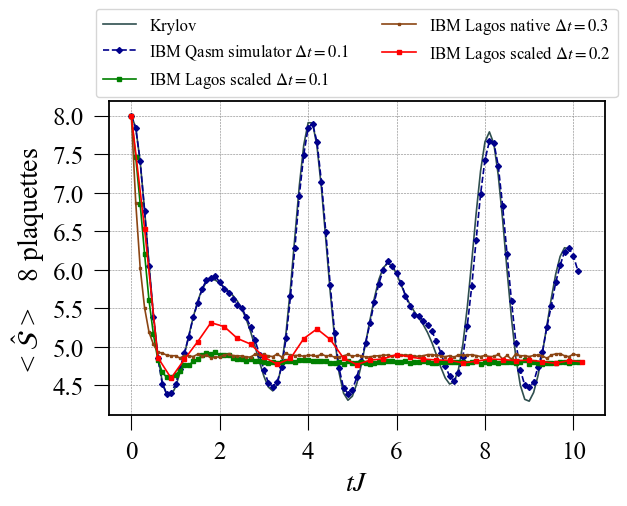

<Figure size 640x480 with 0 Axes>

In [273]:
#czzlists8sim,czzlist811sim,czzlist812sim,czzlist813sim,czzlist814sim,czzlist815sim, tlist8sim = run_czz()
#czzlists8siml1,czzlist811siml1,czzlist812siml1,czzlist813siml1,czzlist814siml1,czzlist815siml1, tlist8siml1 = run_czz()
#czzlists8siml2,czzlist811siml2,czzlist812siml2,czzlist813siml2,czzlist814siml2,czzlist815siml2, tlist8siml2 = run_czz()
#czzlists8n3,czzlist811n3,czzlist812n3,czzlist813n3,czzlist814n3,czzlist815n3, tlist8n3 = run_czz()

#czzlists4n3,czzlist411n3,czzlist412n3, tlist4n3 = run_czz()
#czzlists4c1,czzlist411c1,czzlist412c1, tlist4c1 = run_czz()

#figure_styling()
fig, ax = plt.subplots()
#fig.set_size_inches(6, 4)
#fig.tight_layout()
#ax.plot(tlist8, k8,label='ED',color='darkslategray')  here
#ax.plot(tlist8sim, klist411,label='ED < $\hat{\mathcal{C}}_{11}$ > ',color='grey')
#ax.plot(tlist8sim, czzlists8sim,label='IBM Qasm simulator',color='darkblue',marker='D',markersize=3,linestyle='dashed')
#ax.plot(tlist4n1, czzlist411n1,label='IBM Lagos native < $\hat{\mathcal{C}}_{11}$ >', marker='s', color='green',markersize=2)
#ax.plot(tlist4c1, czzlists8siml1,label='IBM Lagos scaled ', marker='o',color='magenta', markersize=3)

#ax.plot(tlist8sim, czzlists8sim,label='sim ',color='darkgrey') here
#ax.plot(tlist8siml1, czzlists8siml1,label='siml1 ',color='magenta') here
#ax.plot(tlist4, czzlists4l,label=' IBM cal',color='red', marker='s', markersize=3)

ax.plot(tlist8, k8,label='Krylov',color='darkslategray')
ax.plot(tlist8sim, czzlists8sim,label='IBM Qasm simulator $\Delta t = 0.1$',color='darkblue',marker='D',markersize=3,linestyle='dashed')
ax.plot(tlist8siml1, czzlists8siml1,label='IBM Lagos scaled $\Delta t = 0.1$', marker='s', color='green',markersize=3)
ax.plot(tlist8n3, czzlists8n3,label='IBM Lagos native $\Delta t = 0.3$', marker='s',color='saddlebrown', markersize=2)
ax.plot(tlist8siml2, czzlists8siml2,label='IBM Lagos scaled $\Delta t = 0.2$', marker='s', color='red',markersize=3)
#ax.plot(ktlist4, klist412,label='IBM Qasm simulator < $\hat{\mathcal{C}}_{12}$ >',color='dodgerblue',marker='D',markersize=3,linestyle='dashed')


#ax.plot(tlist4n1, czzlist412n1,label='IBM Lagos native < $\hat{\mathcal{C}}_{12}$ >', marker='s', color='mediumseagreen',markersize=2)
#ax.plot(tlist4n3, czzlists4n3,label='IBM Lagos native $\Delta t = 0.3$', marker='s',color='green', markersize=3)


#ax.plot(tlist4c1, czzlist412c1,label='IBM Lagos scaled < $\hat{\mathcal{C}}_{12}$ >', marker='o',color='red', markersize=3)
#ax.plot(tlists2, czzlists4s2,label=' IBM ideal 2', marker='o',color='cornflowerblue', markersize=3)
#ax.plot(tlists3, czzlists4s3,label=' IBM ideal 3',color='navy', marker='o', markersize=3)
#ax.plot(tlist2, czzlist212,label='< $\hat{\mathcal{C}}_{12}$ > IBM qasm simulator',color='royalblue', marker='o', markersize=4)
#ax.plot(tlist2, czzlist211l,label='< $\hat{\mathcal{C}}_{11}$ > IBM Lagos',color='firebrick', marker='s', markersize=4)
#ax.plot(tlist2, czzlist212l,label='< $\hat{\mathcal{C}}_{12}$ > IBM Lagos',color='indianred', marker='s', markersize=4)


#ax.plot(tlist2, czzlist211,label='h11',color='magenta',marker='o')

#ax.plot(tlist2, czzlist212,label='h12',color='red',marker='o')
#ax.plot(tlist6, czz_list6_14,label='s614',color='darkgreen')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

    # plt.rcParams["font.family"] = "Times New Roman"
    # plt.rcParams["font.family"] = "serif"
    # plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
rc = {"font.family": "serif", "mathtext.fontset": "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

legend = ax.legend()
plt.xlabel('$tJ$',fontsize=20)
plt.ylabel('< $\hat{\mathcal{S}}$ >    8 plaquettes',fontsize=20)
#plt.ylabel('< $\hat{\mathcal{C}}_{ij}$ > (4 plaquettes)',fontsize=16)
#plt.title('2 plaquette')
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.4)
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width, pos.height * 0.85])
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.32),
    ncol=2, fontsize=12
)
#plt.legend(bbox_to_anchor=(0.06,1),fontsize=12,ncol=2)
#plt.legend(fontsize=8)
#plt.style.use("cyberpunk")
#mplcyberpunk.add_glow_effects()
plt.figure()
plt.savefig('4_plaq_corr.pdf')
plt.savefig('4_plaq_corr.png')
plt.show()



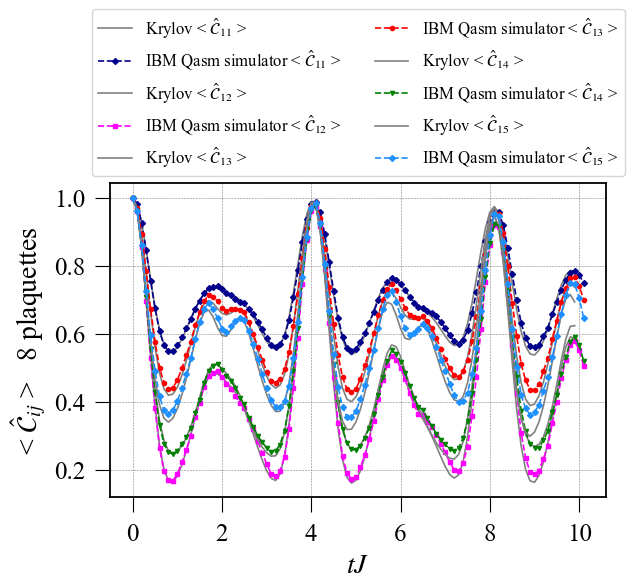

<Figure size 640x480 with 0 Axes>

In [262]:
#figure_styling()
fig, ax = plt.subplots()
#fig.set_size_inches(6, 4)
#fig.tight_layout()
#ax.plot(ktlist2, klist211,label='< $\hat{\mathcal{C}}_{11}$ > ED',color='darkslategray')
ax.plot(tlist8, k811,label='Krylov < $\hat{\mathcal{C}}_{11}$ > ',color='grey')
ax.plot(tlist8sim, czzlist811sim,label='IBM Qasm simulator < $\hat{\mathcal{C}}_{11}$ >',color='darkblue',marker='D',markersize=3,linestyle='dashed')
#ax.plot(tlist6n,czzlist611n,label='IBM Lagos native < $\hat{\mathcal{C}}_{11}$ >', marker='D', color='darkgreen',markersize=2)
#ax.plot(tlist6c2, czzlist611c2,label='IBM Lagos scaled < $\hat{\mathcal{C}}_{11}$ >', marker='D',color='magenta', markersize=3)

ax.plot(tlist8, k812,label='Krylov < $\hat{\mathcal{C}}_{12}$ > ',color='grey')
ax.plot(tlist8sim, czzlist812sim,label='IBM Qasm simulator < $\hat{\mathcal{C}}_{12}$ >',color='magenta',marker='s',markersize=3,linestyle='dashed')
#ax.plot(tlist6n,czzlist612n,label='IBM Lagos native < $\hat{\mathcal{C}}_{12}$ >', marker='s', color='green',markersize=2)
#ax.plot(tlist6c2, czzlist612c2,label='IBM Lagos scaled < $\hat{\mathcal{C}}_{12}$ >', marker='s',color='red', markersize=3)


ax.plot(tlist8, k813,label='Krylov < $\hat{\mathcal{C}}_{13}$ > ',color='grey')
ax.plot(tlist8sim, czzlist813sim,label='IBM Qasm simulator < $\hat{\mathcal{C}}_{13}$ >',color='red',marker='o',markersize=3,linestyle='dashed')
#ax.plot(tlist6n,czzlist613n,label='IBM Lagos native < $\hat{\mathcal{C}}_{13}$ >', marker='o', color='lightgreen',markersize=2)
#ax.plot(tlist6c2, czzlist613c2,label='IBM Lagos scaled < $\hat{\mathcal{C}}_{13}$ >', marker='o',color='orange', markersize=3)


ax.plot(tlist8, k814,label='Krylov < $\hat{\mathcal{C}}_{14}$ > ',color='grey')
ax.plot(tlist8sim, czzlist814sim,label='IBM Qasm simulator < $\hat{\mathcal{C}}_{14}$ >',color='green',marker='v',markersize=3,linestyle='dashed')
#ax.plot(tlist6n,czzlist614n,label='IBM Lagos native < $\hat{\mathcal{C}}_{14}$ >', marker='v', color='darkolivegreen',markersize=2)
#ax.plot(tlist6c2, czzlist614c2,label='IBM Lagos scaled < $\hat{\mathcal{C}}_{14}$ >', marker='v',color='firebrick', markersize=3)
ax.plot(tlist8, k815,label='Krylov < $\hat{\mathcal{C}}_{15}$ > ',color='grey')
ax.plot(tlist8sim,czzlist815sim,label='IBM Qasm simulator < $\hat{\mathcal{C}}_{15}$ >',color='dodgerblue',marker='D',markersize=3,linestyle='dashed')


#ax.plot(ktlist4, klist412,label='ED < $\hat{\mathcal{C}}_{12}$ > ',color='darkgrey')
#ax.plot(tlist4, czzlists4l,label=' IBM cal',color='red', marker='s', markersize=3)

#ax.plot(ktlist4, klist412,label='IBM Qasm simulator < $\hat{\mathcal{C}}_{12}$ >',color='dodgerblue',marker='D',markersize=3,linestyle='dashed')


##ax.plot(tlist4n1, czzlist412n1,label='IBM Lagos native < $\hat{\mathcal{C}}_{12}$ >', marker='s', color='mediumseagreen',markersize=2)
#ax.plot(tlist4n3, czzlists4n3,label='IBM Lagos native $\Delta t = 0.3$', marker='s',color='green', markersize=3)


#ax.plot(tlist4c1, czzlist412c1,label='IBM Lagos scaled < $\hat{\mathcal{C}}_{12}$ >', marker='o',color='red', markersize=3)
#ax.plot(tlists2, czzlists4s2,label=' IBM ideal 2', marker='o',color='cornflowerblue', markersize=3)
#ax.plot(tlists3, czzlists4s3,label=' IBM ideal 3',color='navy', marker='o', markersize=3)
#ax.plot(tlist2, czzlist212,label='< $\hat{\mathcal{C}}_{12}$ > IBM qasm simulator',color='royalblue', marker='o', markersize=4)
#ax.plot(tlist2, czzlist211l,label='< $\hat{\mathcal{C}}_{11}$ > IBM Lagos',color='firebrick', marker='s', markersize=4)
#ax.plot(tlist2, czzlist212l,label='< $\hat{\mathcal{C}}_{12}$ > IBM Lagos',color='indianred', marker='s', markersize=4)


#ax.plot(tlist2, czzlist211,label='h11',color='magenta',marker='o')

#ax.plot(tlist2, czzlist212,label='h12',color='red',marker='o')
#ax.plot(tlist6, czz_list6_14,label='s614',color='darkgreen')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

    # plt.rcParams["font.family"] = "Times New Roman"
    # plt.rcParams["font.family"] = "serif"
    # plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
rc = {"font.family": "serif", "mathtext.fontset": "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

legend = ax.legend()
plt.xlabel('$tJ$',fontsize=20)
plt.ylabel('< $\hat{\mathcal{C}}_{ij}$ >   8 plaquettes',fontsize=20)
#plt.ylabel('< $\hat{\mathcal{C}}_{ij}$ > (4 plaquettes)',fontsize=16)
#plt.title('2 plaquette')
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.4)
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width, pos.height * 0.85])
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.58),
    ncol=2, fontsize=12
)
#plt.legend(bbox_to_anchor=(0.06,1),fontsize=12,ncol=2)
#plt.legend(fontsize=8)
#plt.style.use("cyberpunk")
#mplcyberpunk.add_glow_effects()
plt.figure()
plt.savefig('8_plaq_corr.pdf')
plt.savefig('8_plaq_corr.png')
plt.show()


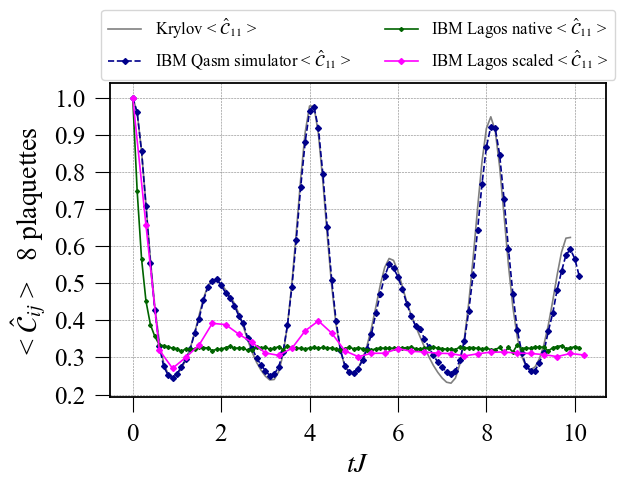

<Figure size 640x480 with 0 Axes>

In [281]:
#figure_styling()
#czzlists8sim,czzlist811sim,czzlist812sim,czzlist813sim,czzlist814sim,czzlist815sim, tlist8sim = run_czz()
#czzlists8siml1,czzlist811siml1,czzlist812siml1,czzlist813siml1,czzlist814siml1,czzlist815siml1, tlist8siml1 = run_czz()
#czzlists8siml2,czzlist811siml2,czzlist812siml2,czzlist813siml2,czzlist814siml2,czzlist815siml2, tlist8siml2 = run_czz()
#czzlists8n3,czzlist811n3,czzlist812n3,czzlist813n3,czzlist814n3,czzlist815n3, tlist8n3 = run_czz()
fig, ax = plt.subplots()
#fig.set_size_inches(6, 4)
#fig.tight_layout()
#ax.plot(ktlist2, klist211,label='< $\hat{\mathcal{C}}_{11}$ > ED',color='darkslategray')
#ax.plot(tlist6, k611,label='Krylov < $\hat{\mathcal{C}}_{11}$ > ',color='grey')
#ax.plot(tlist6, k611,label='IBM Qasm simulator < $\hat{\mathcal{C}}_{11}$ >',color='darkblue',marker='D',markersize=3,linestyle='dashed')
#ax.plot(tlist6n,czzlist611n,label='IBM Lagos native < $\hat{\mathcal{C}}_{11}$ >', marker='D', color='darkgreen',markersize=2)
#ax.plot(tlist6c2, czzlist611c2,label='IBM Lagos scaled < $\hat{\mathcal{C}}_{11}$ >', marker='D',color='magenta', markersize=3)
########################
ax.plot(tlist8, k814,label='Krylov < $\hat{\mathcal{C}}_{11}$ > ',color='grey')
ax.plot(tlist8sim, czzlist814sim,label='IBM Qasm simulator < $\hat{\mathcal{C}}_{11}$ >',color='darkblue',marker='D',markersize=3,linestyle='dashed')
ax.plot(tlist8n3,czzlist814n3,label='IBM Lagos native < $\hat{\mathcal{C}}_{11}$ >', marker='D', color='darkgreen',markersize=2)
ax.plot(tlist8siml2, czzlist814siml2,label='IBM Lagos scaled < $\hat{\mathcal{C}}_{11}$ >', marker='D',color='magenta', markersize=3)
###########################
#ax.plot(tlist6, k612,label='Krylov < $\hat{\mathcal{C}}_{12}$ > ',color='grey')
#ax.plot(tlist6, k612,label='IBM Qasm simulator < $\hat{\mathcal{C}}_{12}$ >',color='dodgerblue',marker='s',markersize=3,linestyle='dashed')
#ax.plot(tlist6n,czzlist612n,label='IBM Lagos native < $\hat{\mathcal{C}}_{12}$ >', marker='s', color='green',markersize=2)
#ax.plot(tlist6c2, czzlist612c2,label='IBM Lagos scaled < $\hat{\mathcal{C}}_{12}$ >', marker='s',color='red', markersize=3)
######################
#ax.plot(tlist8, k812,label='Krylov < $\hat{\mathcal{C}}_{12}$ > ',color='grey')
#ax.plot(tlist8sim, czzlist812sim,label='IBM Qasm simulator < $\hat{\mathcal{C}}_{12}$ >',color='dodgerblue',marker='s',markersize=3,linestyle='dashed')
#ax.plot(tlist8n3,czzlist812n3,label='IBM Lagos native < $\hat{\mathcal{C}}_{12}$ >', marker='s', color='green',markersize=2)
#ax.plot(tlist8siml2, czzlist812siml2,label='IBM Lagos scaled < $\hat{\mathcal{C}}_{12}$ >', marker='s',color='red', markersize=3)
#################

#ax.plot(tlist6, k613,label='Krylov < $\hat{\mathcal{C}}_{13}$ > ',color='grey')
#ax.plot(tlist6, k613,label='IBM Qasm simulator < $\hat{\mathcal{C}}_{13}$ >',color='navy',marker='o',markersize=3,linestyle='dashed')
#ax.plot(tlist6n,czzlist613n,label='IBM Lagos native < $\hat{\mathcal{C}}_{13}$ >', marker='o', color='lightgreen',markersize=2)
#ax.plot(tlist6c2, czzlist613c2,label='IBM Lagos scaled < $\hat{\mathcal{C}}_{13}$ >', marker='o',color='orange', markersize=3)
####################################################
#ax.plot(tlist8, k813,label='Krylov < $\hat{\mathcal{C}}_{13}$ > ',color='grey')
#ax.plot(tlist8sim, czzlist813sim,label='IBM Qasm simulator < $\hat{\mathcal{C}}_{13}$ >',color='navy',marker='o',markersize=3,linestyle='dashed')
#ax.plot(tlist8n3,czzlist813n3,label='IBM Lagos native < $\hat{\mathcal{C}}_{13}$ >', marker='o', color='lightgreen',markersize=2)
#ax.plot(tlist8siml2, czzlist813siml2,label='IBM Lagos scaled < $\hat{\mathcal{C}}_{13}$ >', marker='o',color='orange', markersize=3)



##########################################################################################################
#ax.plot(tlist8, k814,label='Krylov < $\hat{\mathcal{C}}_{14}$ > ',color='grey')
#ax.plot(tlist8sim, czzlist814sim,label='IBM Qasm simulator < $\hat{\mathcal{C}}_{14}$ >',color='blue',marker='D',markersize=3,linestyle='dashed')
#ax.plot(tlist8n3,czzlist814n3,label='IBM Lagos native < $\hat{\mathcal{C}}_{14}$ >', marker='D', color='darkolivegreen',markersize=2)
#ax.plot(tlist8siml2, czzlist814siml2,label='IBM Lagos scaled < $\hat{\mathcal{C}}_{14}$ >', marker='D',color='firebrick', markersize=3)


#ax.plot(ktlist4, klist412,label='ED < $\hat{\mathcal{C}}_{12}$ > ',color='darkgrey')
#ax.plot(tlist4, czzlists4l,label=' IBM cal',color='red', marker='s', markersize=3)
##############################################
#ax.plot(tlist8, k815,label='Krylov < $\hat{\mathcal{C}}_{15}$ > ',color='grey')
#ax.plot(tlist8sim, czzlist815sim,label='IBM Qasm simulator < $\hat{\mathcal{C}}_{15}$ >',color='mediumblue',marker='D',markersize=3,linestyle='dashed')
#ax.plot(tlist8n3,czzlist815n3,label='IBM Lagos native < $\hat{\mathcal{C}}_{15}$ >', marker='D', color='forestgreen',markersize=2)
#ax.plot(tlist8siml2, czzlist815siml2,label='IBM Lagos scaled < $\hat{\mathcal{C}}_{15}$ >', marker='D',color='crimson', markersize=3)

#ax.plot(ktlist4, klist412,label='IBM Qasm simulator < $\hat{\mathcal{C}}_{12}$ >',color='dodgerblue',marker='D',markersize=3,linestyle='dashed')


##ax.plot(tlist4n1, czzlist412n1,label='IBM Lagos native < $\hat{\mathcal{C}}_{12}$ >', marker='s', color='mediumseagreen',markersize=2)
#ax.plot(tlist4n3, czzlists4n3,label='IBM Lagos native $\Delta t = 0.3$', marker='s',color='green', markersize=3)


#ax.plot(tlist4c1, czzlist412c1,label='IBM Lagos scaled < $\hat{\mathcal{C}}_{12}$ >', marker='o',color='red', markersize=3)
#ax.plot(tlists2, czzlists4s2,label=' IBM ideal 2', marker='o',color='cornflowerblue', markersize=3)
#ax.plot(tlists3, czzlists4s3,label=' IBM ideal 3',color='navy', marker='o', markersize=3)
#ax.plot(tlist2, czzlist212,label='< $\hat{\mathcal{C}}_{12}$ > IBM qasm simulator',color='royalblue', marker='o', markersize=4)
#ax.plot(tlist2, czzlist211l,label='< $\hat{\mathcal{C}}_{11}$ > IBM Lagos',color='firebrick', marker='s', markersize=4)
#ax.plot(tlist2, czzlist212l,label='< $\hat{\mathcal{C}}_{12}$ > IBM Lagos',color='indianred', marker='s', markersize=4)


#ax.plot(tlist2, czzlist211,label='h11',color='magenta',marker='o')

#ax.plot(tlist2, czzlist212,label='h12',color='red',marker='o')
#ax.plot(tlist6, czz_list6_14,label='s614',color='darkgreen')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

    # plt.rcParams["font.family"] = "Times New Roman"
    # plt.rcParams["font.family"] = "serif"
    # plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
rc = {"font.family": "serif", "mathtext.fontset": "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

legend = ax.legend()
plt.xlabel('$tJ$',fontsize=20)
plt.ylabel('< $\hat{\mathcal{C}}_{ij}$ >   8 plaquettes',fontsize=20)
#plt.ylabel('< $\hat{\mathcal{C}}_{ij}$ > (4 plaquettes)',fontsize=16)
#plt.title('2 plaquette')
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.4)
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width, pos.height * 0.85])
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.26),
    ncol=2, fontsize=12
)
#plt.legend(bbox_to_anchor=(0.06,1),fontsize=12,ncol=2)
#plt.legend(fontsize=8)
#plt.style.use("cyberpunk")
#mplcyberpunk.add_glow_effects()
plt.figure()
plt.savefig('6_plaq_corr12.pdf')
plt.savefig('6_plaq_corr12.png')
plt.show()


In [251]:
k8=[7.999999999999991,
 7.842901414746668,
 7.404939033072174,
 6.775758117347982,
 6.074588404610522,
 5.417858598205454,
 4.8928345084223235,
 4.544722965775526,
 4.378183711555649,
 4.3688664426291375,
 4.4783461625423415,
 4.666599147695709,
 4.898779119924492,
 5.146233979868786,
 5.3843386715543655,
 5.590802556077473,
 5.747021780266383,
 5.84223844614967,
 5.877483383343911,
 5.865609082227558,
 5.825942130849908,
 5.7757600880780435,
 5.7231800349161865,
 5.665260837066597,
 5.591757773638658,
 5.491619440241036,
 5.358417357228118,
 5.192761055055496,
 5.002493563861146,
 4.802767003706785,
 4.617134432094143,
 4.478656776122373,
 4.428552402668682,
 4.510191551692106,
 4.758058946883882,
 5.183766931092377,
 5.763406201165086,
 6.431717705890212,
 7.087919575218842,
 7.614852526783987,
 7.907812049843923,
 7.904137662376427,
 7.602456826787179,
 7.063511985848749,
 6.391889338253537,
 5.70600601067301,
 5.108077425747896,
 4.6643796830941735,
 4.4002892584803535,
 4.307899792979251,
 4.359790048419237,
 4.5220041623353,
 4.76169618870107,
 5.048484580862284,
 5.351814273182505,
 5.638427303802901,
 5.873680406854133,
 6.027879552676338,
 6.08515990656876,
 6.049888137585929,
 5.946043020727816,
 5.808652599400017,
 5.670947470479885,
 5.553353453714243,
 5.459147764939131,
 5.377617347247307,
 5.291778196267832,
 5.186511318159747,
 5.054456218721398,
 4.8993104916782455,
 4.737320729301757,
 4.59723210437286,
 4.517872739738158,
 4.542249439075875,
 4.707963126515786,
 5.035344878977256,
 5.516166181664722,
 6.106645581876871,
 6.728498393348415,
 7.280479502415401,
 7.659801826009758,
 7.788469721721057,
 7.635927178838734,
 7.229083862122442,
 6.644991521624185,
 5.988631905407075,
 5.364641796446685,
 4.853752278128129,
 4.501352352608325,
 4.319200080061156,
 4.295639290926508,
 4.407409872800401,
 4.627544851159422,
 4.927344099381643,
 5.274003503474042,
 5.627754955578348,
 5.942645007995877,
 6.17319927756496,
 6.2857523255906536,
 6.269734739993879]

k811=[0.9999999999999989,
 0.9803626768433333,
 0.9256173791340224,
 0.8469697646684979,
 0.7593235505763148,
 0.6772323247756816,
 0.6116043135527905,
 0.5680903707219408,
 0.547272963944456,
 0.5461083053286424,
 0.5597932703177928,
 0.5833248934619637,
 0.6123473899905614,
 0.6432792474835984,
 0.6730423339442955,
 0.6988503195096843,
 0.7183777225332976,
 0.7302798057687088,
 0.7346854229179881,
 0.7332011352784447,
 0.7282427663562377,
 0.7219700110097557,
 0.7153975043645233,
 0.7081576046333247,
 0.6989697217048326,
 0.6864524300301302,
 0.6698021696535152,
 0.6490951318819375,
 0.6253116954826435,
 0.6003458754633484,
 0.5771418040117675,
 0.5598320970152966,
 0.5535690503335849,
 0.5637739439615127,
 0.5947573683604847,
 0.6479708663865464,
 0.7204257751456355,
 0.8039647132362759,
 0.8859899469023546,
 0.9518565658479983,
 0.9884765062304907,
 0.9880172077970522,
 0.9503071033483973,
 0.8829389982310936,
 0.7989861672816917,
 0.7132507513341267,
 0.6385096782184871,
 0.5830474603867722,
 0.5500361573100447,
 0.5384874741224067,
 0.5449737560524042,
 0.5652505202919118,
 0.5952120235876329,
 0.6310605726077851,
 0.6689767841478128,
 0.7048034129753622,
 0.7342100508567662,
 0.7534849440845415,
 0.7606449883210947,
 0.7562360171982409,
 0.7432553775909772,
 0.7260815749250025,
 0.7088684338099858,
 0.6941691817142807,
 0.6823934706173918,
 0.6722021684059143,
 0.6614722745334796,
 0.6483139147699694,
 0.6318070273401759,
 0.6124138114597811,
 0.5921650911627196,
 0.5746540130466069,
 0.564734092467269,
 0.5677811798844836,
 0.5884953908144727,
 0.629418109872156,
 0.6895207727080899,
 0.7633306977346087,
 0.8410622991685519,
 0.9100599378019252,
 0.9574752282512192,
 0.9735587152151326,
 0.954490897354841,
 0.9036354827653051,
 0.8306239402030238,
 0.7485789881758849,
 0.6705802245558365,
 0.6067190347660172,
 0.5626690440760411,
 0.539900010007645,
 0.5369549113658134,
 0.5509262341000494,
 0.5784431063949267,
 0.6159180124227043,
 0.6592504379342544,
 0.703469369447293,
 0.7428306259994845,
 0.7716499096956206,
 0.7857190406988325,
 0.7837168424992353]

k812= [0.9999999999999989,
 0.9608227222546742,
 0.8526728719523201,
 0.7003108661429595,
 0.5353503615985238,
 0.38651165642930535,
 0.2726276198572548,
 0.2004627939863889,
 0.16692745476862428,
 0.1636271468692755,
 0.18140041425845105,
 0.21319193716742219,
 0.25465231276385797,
 0.30285771548920204,
 0.3543223068237388,
 0.40378677522544726,
 0.44480656531555696,
 0.47197325943083485,
 0.48334771148560024,
 0.48132139544358127,
 0.4710914640324135,
 0.45762307426864085,
 0.44308826676724694,
 0.426403574692549,
 0.4049217057694753,
 0.37683034364774515,
 0.34253915142515673,
 0.3043882324293785,
 0.26540789708907603,
 0.22846254665902566,
 0.19657249361078852,
 0.17411781486374248,
 0.167862497684453,
 0.18671832324900453,
 0.23972107414217114,
 0.3324478838734154,
 0.46286961516102765,
 0.6183040227447897,
 0.7753948878831924,
 0.9043758643312775,
 0.9771093063590135,
 0.9762084362487684,
 0.9013311723431396,
 0.7695700089033636,
 0.6095724702587396,
 0.452076185924073,
 0.3210815646539193,
 0.22908463118343442,
 0.17737413774195465,
 0.15996393617573812,
 0.1685558353771409,
 0.19622556239929578,
 0.23867356861023953,
 0.2931450112894441,
 0.3560978623485462,
 0.4212199290592272,
 0.4792705219617003,
 0.5202976475396819,
 0.5373249383453916,
 0.5294490444878264,
 0.5023527293904707,
 0.46569907509916814,
 0.4288196338332515,
 0.39714625969785455,
 0.3711999386110123,
 0.34816949461952734,
 0.32457122395436794,
 0.29825179246267414,
 0.2690052528168103,
 0.23829510056064943,
 0.20900889993536925,
 0.18567424934606308,
 0.17477335004935968,
 0.18442542342563736,
 0.2229427676692005,
 0.2962944814622794,
 0.4050050293260964,
 0.5414205042786518,
 0.688611362815654,
 0.8221923285385486,
 0.9155833706824879,
 0.9476371856363854,
 0.9098601593983605,
 0.8099000669040571,
 0.6693278920146969,
 0.5164736570617992,
 0.377557003961905,
 0.2700094210150958,
 0.2003789551479399,
 0.16663888365059948,
 0.16271744550270362,
 0.182598938046104,
 0.22225019557028408,
 0.27904885469204244,
 0.34957598529851747,
 0.42728692833031834,
 0.5016450788107483,
 0.5597239905538589,
 0.5900624704593606,
 0.587127834898698]
k813=[0.9999999999999989,
 0.9706894769621265,
 0.8905490193104815,
 0.779682860070148,
 0.6625942575963794,
 0.5599493575874681,
 0.4838260622837333,
 0.43754982980536133,
 0.41856309905376593,
 0.4218789038658133,
 0.4424775002429757,
 0.4762402550099311,
 0.5196741962807832,
 0.5688461037724106,
 0.6182127338001763,
 0.6604403549878121,
 0.6881356995021624,
 0.6971576767419928,
 0.689525832219668,
 0.6734435302929913,
 0.6595355818744598,
 0.6551620037552759,
 0.6603954544487152,
 0.6683366200882036,
 0.6694550433213701,
 0.6569357952379145,
 0.6296847829942455,
 0.5917402725458412,
 0.5494422326474621,
 0.5087754157496225,
 0.4743840325997077,
 0.4500950320173027,
 0.4398642059969217,
 0.448233848121582,
 0.4799306070647541,
 0.5384583432351159,
 0.623649180463888,
 0.728756205742641,
 0.8387523556912325,
 0.9319556508674406,
 0.9858337201467956,
 0.985156096942913,
 0.9284627899478973,
 0.8290978692217179,
 0.7100177868772356,
 0.5952181911737996,
 0.5023056083812041,
 0.43941645407570773,
 0.40664723101018774,
 0.3997670781493737,
 0.41363053761233326,
 0.44392884903717605,
 0.48727294732072296,
 0.5402050679019393,
 0.59782697777579,
 0.6529006983257221,
 0.6964566140204765,
 0.7204465905025859,
 0.7215429778853645,
 0.703731967830914,
 0.6773841422739053,
 0.6545389165125712,
 0.6429019099899332,
 0.6422736823971357,
 0.6456159521155741,
 0.6437910728056707,
 0.6306754311794649,
 0.6055937057631788,
 0.5723782088526472,
 0.5367110914865925,
 0.5039779140548188,
 0.4786621221161581,
 0.464792766500956,
 0.4664154872081151,
 0.48749739076315407,
 0.5312036254357296,
 0.598543237425583,
 0.6863731849250154,
 0.7853294546377902,
 0.8792264018046544,
 0.947669839994032,
 0.972150788483192,
 0.9433387145917403,
 0.8656657608242835,
 0.7562579771343866,
 0.638497433568657,
 0.5337067732411004,
 0.4552661761492254,
 0.4074495799391087,
 0.3881535761188069,
 0.39281334068764184,
 0.41710824835715016,
 0.45765461313181777,
 0.5112194746122936,
 0.5733725003012039,
 0.6373668772210028,
 0.6940223880794083,
 0.7333445128382206,
 0.7479148872970774,
 0.7366696344942621]
k814=[0.9999999999999989,
 0.9610155228758057,
 0.8554366416328774,
 0.7119657162317549,
 0.5639099606954119,
 0.43696003584116033,
 0.34361097794428863,
 0.28483279209883733,
 0.25515187387949595,
 0.2470767222582055,
 0.2535907349754505,
 0.2696433609653825,
 0.2932109620966002,
 0.32498223017629574,
 0.36575936385812896,
 0.41283612150012206,
 0.45851854062746017,
 0.4929178748412455,
 0.5094776538751788,
 0.5088079846675978,
 0.4974138923061076,
 0.4822551928818671,
 0.46577300067493466,
 0.4455049478637517,
 0.4181421823468377,
 0.38393462261878464,
 0.34741350293210055,
 0.31418082588276297,
 0.28718511088146265,
 0.2660135729732466,
 0.24954992081182995,
 0.2392815614400799,
 0.2404574629251819,
 0.2607055257416921,
 0.30767799721418,
 0.3868677650980767,
 0.49909103059924104,
 0.6369781713468524,
 0.7819970705542552,
 0.9056471357495892,
 0.9772908932727893,
 0.976395586741192,
 0.9024579390452029,
 0.7760075847609356,
 0.6295348750128174,
 0.4938564189177373,
 0.38794676812950335,
 0.31685975008179046,
 0.27633208652389574,
 0.2590793560757923,
 0.258835222533752,
 0.2716177148733806,
 0.295743631847581,
 0.3313842857491678,
 0.37897097854772355,
 0.43611939443705794,
 0.4949031544067084,
 0.5425252058881097,
 0.5664775101058839,
 0.5613062272327105,
 0.5319060599646287,
 0.4904465227849633,
 0.4490502283490881,
 0.41372927224151096,
 0.3837242549494283,
 0.3556034100200131,
 0.32774830360732865,
 0.30144248950255453,
 0.27866967512059687,
 0.25987046671910774,
 0.24438792735569445,
 0.2331301789287262,
 0.23062073166311653,
 0.244354988980616,
 0.28203524919349393,
 0.3487786201935056,
 0.4453861631121099,
 0.5669268605419615,
 0.700882681431449,
 0.8262428537713666,
 0.9165491303713451,
 0.9482035724900294,
 0.9108996313791449,
 0.8137747415617506,
 0.682457079572543,
 0.5480722956995366,
 0.4348321296974952,
 0.35340806381534107,
 0.3025754485797119,
 0.2758047789148868,
 0.26728527427860865,
 0.2742486207124486,
 0.2962625292889721,
 0.3337057399513221,
 0.3863601944191632,
 0.4515285114700572,
 0.5216652517154358,
 0.5835102548100453,
 0.6211988454502834,
 0.6231618892471349]

k815=[0.9999999999999989,
 0.9611124661264742,
 0.8568509730477539,
 0.7181232802038479,
 0.5797785605753513,
 0.4671813267274651,
 0.3910154003853804,
 0.3504312331722117,
 0.3393540897337103,
 0.3509690308938989,
 0.3792806798690969,
 0.41948470983434716,
 0.4682755906186613,
 0.5231845361208668,
 0.5800867193466525,
 0.6306286844652539,
 0.6631954082918753,
 0.6689133180460267,
 0.6491098026861699,
 0.617604201180802,
 0.5941165185627727,
 0.5922785981818901,
 0.6108933605982314,
 0.6351473949394565,
 0.6467405275595192,
 0.6350662668211781,
 0.6015350033055966,
 0.5554648036704766,
 0.5066326988239039,
 0.46087048204061243,
 0.4208474759569494,
 0.3892757935876835,
 0.3707677583483102,
 0.37133615206104,
 0.3971259417335522,
 0.45347237703446447,
 0.5431094135003995,
 0.662034725169661,
 0.7945965123153974,
 0.9127289033186012,
 0.9834054710139588,
 0.9825374166145096,
 0.9073578256601116,
 0.7787795431614358,
 0.6316422025512911,
 0.4991527657381538,
 0.4012306377429882,
 0.34241311215966863,
 0.3175170536897805,
 0.3188456988422987,
 0.34017381569279304,
 0.37718942010707024,
 0.42667698722546343,
 0.48577108635188226,
 0.5506549157013846,
 0.6143577002967311,
 0.6656443664789131,
 0.6919564416335111,
 0.6864873710093942,
 0.6547466023916473,
 0.6143765232446886,
 0.5862874080628173,
 0.582365881236299,
 0.5986161185635065,
 0.6188530074792633,
 0.6258865826625476,
 0.6116175638059673,
 0.5792702371111665,
 0.53804718280961,
 0.4962050615512411,
 0.45821492001413305,
 0.42664838344614936,
 0.4051642821203492,
 0.399221499226587,
 0.41453596106351154,
 0.455484081698223,
 0.5243954723237092,
 0.6201956704278588,
 0.7349705958041556,
 0.8503802998832272,
 0.938723242451493,
 0.9716601498037158,
 0.9334651742853514,
 0.8304900244138819,
 0.6896722483818676,
 0.5462925317504177,
 0.4288260389900149,
 0.3502095136873069,
 0.30921889837163263,
 0.29815342487132057,
 0.3099187531865521,
 0.3404610296553643,
 0.38743361755902045,
 0.44815470989011424,
 0.5183897972822727,
 0.5913807609438405,
 0.6568506984783256,
 0.7017293198293175,
 0.7146382795571282,
 0.6930081857963379]

k816=[0.9999999999999989,
 0.9610155228758057,
 0.8554366416328772,
 0.7119657162317549,
 0.5639099606954119,
 0.43696003584116033,
 0.34361097794428874,
 0.28483279209883733,
 0.25515187387949595,
 0.2470767222582055,
 0.2535907349754505,
 0.2696433609653825,
 0.29321096209660025,
 0.3249822301762958,
 0.36575936385812885,
 0.41283612150012206,
 0.45851854062746017,
 0.49291787484124555,
 0.5094776538751788,
 0.5088079846675978,
 0.49741389230610755,
 0.4822551928818671,
 0.46577300067493443,
 0.4455049478637515,
 0.4181421823468376,
 0.3839346226187846,
 0.34741350293210066,
 0.3141808258827632,
 0.28718511088146287,
 0.2660135729732467,
 0.2495499208118299,
 0.23928156144007967,
 0.24045746292518155,
 0.2607055257416918,
 0.30767799721417977,
 0.3868677650980766,
 0.49909103059924115,
 0.6369781713468528,
 0.7819970705542554,
 0.9056471357495894,
 0.9772908932727893,
 0.976395586741192,
 0.9024579390452029,
 0.7760075847609355,
 0.6295348750128175,
 0.4938564189177375,
 0.3879467681295037,
 0.31685975008179085,
 0.2763320865238962,
 0.2590793560757925,
 0.258835222533752,
 0.27161771487338043,
 0.2957436318475808,
 0.3313842857491675,
 0.3789709785477233,
 0.43611939443705783,
 0.4949031544067085,
 0.5425252058881099,
 0.566477510105884,
 0.5613062272327106,
 0.5319060599646285,
 0.490446522784963,
 0.4490502283490876,
 0.4137292722415106,
 0.3837242549494281,
 0.35560341002001306,
 0.32774830360732893,
 0.3014424895025549,
 0.2786696751205973,
 0.2598704667191079,
 0.2443879273556943,
 0.2331301789287258,
 0.23062073166311595,
 0.24435498898061536,
 0.2820352491934935,
 0.34877862019350536,
 0.44538616311210993,
 0.5669268605419621,
 0.7008826814314495,
 0.826242853771367,
 0.9165491303713452,
 0.9482035724900293,
 0.9108996313791448,
 0.8137747415617504,
 0.6824570795725431,
 0.5480722956995372,
 0.4348321296974959,
 0.35340806381534196,
 0.30257544857971264,
 0.27580477891488725,
 0.26728527427860865,
 0.27424862071244827,
 0.2962625292889715,
 0.3337057399513215,
 0.38636019441916275,
 0.4515285114700569,
 0.5216652517154359,
 0.5835102548100455,
 0.6211988454502835,
 0.6231618892471348]
k817=[0.9999999999999989,
 0.9706894769621265,
 0.8905490193104815,
 0.779682860070148,
 0.6625942575963794,
 0.5599493575874681,
 0.48382606228373326,
 0.4375498298053614,
 0.41856309905376593,
 0.4218789038658133,
 0.4424775002429756,
 0.4762402550099311,
 0.5196741962807832,
 0.5688461037724107,
 0.6182127338001763,
 0.6604403549878121,
 0.6881356995021622,
 0.6971576767419927,
 0.689525832219668,
 0.6734435302929913,
 0.6595355818744599,
 0.655162003755276,
 0.6603954544487153,
 0.6683366200882036,
 0.6694550433213701,
 0.6569357952379145,
 0.6296847829942454,
 0.5917402725458409,
 0.5494422326474618,
 0.5087754157496224,
 0.47438403259970774,
 0.45009503201730294,
 0.439864205996922,
 0.44823384812158235,
 0.47993060706475427,
 0.5384583432351159,
 0.623649180463888,
 0.7287562057426408,
 0.8387523556912322,
 0.9319556508674404,
 0.9858337201467957,
 0.9851560969429131,
 0.9284627899478974,
 0.8290978692217181,
 0.7100177868772358,
 0.5952181911737995,
 0.5023056083812039,
 0.4394164540757073,
 0.40664723101018735,
 0.3997670781493735,
 0.41363053761233326,
 0.4439288490371762,
 0.48727294732072324,
 0.5402050679019397,
 0.5978269777757901,
 0.6529006983257221,
 0.6964566140204763,
 0.7204465905025856,
 0.7215429778853643,
 0.7037319678309139,
 0.6773841422739056,
 0.6545389165125718,
 0.6429019099899338,
 0.6422736823971362,
 0.6456159521155745,
 0.6437910728056709,
 0.6306754311794648,
 0.6055937057631785,
 0.5723782088526468,
 0.5367110914865925,
 0.503977914054819,
 0.47866212211615855,
 0.46479276650095663,
 0.4664154872081157,
 0.48749739076315457,
 0.5312036254357297,
 0.5985432374255827,
 0.686373184925015,
 0.7853294546377898,
 0.879226401804654,
 0.9476698399940318,
 0.972150788483192,
 0.9433387145917405,
 0.8656657608242836,
 0.7562579771343865,
 0.6384974335686565,
 0.5337067732410998,
 0.45526617614922454,
 0.40744957993910796,
 0.38815357611880646,
 0.39281334068764173,
 0.41710824835715044,
 0.45765461313181827,
 0.5112194746122941,
 0.5733725003012043,
 0.6373668772210028,
 0.6940223880794084,
 0.7333445128382203,
 0.7479148872970772,
 0.7366696344942623]
k818= [0.9999999999999989,
 0.9608227222546742,
 0.8526728719523201,
 0.7003108661429595,
 0.5353503615985237,
 0.38651165642930535,
 0.2726276198572548,
 0.2004627939863889,
 0.1669274547686243,
 0.1636271468692755,
 0.18140041425845105,
 0.21319193716742219,
 0.25465231276385797,
 0.30285771548920204,
 0.3543223068237387,
 0.40378677522544726,
 0.444806565315557,
 0.4719732594308349,
 0.4833477114856003,
 0.4813213954435813,
 0.4710914640324134,
 0.45762307426864085,
 0.44308826676724683,
 0.4264035746925489,
 0.40492170576947517,
 0.3768303436477452,
 0.3425391514251569,
 0.30438823242937874,
 0.26540789708907625,
 0.22846254665902582,
 0.19657249361078852,
 0.1741178148637423,
 0.16786249768445274,
 0.18671832324900423,
 0.23972107414217092,
 0.3324478838734153,
 0.4628696151610277,
 0.6183040227447899,
 0.7753948878831927,
 0.9043758643312776,
 0.9771093063590135,
 0.9762084362487684,
 0.9013311723431396,
 0.7695700089033636,
 0.6095724702587396,
 0.45207618592407317,
 0.3210815646539196,
 0.22908463118343475,
 0.17737413774195496,
 0.1599639361757383,
 0.16855583537714094,
 0.19622556239929564,
 0.23867356861023928,
 0.2931450112894438,
 0.35609786234854596,
 0.42121992905922717,
 0.47927052196170034,
 0.5202976475396821,
 0.5373249383453917,
 0.5294490444878264,
 0.5023527293904706,
 0.46569907509916786,
 0.42881963383325106,
 0.3971462596978542,
 0.3711999386110121,
 0.34816949461952734,
 0.32457122395436816,
 0.2982517924626745,
 0.2690052528168107,
 0.23829510056064965,
 0.20900889993536922,
 0.18567424934606275,
 0.17477335004935915,
 0.1844254234256368,
 0.22294276766920007,
 0.29629448146227927,
 0.4050050293260966,
 0.5414205042786522,
 0.6886113628156544,
 0.8221923285385491,
 0.9155833706824881,
 0.9476371856363853,
 0.9098601593983604,
 0.809900066904057,
 0.669327892014697,
 0.5164736570617997,
 0.37755700396190567,
 0.2700094210150965,
 0.20037895514794057,
 0.16663888365059987,
 0.16271744550270364,
 0.1825989380461037,
 0.22225019557028355,
 0.2790488546920419,
 0.349575985298517,
 0.4272869283303181,
 0.5016450788107484,
 0.559723990553859,
 0.5900624704593607,
 0.5871278348986979]


In [250]:
tlist8=[0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1,
       5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4,
       6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7,
       7.8, 7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. ,
       9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9]

In [86]:
klist211=[1.0000000000000004,
 0.9999000074997756,
 0.9996001199856017,
 0.9991006073359995,
 0.9984019190786372,
 0.9975046839857878,
 0.9964097095084722,
 0.9951179810498113,
 0.993630661078229,
 0.9919490880813097,
 0.9900747753612462,
 0.9880094096729757,
 0.985754849706208,
 0.9833131244127367,
 0.9806864311805134,
 0.9778771338561508,
 0.9748877606176192,
 0.9717210016990563,
 0.9683797069697391,
 0.9648668833693935,
 0.9611856922021513,
 0.9573394462915898,
 0.9533316069994152,
 0.9491657811104686,
 0.9448457175868661,
 0.940375304194183,
 0.9357585640027289,
 0.9309996517670556,
 0.9261028501869579,
 0.9210725660533342,
 0.9159133262823703,
 0.9106297738416221,
 0.9052266635716576,
 0.8997088579070199,
 0.894081322500367,
 0.8883491217537177,
 0.8825174142608317,
 0.8765914481648244,
 0.8705765564351909,
 0.8644781520684961,
 0.8583017232170389,
 0.85205282824989,
 0.8457370907507313,
 0.8393601944570132,
 0.8329278781449723,
 0.8264459304651208,
 0.8199201847328526,
 0.8133565136788519,
 0.8067608241640327,
 0.8001390518637632,
 0.7934971559261568,
 0.7868411136092429,
 0.7801769149018376,
 0.7735105571329575,
 0.7668480395746291,
 0.7601953580429486,
 0.7535584995022513,
 0.7469434366772498,
 0.7403561226779832,
 0.7338024856424206,
 0.7272884234015367,
 0.7208197981716621,
 0.7144024312788847,
 0.7080420979202486,
 0.7017445219664675,
 0.6955153708108255,
 0.6893602502689079,
 0.6832846995337443,
 0.6772941861909088,
 0.6713941012980624,
 0.6655897545333653,
 0.6598863694171238,
 0.6542890786109753,
 0.6488029192988399,
 0.6434328286537936,
 0.638183639394947,
 0.6330600754383233,
 0.6280667476456534,
 0.6232081496749109,
 0.618488653936324,
 0.6139125076575012,
 0.6094838290612128,
 0.6052066036592685,
 0.6010846806658259,
 0.5971217695333579,
 0.5933214366143953,
 0.5896871019520502,
 0.5862220362022084,
 0.58292935769016,
 0.5798120296043164,
 0.5768728573295422,
 0.5741144859224958,
 0.5715393977312597,
 0.569149910161392,
 0.5669481735904208,
 0.5649361694326469,
 0.5631157083560059,
 0.5614884286525896,
 0.5600557947642925,
 0.5588190959649151,
 0.5577794451999012,
 0.5569377780847655,
 0.556294852063101,
 0.5558512457249305,
 0.555607358286016,
 0.5555634092285908,
 0.55571943810384,
 0.5560753044963074,
 0.5566306881502602,
 0.5573850892578969,
 0.5583378289091414,
 0.5594880497026153,
 0.5608347165172425,
 0.5623766174437866,
 0.5641123648754893,
 0.5660403967568215,
 0.5681589779892279,
 0.5704662019925996,
 0.5729599924210663,
 0.5756381050315682,
 0.5784981297035232,
 0.5815374926077723,
 0.5847534585228525,
 0.5881431332965116,
 0.5917034664502492,
 0.5954312539245424,
 0.5993231409622823,
 0.6033756251278297,
 0.6075850594589698,
 0.611947655748933,
 0.6164594879555249,
 0.6211164957342986,
 0.6259144880925924,
 0.6308491471611382,
 0.635916032079854,
 0.6411105829943174,
 0.6464281251593267,
 0.6518638731458575,
 0.657412935147623,
 0.6630703173833727,
 0.668830928590956,
 0.6746895846091157,
 0.6806410130428833,
 0.6866798580083768,
 0.6928006849527382,
 0.6989979855448601,
 0.7052661826325151,
 0.7115996352614152,
 0.7179926437516895,
 0.7244394548272117,
 0.7309342667931604,
 0.7374712347571534,
 0.7440444758892549,
 0.7506480747161264,
 0.7572760884445535,
 0.7639225523095581,
 0.7705814849422838,
 0.7772468937528269,
 0.7839127803231586,
 0.7905731458052999,
 0.7972219963198777,
 0.8038533483502128,
 0.8104612341270812,
 0.8170397069993023,
 0.8235828467853246,
 0.8300847651009897,
 0.8365396106586795,
 0.8429415745330812,
 0.8492848953888277,
 0.8555638646653096,
 0.8617728317139961,
 0.8679062088836363,
 0.8739584765487678,
 0.8799241880770073,
 0.8857979747306539,
 0.8915745504981875,
 0.8972487168513241,
 0.9028153674233412,
 0.9082694926044612,
 0.913606184050164,
 0.9188206390983638,
 0.9239081650914824,
 0.9288641835995243,
 0.9336842345403529,
 0.9383639801934656,
 0.9428992091036474,
 0.9472858398709982,
 0.9515199248239159,
 0.9555976535717351,
 0.9595153564338218,
 0.9632695077420362,
 0.9668567290135988,
 0.9702737919914957,
 0.9735176215496913,
 0.9765852984605355,
 0.9794740620218702,
 0.9821813125414762,
 0.9847046136766191,
 0.9870416946265954,
 0.989190452176299,
 0.9911489525889705,
 0.9929154333464348,
 0.9944883047352434,
 0.9958661512773117,
 0.9970477330037546,
 0.9980319865707715,
 0.9988180262165878,
 0.9994051445585784,
 0.9997928132298649,
 0.99998068335481,
 0.9999685858629817,
 0.9997565316413062,
 0.9993447115242703,
 0.9987334961221817,
 0.9979234354876467,
 0.9969152586205589,
 0.9957098728120489,
 0.9943083628279831,
 0.9927119899327482,
 0.9909221907541976,
 0.9889405759907846,
 0.9867689289620416,
 0.9844092040037119,
 0.9818635247089819,
 0.9791341820173881,
 0.9762236321531289,
 0.9731344944146244,
 0.9698695488173299,
 0.9664317335919054,
 0.9628241425400081,
 0.9590500222500797,
 0.9551127691756361,
 0.9510159265786866,
 0.9467631813410409,
 0.9423583606463607,
 0.9378054285359546,
 0.9331084823414085,
 0.9282717489972636,
 0.9232995812370594,
 0.9181964536761686,
 0.912966958784946,
 0.9076158027558126,
 0.9021478012680026,
 0.8965678751537761,
 0.8908810459700026,
 0.8850924314790973,
 0.8792072410433831,
 0.8732307709370128,
 0.8671683995796833,
 0.8610255826964175,
 0.8548078484077839,
 0.8485207922549564,
 0.8421700721641101,
 0.8357614033546652,
 0.8293005531959787,
 0.8227933360170989,
 0.8162456078742628,
 0.8096632612808405,
 0.8030522199044706,
 0.7964184332361608,
 0.7897678712361443,
 0.783106518961323,
 0.7764403711791155,
 0.7697754269725745,
 0.7631176843416159,
 0.7564731348052232,
 0.7498477580094852,
 0.743247516346319,
 0.7366783495877183,
 0.730146169540361,
 0.7236568547253796,
 0.7172162450880935,
 0.7108301367424467,
 0.7045042767549015,
 0.6982443579724638,
 0.6920560138995064,
 0.6859448136279938,
 0.679916256825677,
 0.6739757687867627,
 0.6681286955495145,
 0.6623802990851813,
 0.656735752562575,
 0.651200135692571,
 0.6457784301567088,
 0.6404755151240169,
 0.6352961628600886,
 0.6302450344323661,
 0.6253266755154929,
 0.620545512300515,
 0.6159058475116074,
 0.6114118565339117,
 0.6070675836559722,
 0.6028769384301504,
 0.5988436921542888,
 0.5949714744778001,
 0.5912637701352259,
 0.5877239158102125,
 0.5843550971327185,
 0.5811603458121661,
 0.5781425369091042,
 0.5753043862478497,
 0.5726484479724281,
 0.570177112248017,
 0.5678926031099583,
 0.565796976462276,
 0.563892118227503,
 0.5621797426494763,
 0.5606613907506345,
 0.5593384289452005,
 0.558212047809502,
 0.5572832610105327,
 0.5565529043937208,
 0.5560216352307235,
 0.555689931627928,
 0.5555580920961875,
 0.5556262352821815,
 0.5558942998616421,
 0.5563620445945422,
 0.5570290485421934,
 0.5578947114460642,
 0.5589582542679721,
 0.5602187198911639,
 0.5616749739816581,
 0.5633257060090666,
 0.5651694304259869,
 0.5672044880048909,
 0.5694290473313196,
 0.5718411064520326,
 0.5744384946766307,
 0.5772188745310298,
 0.5801797438610312,
 0.5833184380840903,
 0.5866321325872627,
 0.5901178452691621,
 0.5937724392236539,
 0.5975926255628567,
 0.6015749663769199,
 0.6057158778279108,
 0.6100116333750272,
 0.6144583671282308,
 0.6190520773272892,
 0.6237886299430901,
 0.6286637623979863,
 0.6336730874018306,
 0.638812096900238,
 0.6440761661315337,
 0.6494605577887222,
 0.6549604262827489,
 0.6605708221031983,
 0.666286696272523,
 0.6721029048897798,
 0.6780142137597964,
 0.68401530310359,
 0.6901007723458132,
 0.6962651449749058,
 0.7025028734715824,
 0.7088083443012312,
 0.7151758829657121,
 0.7215997591100223,
 0.7280741916792308,
 0.7345933541210372,
 0.7411513796292731,
 0.747742366423635,
 0.7543603830608863,
 0.7609994737727559,
 0.7676536638257287,
 0.7743169648979014,
 0.7809833804680675,
 0.7876469112121846,
 0.7943015604023567,
 0.8009413393034891,
 0.8075602725627411,
 0.8141524035869454,
 0.8207117999031346,
 0.827232558497371,
 0.8337088111270573,
 0.8401347296019606,
 0.84650453102919,
 0.8528124830174098,
 0.8590529088356047,
 0.8652201925217544,
 0.8713087839368199,
 0.8773132037594966,
 0.8832280484172288,
 0.8890479949490653,
 0.8947678057959625,
 0.9003823335142329,
 0.9058865254078996,
 0.9112754280757808,
 0.9165441918692143,
 0.9216880752564176,
 0.9267024490895438,
 0.9315828007706032,
 0.936324738312497,
 0.9409239942915079,
 0.9453764296876961,
 0.9496780376097341,
 0.9538249469008437,
 0.9578134256225694,
 0.9616398844132769,
 0.965300879718332,
 0.9687931168890705,
 0.9721134531477579,
 0.9752589004158758,
 0.9782266280031957,
 0.9810139651552043,
 0.9836184034566047,
 0.9860375990887192,
 0.98826937493877,
 0.9903117225591325,
 0.9921628039748029,
 0.9938209533374509,
 0.9952846784245718,
 0.9965526619823863,
 0.9976237629112784,
 0.998497017292709,
 0.9991716392566778,
 0.9996470216889531,
 0.9999227367774334,
 0.9999985363971483,
 0.9998743523335571,
 0.9995502963439349,
 0.999026660056799,
 0.9983039147094633,
 0.9973827107239572,
 0.9962638771216878,
 0.9949484207773778,
 0.993437525512947,
 0.9917325510321507,
 0.9898350316969395,
 0.9877466751466365,
 0.9854693607611762,
 0.9830051379697925,
 0.9803562244066677,
 0.9775250039152115,
 0.9745140244027648,
 0.9713259955476535,
 0.9679637863606629,
 0.9644304226031175,
 0.9607290840639058,
 0.956863101697878,
 0.9528359546282197,
 0.9486512670154683,
 0.9443128047960175,
 0.9398244722930271,
 0.935190308702797,
 0.9304144844597615,
 0.9255012974833805,
 0.9204551693103029,
 0.9152806411152812,
 0.9099823696244207,
 0.9045651229244405,
 0.8990337761717166,
 0.8933933072049737,
 0.8876487920655597,
 0.8818054004293584,
 0.8758683909544234,
 0.8698431065485477,
 0.8637349695610019,
 0.8575494769027877,
 0.8512921950997884,
 0.8449687552832738,
 0.83858484812226,
 0.8321462187022893,
 0.825658661355247,
 0.8191280144448467,
 0.8125601551125039,
 0.8059609939882999,
 0.7993364698718166,
 0.7926925443876163,
 0.7860351966201835,
 0.7793704177331523,
 0.7727042055776607,
 0.7660425592946933,
 0.7593914739162577,
 0.752756934970259,
 0.7461449130939306,
 0.7395613586606632,
 0.733012196425071,
 0.7265033201911095,
 0.7200405875080549,
 0.713629814399098,
 0.7072767701273257,
 0.7009871720037629,
 0.6947666802421868,
 0.6886208928653111,
 0.6825553406669476,
 0.6765754822346627,
 0.670686699037416,
 0.6648942905826054,
 0.6592034696468626,
 0.6536193575849125,
 0.6481469797206942,
 0.6427912608249107,
 0.6375570206830681,
 0.6324489697579936,
 0.627471704950737,
 0.6226297054636687,
 0.6179273287695024,
 0.6133688066898624,
 0.6089582415869288,
 0.6046996026715901,
 0.60059672243142,
 0.5966532931817,
 0.5928728637425802,
 0.589258836245385,
 0.5858144630709216,
 0.5825428439225597,
 0.5794469230367051,
 0.576529486533186,
 0.5737931599079349,
 0.5712404056702182,
 0.568873521126544,
 0.5666946363132412,
 0.5647057120795724,
 0.5629085383230985,
 0.5613047323788956,
 0.5598957375640594,
 0.5586828218788191,
 0.5576670768654216,
 0.5568494166258189,
 0.5562305769990361,
 0.5558111148989666,
 0.5555914078131878,
 0.5555716534632471,
 0.5557518696267262,
 0.5561318941212415,
 0.5567113849504,
 0.5574898206115688,
 0.5584665005651964,
 0.5596405458652481,
 0.5610108999502,
 0.562576329593871,
 0.5643354260152457,
 0.56628660614628,
 0.5684281140565568,
 0.5707580225335047,
 0.5732742348167578,
 0.5759744864851011,
 0.5788563474942938,
 0.5819172243639487,
 0.5851543625114846,
 0.5885648487310694,
 0.5921456138153074,
 0.5958934353173164,
 0.599804940450715,
 0.6038766091249014,
 0.6081047771128989,
 0.6124856393489111,
 0.6170152533526239,
 0.6216895427771753,
 0.6265043010775871,
 0.6314551952963761,
 0.6365377699629194,
 0.6417474511030825,
 0.6470795503554804,
 0.6525292691906934,
 0.6580917032296141,
 0.6637618466570604,
 0.6695345967266702,
 0.6754047583530312,
 0.681367048786903,
 0.6874161023693368,
 0.6935464753604088,
 0.6997526508382133,
 0.7060290436637269,
 0.7123700055070474,
 0.7187698299305192,
 0.7252227575241377,
 0.7317229810886265,
 0.7382646508615305,
 0.7448418797816022,
 0.7514487487867647,
 0.7580793121408629,
 0.7647276027844272,
 0.7713876377046258,
 0.7780534233195688,
 0.7847189608721294,
 0.7913782518284205,
 0.7980253032760709,
 0.8046541333174395,
 0.8112587764529225,
 0.8178332889494975,
 0.8243717541896838,
 0.8308682879960976,
 0.8373170439268178,
 0.8437122185367836,
 0.8500480566005069,
 0.8563188562913877,
 0.8625189743129695,
 0.8686428309775303,
 0.874684915227417,
 0.8806397895946344,
 0.886502095094195,
 0.892266556046842,
 0.8979279848268074,
 0.9034812865303238,
 0.9089214635606959,
 0.9142436201257966,
 0.9194429666439518,
 0.9245148240542407,
 0.9294546280273348,
 0.9342579330730842,
 0.9389204165411611,
 0.9434378825111535,
 0.9478062655686066,
 0.9520216344636271,
 0.9560801956487379,
 0.959978296692817,
 0.9637124295680384,
 0.9672792338068615,
 0.9706754995262226,
 0.9738981703162155,
 0.9769443459906538,
 0.9798112851970399,
 0.9824964078836019,
 0.9849972976211611,
 0.9873117037777593,
 0.9894375435440736,
 0.9913729038078034,
 0.993116042875345,
 0.9946653920391954,
 0.9960195569896856,
 0.997177319069763,
 0.9981376363717022,
 0.9988996446747516,
 0.9994626582228714,
 0.9998261703418715,
 0.9999898538953808,
 0.9999535615792493,
 0.9997173260541122,
 0.9992813599159963,
 0.998646055504999,
 0.9978119845522092,
 0.9967798976651856,
 0.9955507236524627,
 0.9941255686876855,
 0.9925057153141275,
 0.9906926212904876,
 0.9886879182790068,
 0.9864934103770826,
 0.9841110724937019,
 0.9815430485721564,
 0.9787916496606383,
 0.9758593518324555,
 0.9727487939577282,
 0.9694627753285885,
 0.9660042531400017,
 0.9623763398284947,
 0.9585823002711714,
 0.9546255488475437,
 0.9505096463668186,
 0.9462382968634154,
 0.9418153442635794,
 0.9372447689261088,
 0.9325306840603046,
 0.9276773320243533,
 0.9226890805074964,
 0.9175704185994024,
 0.9123259527502897,
 0.9069604026254303,
 0.9014785968577738,
 0.8958854687025006,
 0.8901860515974245,
 0.8843854746332417,
 0.8784889579376924,
 0.8725018079778009,
 0.8664294127844094,
 0.8602772371033172,
 0.8540508174773783,
 0.8477557572639856,
 0.841397721592428,
 0.8349824322656536,
 0.8285156626110386,
 0.822003232284779,
 0.8154510020345909,
 0.8088648684254379,
 0.8022507585330176,
 0.7956146246097954,
 0.7889624387283745,
 0.7823001874070408,
 0.7756338662222934,
 0.7689694744132362,
 0.7623130094826644,
 0.7556704617997186,
 0.7490478092089532,
 0.7424510116506849,
 0.7358860057974468,
 0.7293586997113803,
 0.7228749675273838,
 0.7164406441667843,
 0.710061520086303,
 0.7037433360670339,
 0.6974917780481287,
 0.6913124720098378,
 0.685210978910505,
 0.679192789682082,
 0.6732633202886572,
 0.6674279068524587,
 0.6616918008517005,
 0.6560601643946069,
 0.6505380655738657,
 0.6451304739056851,
 0.6398422558575658,
 0.6346781704688054,
 0.6296428650676901,
 0.6247408710892065,
 0.6199765999970617,
 0.6153543393136591,
 0.6108782487616218,
 0.6065523565203182,
 0.6023805556007771,
 0.5983666003422385,
 0.5945141030335002,
 0.5908265306621048,
 0.5873072017942828,
 0.5839592835884685,
 0.5807857889450684,
 0.577789573795057,
 0.5749733345298315,
 0.5723396055746397,
 0.5698907571077707,
 0.5676289929275511,
 0.5655563484690794,
 0.5636746889724691,
 0.5619857078042585,
 0.5604909249334962,
 0.5591916855638712,
 0.5580891589231203,
 0.5571843372108014,
 0.5564780347053826,
 0.5559708870314441,
 0.5556633505876616,
 0.555555702136076,
 0.5556480385530277,
 0.5559402767419742,
 0.5564321537082708,
 0.5571232267958486,
 0.5580128740855748,
 0.559100294954938,
 0.5603845107985543,
 0.5618643659088467,
 0.563538528516103,
 0.5654054919869794,
 0.5674635761803684,
 0.5697109289594122,
 0.5721455278583012,
 0.574765181902358,
 0.5775675335797629,
 0.5805500609631601,
 0.5837100799792192,
 0.5870447468241202,
 0.5905510605227864,
 0.5942258656295574,
 0.5980658550678798,
 0.6020675731064496,
 0.6062274184691411,
 0.6105416475759087,
 0.6150063779117576,
 0.6196175915207456,
 0.6243711386218734,
 0.6292627413436038,
 0.6342879975736602,
 0.6394423849206312,
 0.6447212647838148,
 0.6501198865276479,
 0.6556333917569561,
 0.6612568186891844,
 0.6669851066196644,
 0.6728131004759058,
 0.6787355554568155,
 0.684747141752664,
 0.6908424493415564,
 0.6970159928580826,
 0.7032622165297788,
 0.7095754991769497,
 0.7159501592713455,
 0.722380460049158,
 0.7288606146737188,
 0.7353847914432645,
 0.7419471190390698,
 0.7485416918092438,
 0.755162575083413,
 0.7618038105135265,
 0.7684594214359669,
 0.7751234182501454,
 0.7817898038087345,
 0.7884525788146992,
 0.7951057472202587,
 0.8017433216229226,
 0.8083593286537517,
 0.8149478143529842,
 0.8215028495282017,
 0.8280185350901988,
 0.8344890073617627,
 0.8409084433545948,
 0.8472710660095992,
 0.853571149395852,
 0.8598030238635476,
 0.8659610811463032,
 0.8720397794082223,
 0.8780336482311683,
 0.8839372935377738,
 0.8897454024457475,
 0.89545274804911,
 0.9010541941220487,
 0.9065446997411857,
 0.9119193238220631,
 0.9171732295657833,
 0.9223016888118043,
 0.9273000862929663,
 0.9321639237889181,
 0.9368888241742122,
 0.9414705353574224,
 0.945904934107741,
 0.9501880297656051,
 0.9543159678340226,
 0.9582850334473598,
 0.9620916547144694,
 0.9657324059331489,
 0.9692040106730455,
 0.9725033447242197,
 0.9756274389087235,
 0.9785734817526607,
 0.9813388220163234,
 0.9839209710801305,
 0.9863176051842134,
 0.9885265675196467,
 0.9905458701694285,
 0.992373695897474,
 0.9940083997840007,
 0.9954485107058514,
 0.9966927326604003,
 0.9977399459318714,
 0.9985892080990042,
 0.9992397548831724,
 0.999691000836181,
 0.9999425398671306,
 0.9999941456078708,
 0.9998457716167188,
 0.9994975514202518,
 0.9989497983931421,
 0.9982030054761424,
 0.9972578447324707,
 0.9961151667429995,
 0.9947759998407913,
 0.993241549185667,
 0.9915131956796441,
 0.9895924947242174,
 0.9874811748206035,
 0.9851811360142051,
 0.9826944481847011,
 0.9800233491832911,
 0.9771702428187828,
 0.9741376966943244,
 0.9709284398967392,
 0.9675453605405251,
 0.9639915031687516,
 0.960270066013176,
 0.9563843981160488,
 0.9523379963162021,
 0.948134502102132,
 0.9437776983349033,
 0.9392715058438325,
 0.9346199798980015,
 0.9298273065567932,
 0.9248977989027198,
 0.9198358931599374,
 0.9146461447019458,
 0.9093332239520596,
 0.9039019121803432,
 0.8983570972007879,
 0.892703768972612,
 0.8869470151096329,
 0.8810920163017577,
 0.8751440416527122,
 0.8691084439382046,
 0.8629906547887887,
 0.8567961798017594,
 0.8505305935864884,
 0.8441995347476597,
 0.8378087008108921,
 0.8313638430953595,
 0.8248707615379923,
 0.8183352994739224,
 0.8117633383778768,
 0.8051607925712467,
 0.7985336038995998,
 0.7918877363854211,
 0.7852291708608883,
 0.7785638995855348,
 0.7718979208536165,
 0.7652372335960516,
 0.7585878319817883,
 0.7519557000234587,
 0.74534680619217,
 0.7387670980462837,
 0.7322224968790138,
 0.725718892389664,
 0.7192621373832946,
 0.712858042503592,
 0.7065123710036856,
 0.7002308335596058,
 0.6940190831310606,
 0.6878827098741533,
 0.6818272361106261,
 0.6758581113581323,
 0.6699807074260442,
 0.6642003135811887,
 0.6585221317878621,
 0.6529512720264117,
 0.6474927476946006,
 0.6421514710958879,
 0.6369322490186892,
 0.6318397784105849,
 0.626878642151392,
 0.622053304928877,
 0.6173681092208396,
 0.6128272713871751,
 0.6084348778754369,
 0.604194881543308,
 0.6001110981012959,
 0.5961872026788518,
 0.5924267265170013,
 0.5888330537904645,
 0.5854094185621298,
 0.5821589018726143,
 0.5790844289675359,
 0.5761887666649881,
 0.5734745208655906,
 0.570944134207359,
 0.5685998838674886,
 0.5664438795130529,
 0.5644780614024455,
 0.5627041986392771,
 0.561123887580302,
 0.5597385503988057,
 0.5585494338047442,
 0.5575576079227893,
 0.5567639653292882,
 0.556169220249006,
 0.5557739079123709,
 0.555578384073803,
 0.5555828246915594,
 0.5557872257693841,
 0.5561914033601035,
 0.5567949937311676,
 0.5575974536919829,
 0.5585980610827493,
 0.5597959154243544,
 0.5611899387287432,
 0.5627788764690356,
 0.5645612987085152,
 0.5665356013874767,
 0.5687000077667708,
 0.571052570026748,
 0.5735911710201682,
 0.5763135261774882,
 0.5792171855628196,
 0.582299536078706,
 0.585557803817736,
 0.5889890565588716,
 0.592590206406248,
 0.596358012568072,
 0.6002890842731186,
 0.6043798838221914,
 0.6086267297718176,
 0.6130258002472957,
 0.6175731363821272,
 0.6222646458807255,
 0.6270961067012099,
 0.6320631708549553,
 0.6371613683194906,
 0.6423861110612146,
 0.6477326971643205,
 0.6531963150621996,
 0.6587720478675259,
 0.664454877797125,
 0.6702396906876404,
 0.6761212805979362,
 0.6820943544940837,
 0.6881535370127494,
 0.6942933752986494,
 0.7005083439117528,
 0.7067928497998043,
 0.7131412373316974,
 0.7195477933871568,
 0.7260067524981626,
 0.7325123020374791,
 0.7390585874496347,
 0.7456397175196188,
 0.7522497696745805,
 0.758882795313746,
 0.765532825161757,
 0.7721938746406128,
 0.7788599492553903,
 0.7855250499888818,
 0.7921831787003087,
 0.79882834352324,
 0.8054545642578709]

klist212=[1.0000000000000004,
 0.9998000149995506,
 0.9992002399712027,
 0.9982012146719982,
 0.9968038381572741,
 0.995009367971575,
 0.9928194190169436,
 0.9902359620996221,
 0.9872613221564578,
 0.9838981761626187,
 0.980149550722492,
 0.9760188193459506,
 0.9715096994124157,
 0.9666262488254729,
 0.9613728623610263,
 0.9557542677123012,
 0.9497755212352379,
 0.9434420033981121,
 0.9367594139394778,
 0.9297337667387865,
 0.922371384404302,
 0.9146788925831791,
 0.9066632139988297,
 0.8983315622209367,
 0.8896914351737316,
 0.8807506083883654,
 0.8715171280054572,
 0.8619993035341104,
 0.8522057003739152,
 0.8421451321066677,
 0.8318266525647402,
 0.8212595476832439,
 0.8104533271433146,
 0.7994177158140393,
 0.7881626450007335,
 0.7766982435074348,
 0.7650348285216628,
 0.7531828963296481,
 0.7411531128703815,
 0.7289563041369916,
 0.7166034464340774,
 0.7041056564997794,
 0.6914741815014622,
 0.6787203889140259,
 0.6658557562899439,
 0.652891860930241,
 0.6398403694657044,
 0.6267130273577031,
 0.613521648328065,
 0.6002781037275257,
 0.5869943118523129,
 0.5736822272184853,
 0.5603538298036747,
 0.5470211142659146,
 0.5336960791492578,
 0.5203907160858964,
 0.5071169990045019,
 0.49388687335449905,
 0.480712245355966,
 0.4676049712848407,
 0.4545768468030727,
 0.4416395963433235,
 0.42880486255776884,
 0.4160841958404969,
 0.4034890439329344,
 0.3910307416216504,
 0.3787205005378153,
 0.366569399067488,
 0.35458837238181706,
 0.3427882025961245,
 0.3311795090667301,
 0.319772738834247,
 0.3085781572219501,
 0.29760583859767936,
 0.286865657307587,
 0.27636727878989376,
 0.2661201508766463,
 0.25613349529130636,
 0.24641629934982137,
 0.23697730787264767,
 0.22782501531500196,
 0.2189676581224251,
 0.21041320731853647,
 0.20216936133165145,
 0.1942435390667156,
 0.18664287322879017,
 0.17937420390409986,
 0.17244407240441628,
 0.16585871538031943,
 0.1596240592086327,
 0.15374571465908396,
 0.14822897184499145,
 0.14307879546251887,
 0.1382998203227839,
 0.13389634718084126,
 0.12987233886529323,
 0.1262314167120112,
 0.12297685730517849,
 0.12011158952858479,
 0.11763819192982955,
 0.11555889039980205,
 0.11387555616953086,
 0.1125897041262016,
 0.11170249144986068,
 0.11121471657203184,
 0.11112681845718139,
 0.11143887620767966,
 0.11215060899261448,
 0.11326137630051994,
 0.11477017851579345,
 0.11667565781828235,
 0.1189760994052304,
 0.12166943303448462,
 0.1247532348875731,
 0.12822472975097848,
 0.1320807935136425,
 0.13631795597845528,
 0.1409324039851985,
 0.14591998484213198,
 0.15127621006313596,
 0.1569962594070459,
 0.16307498521554412,
 0.16950691704570467,
 0.17628626659302263,
 0.18340693290049784,
 0.1908625078490843,
 0.19864628192456435,
 0.20675125025565896,
 0.21517011891793922,
 0.22389531149786565,
 0.23291897591104915,
 0.24223299146859678,
 0.25182897618518413,
 0.2616982943222758,
 0.27183206415970745,
 0.2822211659886342,
 0.2928562503186531,
 0.3037277462917143,
 0.31482587029524567,
 0.3261406347667449,
 0.33766185718191166,
 0.34937916921823103,
 0.3612820260857658,
 0.3733597160167534,
 0.3856013699054759,
 0.3979959710897196,
 0.41053236526502984,
 0.4231992705228301,
 0.4359852875033783,
 0.44887890965442273,
 0.4618685335863205,
 0.4749424695143064,
 0.4880889517785094,
 0.5012961494322523,
 0.5145521768891064,
 0.5278451046191154,
 0.5411629698845672,
 0.5544937875056531,
 0.5678255606463167,
 0.5811462916105992,
 0.5944439926397548,
 0.6077066967004251,
 0.6209224682541619,
 0.6340794139986041,
 0.6471656935706487,
 0.6601695302019789,
 0.6730792213173586,
 0.6858831490661619,
 0.6985697907776547,
 0.7111277293306189,
 0.7235456634279918,
 0.735812417767272,
 0.7479169530975349,
 0.7598483761540142,
 0.7715959494613073,
 0.7831491009963742,
 0.7944974337026478,
 0.8056307348466819,
 0.816538985208922,
 0.8272123681003274,
 0.8376412781967271,
 0.8478163301829645,
 0.8577283671990481,
 0.8673684690807054,
 0.8767279603869306,
 0.8857984182072942,
 0.8945716797419957,
 0.9030398496478312,
 0.9111953071434699,
 0.9190307128676428,
 0.9265390154840718,
 0.9337134580271972,
 0.9405475839829909,
 0.9470352430993823,
 0.9531705969210705,
 0.9589481240437397,
 0.9643626250829516,
 0.9694092273532376,
 0.9740833892531904,
 0.9783809043525972,
 0.9822979051779408,
 0.9858308666928693,
 0.9889766094704863,
 0.9917323025546231,
 0.9940954660075084,
 0.9960639731415424,
 0.9976360524331751,
 0.9988102891171564,
 0.9995856264597294,
 0.9999613667096194,
 0.9999371717259627,
 0.999513063282612,
 0.99868942304854,
 0.9974669922443627,
 0.9958468709752928,
 0.9938305172411172,
 0.9914197456240972,
 0.9886167256559656,
 0.9854239798654957,
 0.9818443815083948,
 0.9778811519815688,
 0.9735378579240827,
 0.9688184080074232,
 0.9637270494179632,
 0.9582683640347758,
 0.952447264306257,
 0.9462689888292483,
 0.9397390976346592,
 0.9328634671838102,
 0.9256482850800157,
 0.9181000445001589,
 0.9102255383512714,
 0.9020318531573728,
 0.8935263626820811,
 0.8847167212927207,
 0.8756108570719087,
 0.8662169646828168,
 0.8565434979945268,
 0.8465991624741183,
 0.8363929073523368,
 0.8259339175698915,
 0.8152316055116244,
 0.8042956025360048,
 0.7931357503075518,
 0.7817620919400047,
 0.7701848629581943,
 0.7584144820867658,
 0.7464615418740252,
 0.7343367991593662,
 0.7220511653928348,
 0.7096156968155672,
 0.6970415845099123,
 0.6843401443282198,
 0.6715228067093302,
 0.6586011063919573,
 0.6455866720341975,
 0.6324912157485253,
 0.6193265225616806,
 0.6061044398089408,
 0.5928368664723211,
 0.5795357424722883,
 0.5662130379226455,
 0.5528807423582305,
 0.5395508539451487,
 0.5262353686832312,
 0.5129462696104458,
 0.49969551601896983,
 0.4864950326926377,
 0.4733566991754362,
 0.46029233908072137,
 0.44731370945075866,
 0.4344324901761865,
 0.4216602734848927,
 0.4090085535098026,
 0.39648871594492713,
 0.38411202779901243,
 0.371889627255987,
 0.3598325136513536,
 0.347951537573525,
 0.33625739109902864,
 0.3247605981703619,
 0.3134715051251495,
 0.3024002713851414,
 0.2915568603134168,
 0.2809510302480334,
 0.27059232572017683,
 0.2604900688647318,
 0.25065335103098557,
 0.24109102460102957,
 0.2318116950232141,
 0.22282371306782275,
 0.21413516731194415,
 0.20575387686030056,
 0.19768738430857724,
 0.1899429489555997,
 0.1825275402704512,
 0.17544783162042443,
 0.16871019426543674,
 0.16232069162433202,
 0.1562850738182081,
 0.15060877249569907,
 0.14529689594485573,
 0.1403542244960336,
 0.13578520621991597,
 0.13159395292455153,
 0.1277842364550056,
 0.12435948529895238,
 0.1213227815012683,
 0.11867685789040025,
 0.11642409561900345,
 0.1145665220210651,
 0.11310580878744118,
 0.11204327046144655,
 0.11137986325585544,
 0.11111618419237425,
 0.11125247056436233,
 0.11178859972328399,
 0.11272408918908379,
 0.11405809708438615,
 0.11578942289212812,
 0.1179165085359438,
 0.12043743978232743,
 0.12334994796331553,
 0.1266514120181331,
 0.13033886085197344,
 0.13440897600978105,
 0.13885809466263865,
 0.1436822129040648,
 0.1488769893532607,
 0.15443774906205932,
 0.16035948772206204,
 0.16663687616818057,
 0.17326426517452478,
 0.18023569053832367,
 0.1875448784473071,
 0.19518525112571283,
 0.20314993275383925,
 0.21143175565582123,
 0.22002326675005396,
 0.22891673425646095,
 0.238104154654578,
 0.24757725988617993,
 0.25732752479597226,
 0.2673461748036608,
 0.27762419380047576,
 0.28815233226306686,
 0.29892111557744383,
 0.30992085256549723,
 0.3211416442063962,
 0.33257339254504553,
 0.3442058097795593,
 0.3560284275195923,
 0.3680306062071798,
 0.3802015446916264,
 0.39253028994981093,
 0.4050057469431644,
 0.4176166886024618,
 0.4303517659314236,
 0.44319951822004394,
 0.45614838335846125,
 0.4691867082420739,
 0.48230275925854577,
 0.49548473284726946,
 0.5087207661217723,
 0.5219989475455116,
 0.5353073276514568,
 0.5486339297958021,
 0.5619667609361345,
 0.5752938224243687,
 0.588603120804713,
 0.6018826786069778,
 0.6151205451254818,
 0.6283048071738904,
 0.641423599806269,
 0.6544651169947417,
 0.6674176222541139,
 0.6802694592039207,
 0.6930090620583794,
 0.7056249660348188,
 0.718105817671209,
 0.7304403850435081,
 0.7426175678736393,
 0.7546264075189926,
 0.766456096834457,
 0.7780959898981301,
 0.7895356115919243,
 0.8007646670284652,
 0.8117730508157986,
 0.8225508561515609,
 0.833088383738428,
 0.8433761505128345,
 0.8534048981790873,
 0.8631656015412059,
 0.8726494766249934,
 0.8818479885830153,
 0.8907528593753915,
 0.8993560752194678,
 0.9076498938016869,
 0.9156268512451384,
 0.9232797688265534,
 0.9306017594366637,
 0.9375862337781405,
 0.944226906295515,
 0.9505178008317511,
 0.9564532560063912,
 0.9620279303104081,
 0.9672368069132088,
 0.9720751981774378,
 0.9765387498775394,
 0.9806234451182644,
 0.9843256079496051,
 0.9876419066749013,
 0.9905693568491433,
 0.9931053239647722,
 0.9952475258225563,
 0.9969940345854176,
 0.9983432785133554,
 0.999294043377906,
 0.999845473554866,
 0.9999970727942961,
 0.9997487046671137,
 0.9991005926878692,
 0.9980533201135974,
 0.9966078294189262,
 0.9947654214479138,
 0.9925277542433748,
 0.989896841554755,
 0.9868750510258931,
 0.9834651020643008,
 0.9796700633938784,
 0.9754933502932722,
 0.9709387215223519,
 0.9660102759395847,
 0.9607124488133347,
 0.9550500078304224,
 0.9490280488055289,
 0.9426519910953067,
 0.9359275727213254,
 0.9288608452062347,
 0.9214581681278109,
 0.9137262033957556,
 0.9056719092564387,
 0.897302534030936,
 0.8886256095920344,
 0.8796489445860536,
 0.870380617405593,
 0.8608289689195223,
 0.8510025949667603,
 0.8409103386206052,
 0.8305612822305619,
 0.819964739248841,
 0.8091302458488805,
 0.7980675523434329,
 0.7867866144099469,
 0.7752975841311189,
 0.7636108008587162,
 0.7517367819088463,
 0.7396862130970951,
 0.7274699391220034,
 0.7150989538055748,
 0.7025843901995763,
 0.6899375105665471,
 0.6771696962445194,
 0.6642924374045781,
 0.6513173227104936,
 0.6382560288896929,
 0.6251203102250074,
 0.6119219879765994,
 0.5986729397436326,
 0.5853850887752319,
 0.5720703932403663,
 0.5587408354663043,
 0.545408411155321,
 0.5320851185893861,
 0.5187829478325148,
 0.5055138699405174,
 0.49228982618786105,
 0.47912271732132583,
 0.4660243928501416,
 0.45300664038221866,
 0.4400811750161091,
 0.4272596287981958,
 0.4145535402546507,
 0.4019743440075255,
 0.3895333604843731,
 0.3772417857306218,
 0.3651106813338946,
 0.353150964469325,
 0.34137339807483147,
 0.32978858116521026,
 0.31840693929372466,
 0.30723871516982454,
 0.29629395944138787,
 0.28558252164982095,
 0.2751140413661356,
 0.2648979395159865,
 0.25494340990147357,
 0.245259410927337,
 0.23585465753900456,
 0.22673761337972426,
 0.21791648317385703,
 0.20939920534317957,
 0.20119344486283958,
 0.19330658636339965,
 0.18574572748515977,
 0.17851767249076955,
 0.1716289261418428,
 0.16508568784511923,
 0.15889384607340962,
 0.15305897306637178,
 0.1475863198158695,
 0.1424808113404358,
 0.13774704225308745,
 0.13338927262648215,
 0.12941142415914428,
 0.12581707664619665,
 0.12260946475779069,
 0.11979147512811827,
 0.11736564375763757,
 0.11533415373084295,
 0.1136988332516376,
 0.11246115399807188,
 0.11162222979793286,
 0.11118281562637532,
 0.11114330692649384,
 0.11150373925345168,
 0.11226378824248287,
 0.11342276990079948,
 0.11497964122313734,
 0.11693300113039248,
 0.11928109173049581,
 0.12202179990039938,
 0.1251526591877415,
 0.12867085203049072,
 0.13257321229255953,
 0.1368562281131135,
 0.141516045067009,
 0.14654846963351503,
 0.15194897297020152,
 0.15771269498858698,
 0.16383444872789674,
 0.17030872502296854,
 0.1771296974621385,
 0.18429122763061434,
 0.19178687063463226,
 0.19960988090142945,
 0.2077532182498022,
 0.21620955422579746,
 0.22497127869782174,
 0.23403050670524747,
 0.24337908555435006,
 0.25300860215517407,
 0.2629103905927518,
 0.27307553992583866,
 0.2834949022061646,
 0.2941591007109604,
 0.3050585383813864,
 0.3161834064592276,
 0.32752369331412035,
 0.33906919345333986,
 0.3508095167060618,
 0.3627340975738053,
 0.37483220473867296,
 0.387092950720817,
 0.39950530167642606,
 0.4120580873274533,
 0.42474001101409425,
 0.43753965986103815,
 0.45044551504827474,
 0.46344596217725287,
 0.47652930172306046,
 0.48968375956320387,
 0.5028974975735289,
 0.5161586242817254,
 0.5294552055688538,
 0.5427752754092511,
 0.556106846639137,
 0.5694379217442586,
 0.5827565036568404,
 0.5960506065521415,
 0.6093082666348784,
 0.6225175529058444,
 0.6356665778989943,
 0.6487435083793669,
 0.6617365759921947,
 0.674634087853635,
 0.6874244370735666,
 0.7000961132010132,
 0.712637712582775,
 0.7250379486259386,
 0.7372856619550601,
 0.7493698304548333,
 0.7612795791892683,
 0.7730041901883894,
 0.7845331120936834,
 0.7958559696536143,
 0.8069625730606471,
 0.8178429271213913,
 0.8284872402515927,
 0.8388859332879026,
 0.8490296481084809,
 0.858909256054669,
 0.868515866146168,
 0.8778408330823217,
 0.8868757650223063,
 0.8956125311372127,
 0.9040432689272538,
 0.9121603912974755,
 0.9199565933856337,
 0.9274248591360763,
 0.9345584676137224,
 0.9413509990524447,
 0.9477963406324306,
 0.9538886919813069,
 0.9596225703940794,
 0.9649928157672032,
 0.9699945952423216,
 0.974623407555518,
 0.9788750870881465,
 0.9827458076156064,
 0.9862320857506895,
 0.9893307840783903,
 0.9920391139793705,
 0.9943546381395254,
 0.9962752727434039,
 0.9977992893495025,
 0.9989253164457423,
 0.9996523406837425,
 0.999979707790761,
 0.9999071231584981,
 0.9994346521082237,
 0.9985627198319919,
 0.9972921110099975,
 0.9956239691044176,
 0.9935597953303704,
 0.9911014473049248,
 0.9882511373753705,
 0.9850114306282545,
 0.9813852425809746,
 0.9773758365580132,
 0.9729868207541646,
 0.968222144987403,
 0.9630860971443118,
 0.9575832993212761,
 0.9517187036649103,
 0.9454975879154559,
 0.9389255506571763,
 0.9320085062800028,
 0.9247526796569888,
 0.9171646005423426,
 0.9092510976950866,
 0.9010192927336368,
 0.8924765937268302,
 0.883630688527158,
 0.8744895378522172,
 0.8650613681206087,
 0.8553546640487062,
 0.8453781610149924,
 0.8351408371988043,
 0.8246519055005789,
 0.8139208052508602,
 0.8029571937155471,
 0.7917709374050007,
 0.7803721031948485,
 0.7687709492664828,
 0.7569779158753844,
 0.7450036159556012,
 0.7328588255688183,
 0.7205544742066338,
 0.7081016349547561,
 0.6955115145279706,
 0.6827954431848553,
 0.6699648645313068,
 0.6570313252220767,
 0.6440064645695575,
 0.6309020040691813,
 0.6177297368508754,
 0.604501517066035,
 0.5912292492195903,
 0.5779248774567485,
 0.564600374814081,
 0.5512677324445862,
 0.5379389488264719,
 0.5246260189653285,
 0.5113409235994368,
 0.49809561841790606,
 0.48490202330136956,
 0.4717720115948931,
 0.4587173994227603,
 0.44574993505476723,
 0.4328812883335682,
 0.4201230401726057,
 0.40748667213406736,
 0.3949835560962569,
 0.38262494401967523,
 0.3704219578210096,
 0.3583855793641636,
 0.3465266405773142,
 0.33485581370491696,
 0.3233836017034008,
 0.31212032878921353,
 0.3010761311477312,
 0.2902609478113701,
 0.27968451171513115,
 0.26935634093761046,
 0.2592857301353797,
 0.2494817421784127,
 0.23995319999412262,
 0.2307086786273177,
 0.22175649752324297,
 0.21310471304063583,
 0.20476111120155366,
 0.19673320068447647,
 0.1890282060669998,
 0.1816530613242091,
 0.17461440358856536,
 0.16791856717693646,
 0.16157157789013635,
 0.1555791475901137,
 0.14994666905966247,
 0.14467921114927912,
 0.13978151421554064,
 0.13525798585510185,
 0.1311126969381585,
 0.1273493779449379,
 0.12397141560851643,
 0.1209818498669919,
 0.118383371127742,
 0.11617831784624012,
 0.11436867442160256,
 0.11295606941076468,
 0.11194177406288787,
 0.11132670117532258,
 0.1111114042721514,
 0.11129607710605494,
 0.111880553483948,
 0.11286430741654127,
 0.11424645359169672,
 0.11602574817114905,
 0.11820058990987542,
 0.12076902159710831,
 0.12372873181769298,
 0.12707705703220534,
 0.1308109839739583,
 0.13492715236073607,
 0.13942185791882383,
 0.14429105571660208,
 0.14953036380471524,
 0.15513506715952563,
 0.1611001219263198,
 0.16742015995843795,
 0.17408949364824025,
 0.18110212104557247,
 0.1884517312591143,
 0.19613171013575895,
 0.2041351462128988,
 0.21245483693828188,
 0.22108329515181685,
 0.23001275582351494,
 0.23923518304149097,
 0.24874227724374623,
 0.2585254826872071,
 0.26857599514731983,
 0.27888476984126204,
 0.2894425295676292,
 0.30023977305529514,
 0.31126678351391185,
 0.32251363737836847,
 0.3339702132393284,
 0.345626200951811,
 0.35747111091363054,
 0.36949428350532765,
 0.3816848986831122,
 0.39403198571616477,
 0.40652443305955727,
 0.41915099835389896,
 0.43190031854269056,
 0.4447609200983156,
 0.45772122934743714,
 0.4707695828865286,
 0.48389423807813925,
 0.4970833836184873,
 0.5103251501668254,
 0.5236076210270527,
 0.5369188428719333,
 0.5502468365002902,
 0.5635796076174688,
 0.5769051576293979,
 0.5902114944405168,
 0.6034866432458448,
 0.616718657307503,
 0.6298956287059683,
 0.6430056990564029,
 0.6560370701803973,
 0.6689780147235249,
 0.6818168867091893,
 0.694542132019198,
 0.7071422987917035,
 0.7196060477270947,
 0.731922162292606,
 0.7440795588164442,
 0.7560672964623361,
 0.767874587075547,
 0.7794908048914946,
 0.7909054960982197,
 0.8021083882440968,
 0.8130893994823711,
 0.8238386476441257,
 0.834346459131566,
 0.8446033776236082,
 0.8546001725859319,
 0.8643278475778354,
 0.8737776483484241,
 0.8829410707148444,
 0.8918098682154815,
 0.9003760595312097,
 0.9086319356680448,
 0.9165700668947192,
 0.9241833094289382,
 0.9314648118662975,
 0.9384080213460904,
 0.945006689448439,
 0.9512548778174466,
 0.9571469635053207,
 0.9626776440326464,
 0.9678419421602606,
 0.9726352103684264,
 0.9770531350392927,
 0.9810917403388563,
 0.9847473917949472,
 0.9880167995680008,
 0.990897021411702,
 0.9933854653208,
 0.9954798918637421,
 0.9971784161980078,
 0.9984795097663444,
 0.9993820016723616,
 0.9998850797342603,
 0.999988291215741,
 0.999691543233437,
 0.9989951028405029,
 0.9978995967862837,
 0.9964060109522842,
 0.9945156894649407,
 0.9922303334859984,
 0.9895519996815824,
 0.9864830983713335,
 0.9830263913592876,
 0.9791849894484342,
 0.9749623496412063,
 0.9703622720284099,
 0.9653888963694016,
 0.9600466983665819,
 0.9543404856375653,
 0.9482753933886483,
 0.9418568797934775,
 0.9350907210810495,
 0.9279830063375029,
 0.9205401320263514,
 0.912768796232097,
 0.9046759926324038,
 0.8962690042042635,
 0.887555396669806,
 0.8785430116876645,
 0.8692399597960024,
 0.859654613113586,
 0.8497955978054391,
 0.8396717863198744,
 0.829292289403891,
 0.8186664479041189,
 0.8078038243606859,
 0.7967141944015754,
 0.7854075379452234,
 0.7738940302192654,
 0.762184032603515,
 0.7502880833054238,
 0.7382168878764088,
 0.7259813095775769,
 0.7135923596035183,
 0.7010611871729764,
 0.6883990694953188,
 0.6756174016217835,
 0.6627276861907185,
 0.649741523075984,
 0.6366705989478443,
 0.623526676755753,
 0.6103215851424929,
 0.5970672077991992,
 0.5837754727708416,
 0.5704583417217761,
 0.557127799171069,
 0.5437958417072326,
 0.5304744671921028,
 0.517175663963576,
 0.5039114000469169,
 0.4906936123843396,
 0.47753419609256686,
 0.46444499375802684,
 0.4514377847793276,
 0.43852427476658845,
 0.4257160850071834,
 0.4130247420073705,
 0.40046166711921105,
 0.3880381662621209,
 0.3757654197483061,
 0.36365447222125186,
 0.3517162227162641,
 0.3399614148520879,
 0.328400627162377,
 0.3170442635757238,
 0.305902544052823,
 0.2949854953892007,
 0.2843029421917754,
 0.273864498037378,
 0.26367955682116956,
 0.25375728430278344,
 0.24410660985775362,
 0.2347362184416788,
 0.22565454277434957,
 0.21686975575087322,
 0.20838976308661541,
 0.20022219620259168,
 0.19237440535770342,
 0.18485345303400202,
 0.1776661075809286,
 0.170818837124259,
 0.16431780374522814,
 0.15816885793507132,
 0.15237753332997556,
 0.1469490417311807,
 0.1418882684147175,
 0.13719976773497675,
 0.1328877590261055,
 0.1289561228048904,
 0.12540839727855346,
 0.1222477751606036,
 0.11947710079761105,
 0.11709886760948787,
 0.11511521584557802,
 0.11352793065857594,
 0.11233844049801153,
 0.11154781582474127,
 0.11115676814760538,
 0.11116564938311828,
 0.11157445153876763,
 0.11238280672020667,
 0.1135899874623344,
 0.11519490738396522,
 0.11719612216549817,
 0.11959183084870803,
 0.12237987745748576,
 0.12555775293807067,
 0.12912259741702992,
 0.13307120277495266,
 0.13740001553354111,
 0.14210514005349567,
 0.14718234204033626,
 0.1526270523549762,
 0.15843437112563857,
 0.16459907215741137,
 0.17111560763547154,
 0.17797811311774248,
 0.18518041281249564,
 0.19271602513614364,
 0.2005781685462365,
 0.20875976764438287,
 0.2172534595436349,
 0.2260516004945912,
 0.23514627276425373,
 0.2445292917614506,
 0.2541922134024192,
 0.2641263417099103,
 0.2743227366389807,
 0.28477222212242903,
 0.2954653943286406,
 0.30639263012439844,
 0.3175440957350512,
 0.3289097555942495,
 0.34047938137528044,
 0.3522425611958717,
 0.364188708988167,
 0.37630707402549834,
 0.3885867505972985,
 0.4010166878235051,
 0.4135856995996081,
 0.42628247466339403,
 0.439095586774313,
 0.4520135049963245,
 0.46502460407495766,
 0.4781171748992689,
 0.49127943503923693,
 0.5044995393491603,
 0.5177655906274914,
 0.5310656503235134,
 0.5443877492812251,
 0.5577198985107796,
 0.571050099977763,
 0.5843663574006168,
 0.5976566870464792,
 0.6109091285157411]

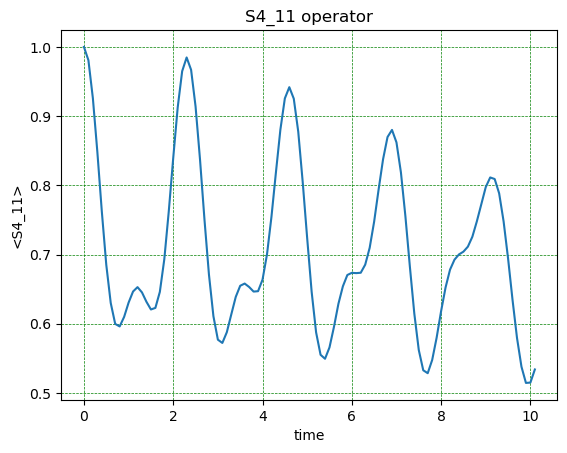

In [18]:
czz_list411, tlist411 = run_czz()

plt.plot(tlist411, czz_list411)
plt.title("S4_11 operator")
plt.xlabel("time")
plt.ylabel("<S4_11>")

plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

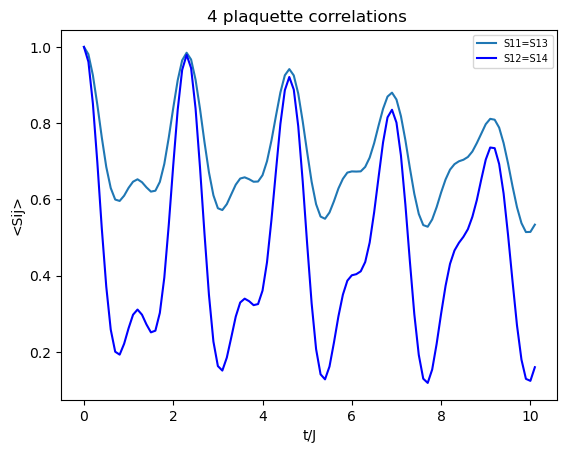

In [20]:
fig, ax = plt.subplots()
#plt.plot(tlist1, czz_list1, ls="-",color='m')


ax.plot(tlist411,czz_list411, ls="-",label='S11=S13')
ax.plot(tlist4,czz_list4, ls="-",label='S12=S14',color='blue')


plt.title("4 plaquette correlations ")
plt.xlabel("t/J")
plt.ylabel("<Sij>")
legend = ax.legend(fontsize='7')
plt.show()

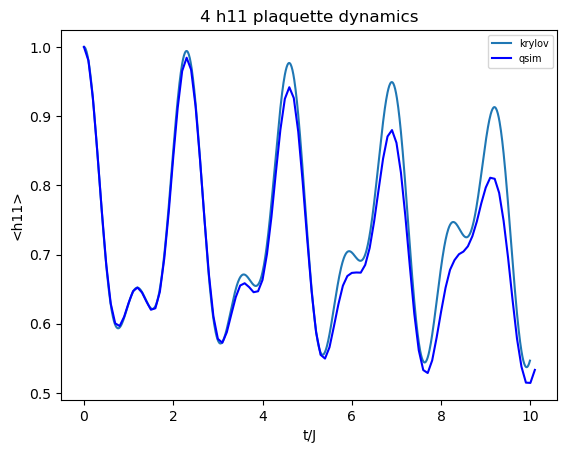

In [55]:
fig, ax = plt.subplots()
#plt.plot(tlist1, czz_list1, ls="-",color='m')


ax.plot(ktlist4,sklist4, ls="-",label='krylov')
ax.plot(tlist4,czz_list4, ls="-",label='qsim',color='blue')


plt.title("4 h11 plaquette dynamics")
plt.xlabel("t/J")
plt.ylabel("<h11>")
legend = ax.legend(fontsize='7')
plt.show()

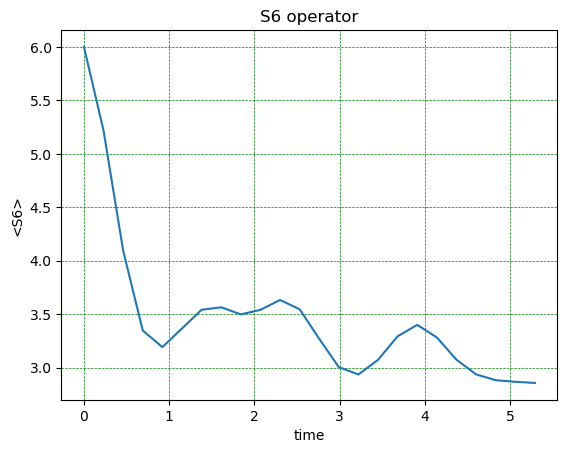

In [29]:
czz_listdd6, tlist6 = run_czz()

plt.plot(tlist6, czz_listdd6)
plt.title("S6 operator")
plt.xlabel("time")
plt.ylabel("<S6>")

plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

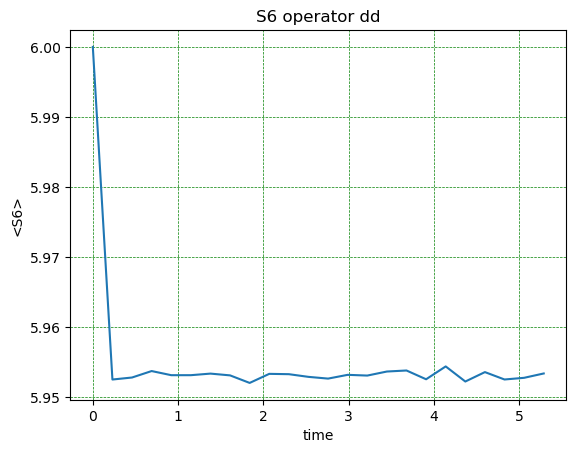

In [32]:
czz_list6ddd, tlist6dd = run_czz()

plt.plot(tlist6dd, czz_list6ddd)

plt.title("S6 operator dd")
plt.xlabel("time")
plt.ylabel("<S6>")

plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

In [ ]:
fig, ax = plt.subplots()
#plt.plot(tlist1, czz_list1, ls="-",color='m')


ax.plot(ktlist8,slist8, ls="-",label='no DD')
ax.plot(tlist8cal,czz_list8cal, ls="-",label='DD',color='blue')


plt.title("6 plaquette dynamics, fake dev, DD ")
plt.xlabel("t/J")
plt.ylabel("<S>")
legend = ax.legend(fontsize='7')
plt.show()

In [ ]:
czz_list8caln3, tlist8caln3 = run_czz()

plt.plot(tlist8caln3, czz_list8caln3)
plt.title("S8 operator")
plt.xlabel("time")
plt.ylabel("<S8>")

plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

52.200000000000001 5.9474999999999955


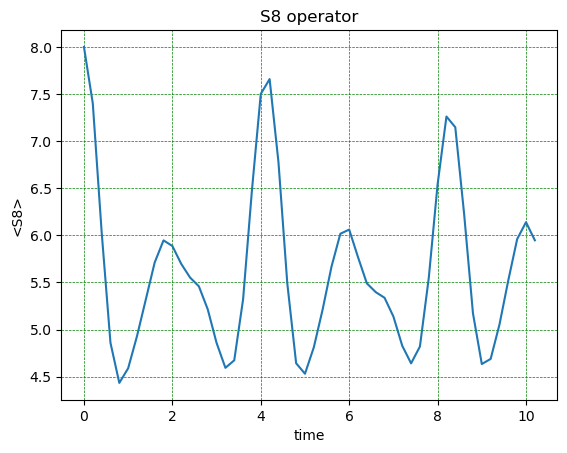

In [307]:
czz_list8caldepn, tlist8caldepn = run_czz()

plt.plot(tlist8caldepn, czz_list8caldepn)
plt.title("S8 operator")
plt.xlabel("time")
plt.ylabel("<S8>")

plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

102100000000000001 6.0010999999999995


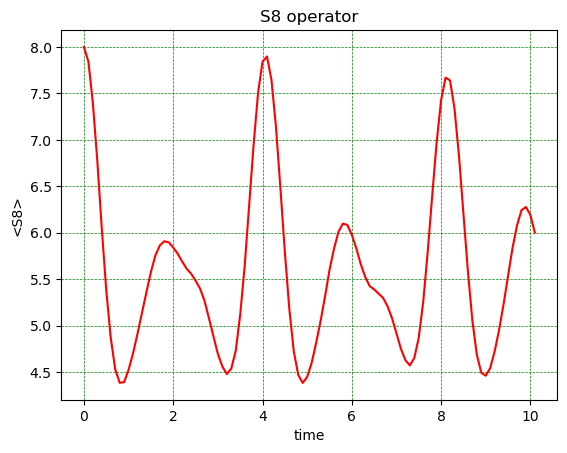

In [285]:
czz_list8, tlist8 = run_czz()

plt.plot(tlist8, czz_list8, ls="-",color='red')
plt.title("S8 operator")
plt.xlabel("time")
plt.ylabel("<S8>")

plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

102100000000000001 5.8705300000000005


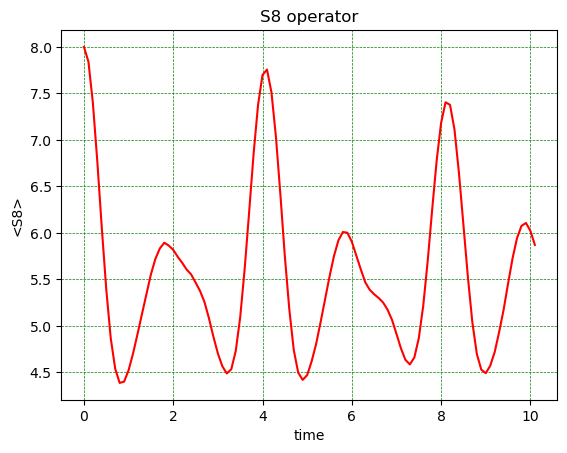

In [289]:
czz_list8dn, tlist8dn = run_czz()

plt.plot(tlist8dn, czz_list8dn, ls="-",color='red')
plt.title("S8 operator")
plt.xlabel("time")
plt.ylabel("<S8>")

plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

52.200000000000001 4.8307399999999995


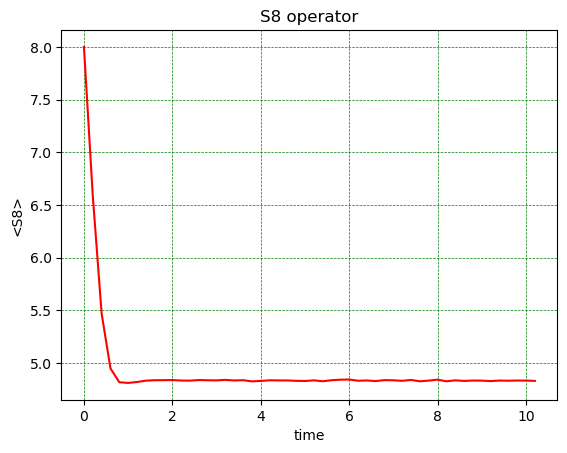

In [294]:
czz_list8l, tlist8l = run_czz()

plt.plot(tlist8l, czz_list8l, ls="-",color='red')
plt.title("S8 operator")
plt.xlabel("time")
plt.ylabel("<S8>")

plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

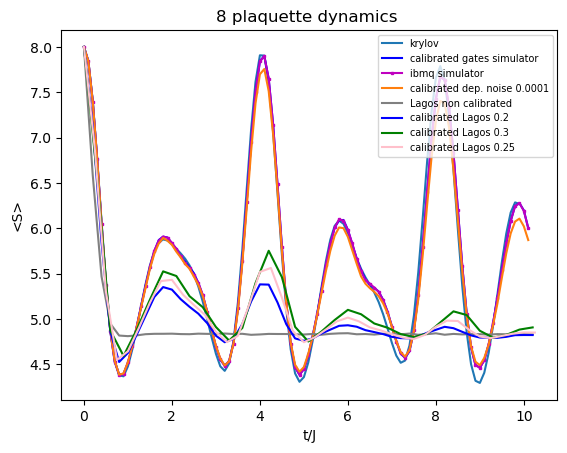

In [334]:
fig, ax = plt.subplots()
#plt.plot(tlist1, czz_list1, ls="-",color='m')


ax.plot(ktlist8,slist8, ls="-",label='krylov')
ax.plot(tlist8cal,czz_list8cal, ls="-",label='calibrated gates simulator',color='blue')
ax.plot(tlist8, czz_list8, label='ibmq simulator', marker='s', markersize = '1.75',color='m')
ax.plot(tlist8dn, czz_list8dn, label='calibrated dep. noise 0.0001', )
ax.plot(tlist8l, czz_list8l, label='Lagos non calibrated',color='grey' )
ax.plot(tlist8test,czz_list8test, ls="-",label='calibrated Lagos 0.2',color='blue')  ####0.2 dt
ax.plot(tlist8test2,czz_list8test2, ls="-",label='calibrated Lagos 0.3',color='g')  ####0.3 dt
ax.plot(tlist8test3,czz_list8test3, ls="-",label='calibrated Lagos 0.25',color='pink')  ####0.25 dt


plt.title("8 plaquette dynamics ")
plt.xlabel("t/J")
plt.ylabel("<S>")
legend = ax.legend(fontsize='7')
plt.show()

In [284]:
ktlist8=[0.0,
 0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6000000000000001,
 0.7000000000000001,
 0.8,
 0.9,
 1.0,
 1.1,
 1.2000000000000002,
 1.3,
 1.4000000000000001,
 1.5,
 1.6,
 1.7000000000000002,
 1.8,
 1.9000000000000001,
 2.0,
 2.1,
 2.2,
 2.3000000000000003,
 2.4000000000000004,
 2.5,
 2.6,
 2.7,
 2.8000000000000003,
 2.9000000000000004,
 3.0,
 3.1,
 3.2,
 3.3000000000000003,
 3.4000000000000004,
 3.5,
 3.6,
 3.7,
 3.8000000000000003,
 3.9000000000000004,
 4.0,
 4.1000000000000005,
 4.2,
 4.3,
 4.4,
 4.5,
 4.6000000000000005,
 4.7,
 4.800000000000001,
 4.9,
 5.0,
 5.1000000000000005,
 5.2,
 5.300000000000001,
 5.4,
 5.5,
 5.6000000000000005,
 5.7,
 5.800000000000001,
 5.9,
 6.0,
 6.1000000000000005,
 6.2,
 6.300000000000001,
 6.4,
 6.5,
 6.6000000000000005,
 6.7,
 6.800000000000001,
 6.9,
 7.0,
 7.1000000000000005,
 7.2,
 7.300000000000001,
 7.4,
 7.5,
 7.6000000000000005,
 7.7,
 7.800000000000001,
 7.9,
 8.0,
 8.1,
 8.200000000000001,
 8.3,
 8.4,
 8.5,
 8.6,
 8.700000000000001,
 8.8,
 8.9,
 9.0,
 9.1,
 9.200000000000001,
 9.3,
 9.4,
 9.5,
 9.600000000000001,
 9.700000000000001,
 9.8,
 9.9]

slist8=[7.999999999999991,
 7.842901414746668,
 7.404939033072174,
 6.775758117347982,
 6.074588404610522,
 5.417858598205454,
 4.8928345084223235,
 4.544722965775526,
 4.378183711555649,
 4.3688664426291375,
 4.4783461625423415,
 4.666599147695709,
 4.898779119924492,
 5.146233979868786,
 5.3843386715543655,
 5.590802556077473,
 5.747021780266383,
 5.84223844614967,
 5.877483383343911,
 5.865609082227558,
 5.825942130849908,
 5.7757600880780435,
 5.7231800349161865,
 5.665260837066597,
 5.591757773638658,
 5.491619440241036,
 5.358417357228118,
 5.192761055055496,
 5.002493563861146,
 4.802767003706785,
 4.617134432094143,
 4.478656776122373,
 4.428552402668682,
 4.510191551692106,
 4.758058946883882,
 5.183766931092377,
 5.763406201165086,
 6.431717705890212,
 7.087919575218842,
 7.614852526783987,
 7.907812049843923,
 7.904137662376427,
 7.602456826787179,
 7.063511985848749,
 6.391889338253537,
 5.70600601067301,
 5.108077425747896,
 4.6643796830941735,
 4.4002892584803535,
 4.307899792979251,
 4.359790048419237,
 4.5220041623353,
 4.76169618870107,
 5.048484580862284,
 5.351814273182505,
 5.638427303802901,
 5.873680406854133,
 6.027879552676338,
 6.08515990656876,
 6.049888137585929,
 5.946043020727816,
 5.808652599400017,
 5.670947470479885,
 5.553353453714243,
 5.459147764939131,
 5.377617347247307,
 5.291778196267832,
 5.186511318159747,
 5.054456218721398,
 4.8993104916782455,
 4.737320729301757,
 4.59723210437286,
 4.517872739738158,
 4.542249439075875,
 4.707963126515786,
 5.035344878977256,
 5.516166181664722,
 6.106645581876871,
 6.728498393348415,
 7.280479502415401,
 7.659801826009758,
 7.788469721721057,
 7.635927178838734,
 7.229083862122442,
 6.644991521624185,
 5.988631905407075,
 5.364641796446685,
 4.853752278128129,
 4.501352352608325,
 4.319200080061156,
 4.295639290926508,
 4.407409872800401,
 4.627544851159422,
 4.927344099381643,
 5.274003503474042,
 5.627754955578348,
 5.942645007995877,
 6.17319927756496,
 6.2857523255906536,
 6.269734739993879]

In [110]:
# czz_list4, tlist4 = run_czz()

# plt.plot(tlist4, czz_list4, ls="-",color='red')
# plt.title("S4 operator")
# plt.xlabel("time")
# plt.ylabel("<S4>")

# plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

In [73]:
import numpy as np

In [75]:
np.savetxt("tlist4qsim10.txt",tlist4)
np.savetxt("czzlist4qsim10.txt",czz_list4)

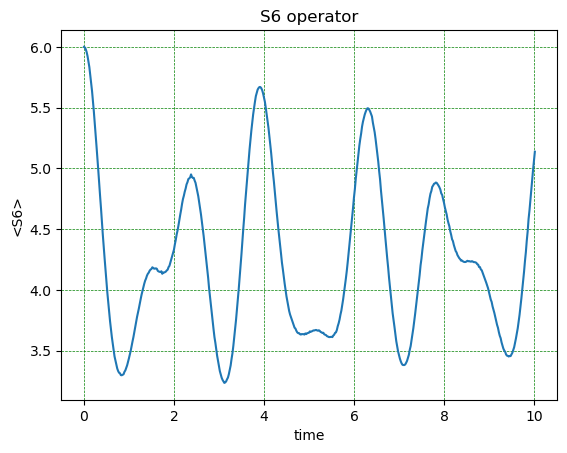

In [119]:
czz_list6, tlist6 = run_czz()

plt.plot(tlist6, czz_list6, ls="-")
plt.title("S6 operator")
plt.xlabel("time")
plt.ylabel("<S6>")

plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

2225 2.9825399999999997


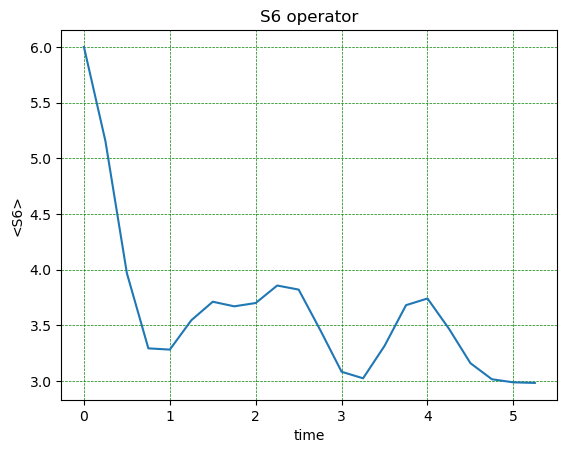

In [358]:
czz_list6trotter2775, tlist6trotter2775 = run_czz()

plt.plot(tlist6trotter2775, czz_list6trotter2775, ls="-")
plt.title("S6 operator")
plt.xlabel("time")
plt.ylabel("<S6>")

plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

42.25 2.809289999999976


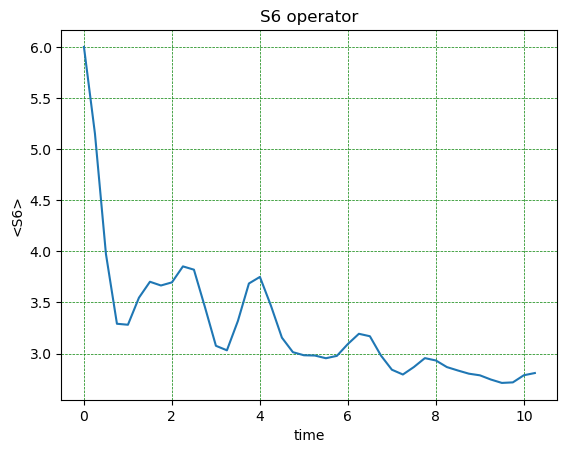

In [337]:
czz_list6caltra, tlist6caltra = run_czz()

plt.plot(tlist6caltra, czz_list6caltra, ls="-")
plt.title("S6 operator")
plt.xlabel("time")
plt.ylabel("<S6>")

plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

In [78]:
np.savetxt("tlist4qsim10n.txt",tlist4n)
np.savetxt("czzlist4qsim10n.txt",czz_list4n)

102100000000000001 5.2032900000000037


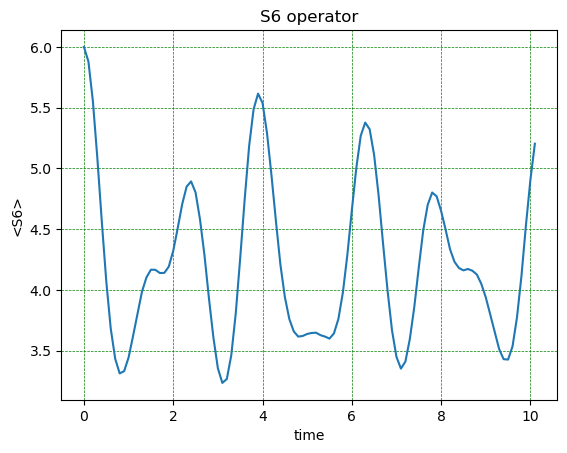

In [341]:
czz_list6caldepn, tlist6caldepn = run_czz()

plt.plot(tlist6caldepn, czz_list6caldepn, ls="-")
plt.title("S6 operator")
plt.xlabel("time")
plt.ylabel("<S6>")

plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

102100000000000001 2.6602799999999984


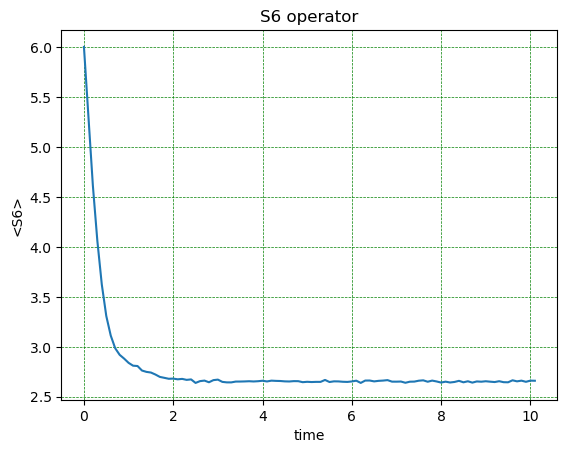

In [239]:
czz_list6n, tlist6n = run_czz()

plt.plot(tlist6n, czz_list6n, ls="-")
plt.title("S6 operator")
plt.xlabel("time")
plt.ylabel("<S6>")

plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

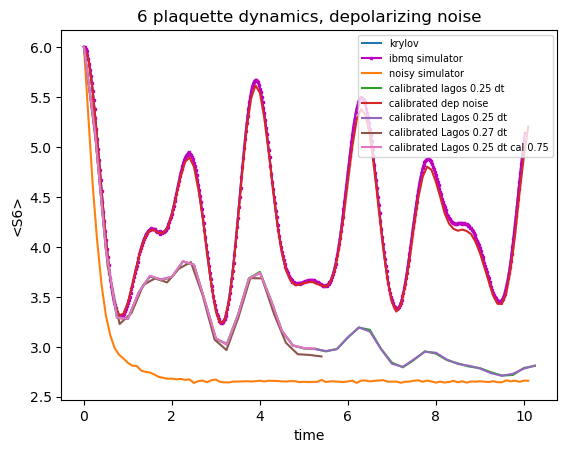

In [359]:
fig, ax = plt.subplots()
#plt.plot(tlist1, czz_list1, ls="-",color='m')


ax.plot(ktlist6,sklist6, ls="-",label='krylov')
#ax.plot(tlist6cal,czz_list6cal, ls="-",label='calibrated gates',color='blue')
ax.plot(tlist6, czz_list6, label='ibmq simulator', marker='s', markersize = '1.75',color='m')
ax.plot(tlist6n, czz_list6n, label='noisy simulator', )
ax.plot(tlist6caltra, czz_list6caltra, label='calibrated lagos 0.25 dt')
ax.plot(tlist6caldepn, czz_list6caldepn, label='calibrated dep noise')
ax.plot(tlist6trotter25, czz_list6trotter25, label='calibrated Lagos 0.25 dt')
ax.plot(tlist6trotter27, czz_list6trotter27, label='calibrated Lagos 0.27 dt')
ax.plot(tlist6trotter2775, czz_list6trotter2775, label='calibrated Lagos 0.25 dt cal 0.75')




plt.title("6 plaquette dynamics, depolarizing noise")
plt.xlabel("time")
plt.ylabel("<S6>")
legend = ax.legend(fontsize='7')
plt.show()

102100000000000001 2.1521899999999973


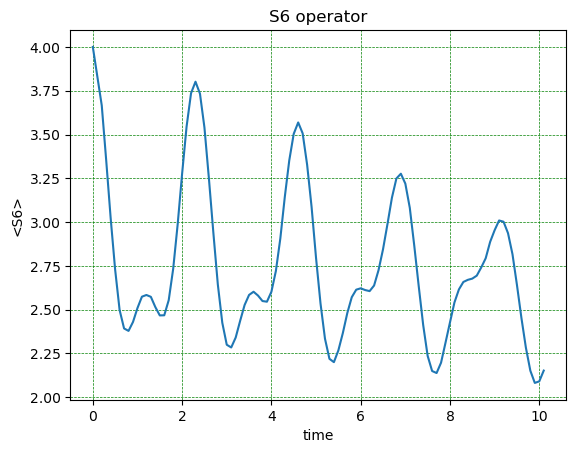

In [219]:
czz_list4depnn, tlist4depnn = run_czz()

plt.plot(tlist4depnn, czz_list4depnn, ls="-")
plt.title("S6 operator")
plt.xlabel("time")
plt.ylabel("<S6>")

plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

102100000000000001 2.1638999999999973


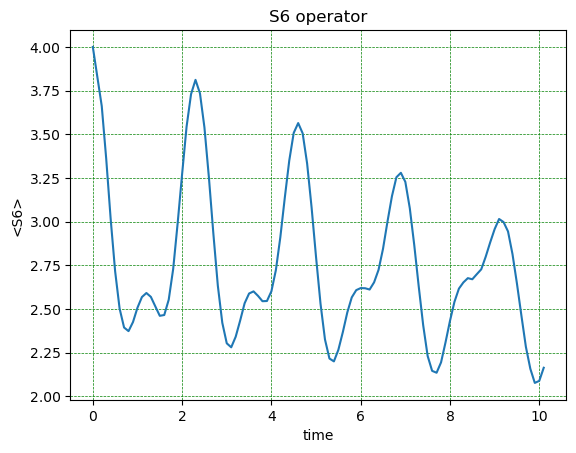

In [230]:
czz_list4depn, tlist4depn = run_czz()

plt.plot(tlist4depn, czz_list4depn, ls="-")
plt.title("S6 operator")
plt.xlabel("time")
plt.ylabel("<S6>")

plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

102100000000000001 2.0193800000000002


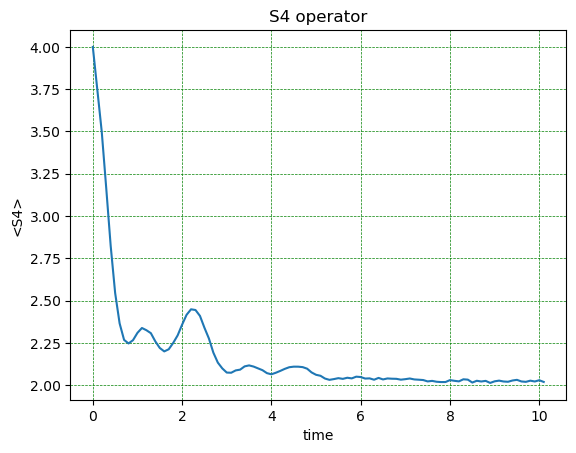

In [234]:
czz_list4n, tlist4n = run_czz()

plt.plot(tlist4n, czz_list4n, ls="-")
plt.title("S4 operator")
plt.xlabel("time")
plt.ylabel("<S4>")

plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

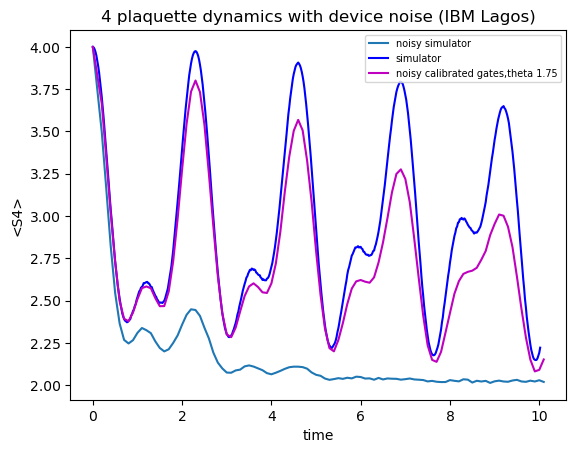

In [236]:
fig, ax = plt.subplots()
#plt.plot(tlist1, czz_list1, ls="-",color='m')


ax.plot(tlist4n,czz_list4n, ls="-",label='noisy simulator')
ax.plot(tlist4,czz_list4, ls="-",label='simulator',color='blue')
ax.plot(tlist4depnn, czz_list4depnn, label='noisy calibrated gates,theta 1.75',  color='m')
#ax.plot(tlist4depn, czz_list4depn, label='noisy calibrated gates,theta 0.5')

plt.title("4 plaquette dynamics with device noise (IBM Lagos)")
plt.xlabel("time")
plt.ylabel("<S4>")
legend = ax.legend(fontsize='7')
plt.show()

In [237]:
np.savetxt("tlist4quantum.txt",tlist4n)
np.savetxt("czz_list4n.txt",czz_list4n)
np.savetxt("czz_list4depn.txt", czz_list4depn)
np.savetxt("czz_list4.txt",czz_list4)

In [305]:
noise_model = NoiseModel()

# Add depolarizing error to all single qubit u1, u2, u3 gates
error = depolarizing_error(0.0001, 1)
noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])

# Print noise model info
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'u2', 'u3']
  All-qubits errors: ['u1', 'u2', 'u3']


In [116]:
ktlist6=[0.0,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1,
 0.11,
 0.12,
 0.13,
 0.14,
 0.15,
 0.16,
 0.17,
 0.18,
 0.19,
 0.2,
 0.21,
 0.22,
 0.23,
 0.24,
 0.25,
 0.26,
 0.27,
 0.28,
 0.29,
 0.3,
 0.31,
 0.32,
 0.33,
 0.34,
 0.35000000000000003,
 0.36,
 0.37,
 0.38,
 0.39,
 0.4,
 0.41000000000000003,
 0.42,
 0.43,
 0.44,
 0.45,
 0.46,
 0.47000000000000003,
 0.48,
 0.49,
 0.5,
 0.51,
 0.52,
 0.53,
 0.54,
 0.55,
 0.56,
 0.5700000000000001,
 0.58,
 0.59,
 0.6,
 0.61,
 0.62,
 0.63,
 0.64,
 0.65,
 0.66,
 0.67,
 0.68,
 0.6900000000000001,
 0.7000000000000001,
 0.71,
 0.72,
 0.73,
 0.74,
 0.75,
 0.76,
 0.77,
 0.78,
 0.79,
 0.8,
 0.81,
 0.8200000000000001,
 0.8300000000000001,
 0.84,
 0.85,
 0.86,
 0.87,
 0.88,
 0.89,
 0.9,
 0.91,
 0.92,
 0.93,
 0.9400000000000001,
 0.9500000000000001,
 0.96,
 0.97,
 0.98,
 0.99,
 1.0,
 1.01,
 1.02,
 1.03,
 1.04,
 1.05,
 1.06,
 1.07,
 1.08,
 1.09,
 1.1,
 1.11,
 1.12,
 1.1300000000000001,
 1.1400000000000001,
 1.1500000000000001,
 1.16,
 1.17,
 1.18,
 1.19,
 1.2,
 1.21,
 1.22,
 1.23,
 1.24,
 1.25,
 1.26,
 1.27,
 1.28,
 1.29,
 1.3,
 1.31,
 1.32,
 1.33,
 1.34,
 1.35,
 1.36,
 1.37,
 1.3800000000000001,
 1.3900000000000001,
 1.4000000000000001,
 1.41,
 1.42,
 1.43,
 1.44,
 1.45,
 1.46,
 1.47,
 1.48,
 1.49,
 1.5,
 1.51,
 1.52,
 1.53,
 1.54,
 1.55,
 1.56,
 1.57,
 1.58,
 1.59,
 1.6,
 1.61,
 1.62,
 1.6300000000000001,
 1.6400000000000001,
 1.6500000000000001,
 1.6600000000000001,
 1.67,
 1.68,
 1.69,
 1.7,
 1.71,
 1.72,
 1.73,
 1.74,
 1.75,
 1.76,
 1.77,
 1.78,
 1.79,
 1.8,
 1.81,
 1.82,
 1.83,
 1.84,
 1.85,
 1.86,
 1.87,
 1.8800000000000001,
 1.8900000000000001,
 1.9000000000000001,
 1.9100000000000001,
 1.92,
 1.93,
 1.94,
 1.95,
 1.96,
 1.97,
 1.98,
 1.99,
 2.0,
 2.0100000000000002,
 2.02,
 2.0300000000000002,
 2.04,
 2.05,
 2.06,
 2.07,
 2.08,
 2.09,
 2.1,
 2.11,
 2.12,
 2.13,
 2.14,
 2.15,
 2.16,
 2.17,
 2.18,
 2.19,
 2.2,
 2.21,
 2.22,
 2.23,
 2.24,
 2.25,
 2.2600000000000002,
 2.27,
 2.2800000000000002,
 2.29,
 2.3000000000000003,
 2.31,
 2.32,
 2.33,
 2.34,
 2.35,
 2.36,
 2.37,
 2.38,
 2.39,
 2.4,
 2.41,
 2.42,
 2.43,
 2.44,
 2.45,
 2.46,
 2.47,
 2.48,
 2.49,
 2.5,
 2.5100000000000002,
 2.52,
 2.5300000000000002,
 2.54,
 2.5500000000000003,
 2.56,
 2.57,
 2.58,
 2.59,
 2.6,
 2.61,
 2.62,
 2.63,
 2.64,
 2.65,
 2.66,
 2.67,
 2.68,
 2.69,
 2.7,
 2.71,
 2.72,
 2.73,
 2.74,
 2.75,
 2.7600000000000002,
 2.77,
 2.7800000000000002,
 2.79,
 2.8000000000000003,
 2.81,
 2.82,
 2.83,
 2.84,
 2.85,
 2.86,
 2.87,
 2.88,
 2.89,
 2.9,
 2.91,
 2.92,
 2.93,
 2.94,
 2.95,
 2.96,
 2.97,
 2.98,
 2.99,
 3.0,
 3.0100000000000002,
 3.02,
 3.0300000000000002,
 3.04,
 3.0500000000000003,
 3.06,
 3.0700000000000003,
 3.08,
 3.09,
 3.1,
 3.11,
 3.12,
 3.13,
 3.14,
 3.15,
 3.16,
 3.17,
 3.18,
 3.19,
 3.2,
 3.21,
 3.22,
 3.23,
 3.24,
 3.25,
 3.2600000000000002,
 3.27,
 3.2800000000000002,
 3.29,
 3.3000000000000003,
 3.31,
 3.3200000000000003,
 3.33,
 3.34,
 3.35,
 3.36,
 3.37,
 3.38,
 3.39,
 3.4,
 3.41,
 3.42,
 3.43,
 3.44,
 3.45,
 3.46,
 3.47,
 3.48,
 3.49,
 3.5,
 3.5100000000000002,
 3.52,
 3.5300000000000002,
 3.54,
 3.5500000000000003,
 3.56,
 3.5700000000000003,
 3.58,
 3.59,
 3.6,
 3.61,
 3.62,
 3.63,
 3.64,
 3.65,
 3.66,
 3.67,
 3.68,
 3.69,
 3.7,
 3.71,
 3.72,
 3.73,
 3.74,
 3.75,
 3.7600000000000002,
 3.77,
 3.7800000000000002,
 3.79,
 3.8000000000000003,
 3.81,
 3.8200000000000003,
 3.83,
 3.84,
 3.85,
 3.86,
 3.87,
 3.88,
 3.89,
 3.9,
 3.91,
 3.92,
 3.93,
 3.94,
 3.95,
 3.96,
 3.97,
 3.98,
 3.99,
 4.0,
 4.01,
 4.0200000000000005,
 4.03,
 4.04,
 4.05,
 4.0600000000000005,
 4.07,
 4.08,
 4.09,
 4.1,
 4.11,
 4.12,
 4.13,
 4.14,
 4.15,
 4.16,
 4.17,
 4.18,
 4.19,
 4.2,
 4.21,
 4.22,
 4.23,
 4.24,
 4.25,
 4.26,
 4.2700000000000005,
 4.28,
 4.29,
 4.3,
 4.3100000000000005,
 4.32,
 4.33,
 4.34,
 4.3500000000000005,
 4.36,
 4.37,
 4.38,
 4.39,
 4.4,
 4.41,
 4.42,
 4.43,
 4.44,
 4.45,
 4.46,
 4.47,
 4.48,
 4.49,
 4.5,
 4.51,
 4.5200000000000005,
 4.53,
 4.54,
 4.55,
 4.5600000000000005,
 4.57,
 4.58,
 4.59,
 4.6000000000000005,
 4.61,
 4.62,
 4.63,
 4.64,
 4.65,
 4.66,
 4.67,
 4.68,
 4.69,
 4.7,
 4.71,
 4.72,
 4.73,
 4.74,
 4.75,
 4.76,
 4.7700000000000005,
 4.78,
 4.79,
 4.8,
 4.8100000000000005,
 4.82,
 4.83,
 4.84,
 4.8500000000000005,
 4.86,
 4.87,
 4.88,
 4.89,
 4.9,
 4.91,
 4.92,
 4.93,
 4.94,
 4.95,
 4.96,
 4.97,
 4.98,
 4.99,
 5.0,
 5.01,
 5.0200000000000005,
 5.03,
 5.04,
 5.05,
 5.0600000000000005,
 5.07,
 5.08,
 5.09,
 5.1000000000000005,
 5.11,
 5.12,
 5.13,
 5.14,
 5.15,
 5.16,
 5.17,
 5.18,
 5.19,
 5.2,
 5.21,
 5.22,
 5.23,
 5.24,
 5.25,
 5.26,
 5.2700000000000005,
 5.28,
 5.29,
 5.3,
 5.3100000000000005,
 5.32,
 5.33,
 5.34,
 5.3500000000000005,
 5.36,
 5.37,
 5.38,
 5.39,
 5.4,
 5.41,
 5.42,
 5.43,
 5.44,
 5.45,
 5.46,
 5.47,
 5.48,
 5.49,
 5.5,
 5.51,
 5.5200000000000005,
 5.53,
 5.54,
 5.55,
 5.5600000000000005,
 5.57,
 5.58,
 5.59,
 5.6000000000000005,
 5.61,
 5.62,
 5.63,
 5.64,
 5.65,
 5.66,
 5.67,
 5.68,
 5.69,
 5.7,
 5.71,
 5.72,
 5.73,
 5.74,
 5.75,
 5.76,
 5.7700000000000005,
 5.78,
 5.79,
 5.8,
 5.8100000000000005,
 5.82,
 5.83,
 5.84,
 5.8500000000000005,
 5.86,
 5.87,
 5.88,
 5.89,
 5.9,
 5.91,
 5.92,
 5.93,
 5.94,
 5.95,
 5.96,
 5.97,
 5.98,
 5.99,
 6.0,
 6.01,
 6.0200000000000005,
 6.03,
 6.04,
 6.05,
 6.0600000000000005,
 6.07,
 6.08,
 6.09,
 6.1000000000000005,
 6.11,
 6.12,
 6.13,
 6.140000000000001,
 6.15,
 6.16,
 6.17,
 6.18,
 6.19,
 6.2,
 6.21,
 6.22,
 6.23,
 6.24,
 6.25,
 6.26,
 6.2700000000000005,
 6.28,
 6.29,
 6.3,
 6.3100000000000005,
 6.32,
 6.33,
 6.34,
 6.3500000000000005,
 6.36,
 6.37,
 6.38,
 6.390000000000001,
 6.4,
 6.41,
 6.42,
 6.43,
 6.44,
 6.45,
 6.46,
 6.47,
 6.48,
 6.49,
 6.5,
 6.51,
 6.5200000000000005,
 6.53,
 6.54,
 6.55,
 6.5600000000000005,
 6.57,
 6.58,
 6.59,
 6.6000000000000005,
 6.61,
 6.62,
 6.63,
 6.640000000000001,
 6.65,
 6.66,
 6.67,
 6.68,
 6.69,
 6.7,
 6.71,
 6.72,
 6.73,
 6.74,
 6.75,
 6.76,
 6.7700000000000005,
 6.78,
 6.79,
 6.8,
 6.8100000000000005,
 6.82,
 6.83,
 6.84,
 6.8500000000000005,
 6.86,
 6.87,
 6.88,
 6.890000000000001,
 6.9,
 6.91,
 6.92,
 6.93,
 6.94,
 6.95,
 6.96,
 6.97,
 6.98,
 6.99,
 7.0,
 7.01,
 7.0200000000000005,
 7.03,
 7.04,
 7.05,
 7.0600000000000005,
 7.07,
 7.08,
 7.09,
 7.1000000000000005,
 7.11,
 7.12,
 7.13,
 7.140000000000001,
 7.15,
 7.16,
 7.17,
 7.18,
 7.19,
 7.2,
 7.21,
 7.22,
 7.23,
 7.24,
 7.25,
 7.26,
 7.2700000000000005,
 7.28,
 7.29,
 7.3,
 7.3100000000000005,
 7.32,
 7.33,
 7.34,
 7.3500000000000005,
 7.36,
 7.37,
 7.38,
 7.390000000000001,
 7.4,
 7.41,
 7.42,
 7.43,
 7.44,
 7.45,
 7.46,
 7.47,
 7.48,
 7.49,
 7.5,
 7.51,
 7.5200000000000005,
 7.53,
 7.54,
 7.55,
 7.5600000000000005,
 7.57,
 7.58,
 7.59,
 7.6000000000000005,
 7.61,
 7.62,
 7.63,
 7.640000000000001,
 7.65,
 7.66,
 7.67,
 7.68,
 7.69,
 7.7,
 7.71,
 7.72,
 7.73,
 7.74,
 7.75,
 7.76,
 7.7700000000000005,
 7.78,
 7.79,
 7.8,
 7.8100000000000005,
 7.82,
 7.83,
 7.84,
 7.8500000000000005,
 7.86,
 7.87,
 7.88,
 7.890000000000001,
 7.9,
 7.91,
 7.92,
 7.930000000000001,
 7.94,
 7.95,
 7.96,
 7.97,
 7.98,
 7.99,
 8.0,
 8.01,
 8.02,
 8.03,
 8.040000000000001,
 8.05,
 8.06,
 8.07,
 8.08,
 8.09,
 8.1,
 8.11,
 8.120000000000001,
 8.13,
 8.14,
 8.15,
 8.16,
 8.17,
 8.18,
 8.19,
 8.2,
 8.21,
 8.22,
 8.23,
 8.24,
 8.25,
 8.26,
 8.27,
 8.28,
 8.290000000000001,
 8.3,
 8.31,
 8.32,
 8.33,
 8.34,
 8.35,
 8.36,
 8.370000000000001,
 8.38,
 8.39,
 8.4,
 8.41,
 8.42,
 8.43,
 8.44,
 8.45,
 8.46,
 8.47,
 8.48,
 8.49,
 8.5,
 8.51,
 8.52,
 8.53,
 8.540000000000001,
 8.55,
 8.56,
 8.57,
 8.58,
 8.59,
 8.6,
 8.61,
 8.620000000000001,
 8.63,
 8.64,
 8.65,
 8.66,
 8.67,
 8.68,
 8.69,
 8.700000000000001,
 8.71,
 8.72,
 8.73,
 8.74,
 8.75,
 8.76,
 8.77,
 8.78,
 8.790000000000001,
 8.8,
 8.81,
 8.82,
 8.83,
 8.84,
 8.85,
 8.86,
 8.870000000000001,
 8.88,
 8.89,
 8.9,
 8.91,
 8.92,
 8.93,
 8.94,
 8.950000000000001,
 8.96,
 8.97,
 8.98,
 8.99,
 9.0,
 9.01,
 9.02,
 9.03,
 9.040000000000001,
 9.05,
 9.06,
 9.07,
 9.08,
 9.09,
 9.1,
 9.11,
 9.120000000000001,
 9.13,
 9.14,
 9.15,
 9.16,
 9.17,
 9.18,
 9.19,
 9.200000000000001,
 9.21,
 9.22,
 9.23,
 9.24,
 9.25,
 9.26,
 9.27,
 9.28,
 9.290000000000001,
 9.3,
 9.31,
 9.32,
 9.33,
 9.34,
 9.35,
 9.36,
 9.370000000000001,
 9.38,
 9.39,
 9.4,
 9.41,
 9.42,
 9.43,
 9.44,
 9.450000000000001,
 9.46,
 9.47,
 9.48,
 9.49,
 9.5,
 9.51,
 9.52,
 9.53,
 9.540000000000001,
 9.55,
 9.56,
 9.57,
 9.58,
 9.59,
 9.6,
 9.61,
 9.620000000000001,
 9.63,
 9.64,
 9.65,
 9.66,
 9.67,
 9.68,
 9.69,
 9.700000000000001,
 9.71,
 9.72,
 9.73,
 9.74,
 9.75,
 9.76,
 9.77,
 9.78,
 9.790000000000001,
 9.8,
 9.81,
 9.82,
 9.83,
 9.84,
 9.85,
 9.86,
 9.870000000000001,
 9.88,
 9.89,
 9.9,
 9.91,
 9.92,
 9.93,
 9.94,
 9.950000000000001,
 9.96,
 9.97,
 9.98,
 9.99]

sklist6=[5.999999999999997,
 5.998800219975867,
 5.995203518455962,
 5.989217802419627,
 5.980856221277971,
 5.970137123679809,
 5.957083997314358,
 5.9417253919832484,
 5.924094826289699,
 5.904230678366117,
 5.882176061132227,
 5.857978682644417,
 5.831690692161857,
 5.80336851261709,
 5.773072660236459,
 5.740867552109817,
 5.706821302558491,
 5.671005509195204,
 5.633495029609913,
 5.594367749650325,
 5.553704344295605,
 5.511588032146218,
 5.468104324571654,
 5.423340770571147,
 5.377386698410163,
 5.330332955097727,
 5.282271644765985,
 5.233295867004641,
 5.183499456188438,
 5.132976722816275,
 5.081822197855536,
 5.030130381055815,
 4.977995494161319,
 4.9255112399125585,
 4.872770567684544,
 4.819865446561633,
 4.766886646598365,
 4.713923528961549,
 4.661063845591929,
 4.60839354896408,
 4.555996612461534,
 4.503954861820489,
 4.452347818030556,
 4.401252552014974,
 4.350743551346226,
 4.300892599186247,
 4.251768665573861,
 4.203437811116251,
 4.155963103076363,
 4.1094045437847,
 4.063819011242187,
 4.019260211721319,
 3.9757786441156147,
 3.9334215757330835,
 3.8922330291782212,
 3.852253779919125,
 3.8135213640920926,
 3.7760700960556672,
 3.7399310951697013,
 3.7051323212428566,
 3.6716986180642364,
 3.639651764411401,
 3.6090105319083974,
 3.5797907490931347,
 3.5520053710440043,
 3.525664553910644,
 3.5007757336934167,
 3.47734370862031,
 3.4553707244784957,
 3.4348565622705673,
 3.4157986275823835,
 3.398192041070299,
 3.382029729499974,
 3.3673025167971327,
 3.3539992146016595,
 3.3421067118507235,
 3.331610062953337,
 3.3224925741579274,
 3.3147358877556203,
 3.3083200638047385,
 3.3032236591062287,
 3.2994238032047454,
 3.2968962712359544,
 3.2956155534865585,
 3.2955549215795,
 3.2966864912422014,
 3.2989812816604016,
 3.3024092714636555,
 3.3069394514305808,
 3.312539874042232,
 3.319177700050123,
 3.32681924226123,
 3.3354300067753977,
 3.344974731940895,
 3.3554174253209395,
 3.366721398987823,
 3.378849303481649,
 3.391763160787276,
 3.4054243966960396,
 3.4197938729278516,
 3.434831919394384,
 3.450498366985239,
 3.4667525812561526,
 3.483553497391611,
 3.500859656803524,
 3.5186292457132535,
 3.5368201360460505,
 3.555389928945347,
 3.5742960011891527,
 3.593495554762564,
 3.6129456698090694,
 3.632603361149234,
 3.6524256385188907,
 3.6723695706400594,
 3.6923923531972376,
 3.7124513807492945,
 3.7325043225636496,
 3.7525092023148354,
 3.7724244815443724,
 3.792209146733386,
 3.8118227997941925,
 3.8312257517419503,
 3.8503791192636023,
 3.8692449238581785,
 3.8877861931811974,
 3.905967064186175,
 3.9237528876188548,
 3.941110333384668,
 3.958007496277766,
 3.9744140015307226,
 3.990301109618098,
 4.005641819724744,
 4.020410971271101,
 4.034585342873101,
 4.048143748103845,
 4.06106712741782,
 4.073338635596674,
 4.084943724078071,
 4.095870217536161,
 4.106108384093871,
 4.115650998563231,
 4.124493398130596,
 4.132633529928526,
 4.140071989965378,
 4.146812052917114,
 4.152859692323221,
 4.158223590769956,
 4.1629151396889315,
 4.166948428447307,
 4.170340222457172,
 4.173109930085775,
 4.175279558204913,
 4.1768736562765545,
 4.177919248932336,
 4.17844575706666,
 4.178484907526231,
 4.17807063154271,
 4.1772389521193105,
 4.17602786064619,
 4.174477183083103,
 4.17262843611039,
 4.17052467371084,
 4.168210324704611,
 4.165731021817079,
 4.163133422914708,
 4.160465025096374,
 4.157773972376947,
 4.155108857745617,
 4.152518520423509,
 4.150051839183027,
 4.147757522624931,
 4.145683897338177,
 4.143878694891654,
 4.142388838626275,
 4.14126023122979,
 4.1405375440856105,
 4.140264009390274,
 4.140481216032183,
 4.141228910216862,
 4.142544801810954,
 4.144464377358979,
 4.147020720703108,
 4.1502443421073245,
 4.154163016753383,
 4.15880163343688,
 4.1641820542482,
 4.170322985974727,
 4.177239863908315,
 4.184944748685475,
 4.193446236727587,
 4.202749384784909,
 4.212855649021681,
 4.223762839010378,
 4.235465086931843,
 4.247952832204678,
 4.2612128216926575,
 4.275228125563076,
 4.289978168792732,
 4.305438778241684,
 4.321582245138681,
 4.338377402746716,
 4.35578971890264,
 4.373781403052005,
 4.392311527329378,
 4.411336161165797,
 4.430808518839309,
 4.450679119321795,
 4.470895957716089,
 4.491404687522027,
 4.512148812918669,
 4.533069890203113,
 4.55410773748393,
 4.575200651689962,
 4.596285631922782,
 4.617298608154109,
 4.638174674247683,
 4.658848324268917,
 4.679253691034952,
 4.699324785852632,
 4.718995738392454,
 4.738201035652575,
 4.75687575897866,
 4.774955818122146,
 4.792378181342023,
 4.809081100582459,
 4.825004330791017,
 4.840089342479348,
 4.854279526669663,
 4.867520391416219,
 4.879759749140597,
 4.890947894072936,
 4.9010377691477895,
 4.90998512176274,
 4.917748647869936,
 4.9242901239348,
 4.929574526362163,
 4.933570138057372,
 4.9362486418579445,
 4.937585200640528,
 4.937558523976367,
 4.936150921277411,
 4.933348341443126,
 4.929140399084687,
 4.923520387469017,
 4.916485278388189,
 4.908035709221609,
 4.898175957516603,
 4.886913903469418,
 4.874260980741053,
 4.860232116091717,
 4.8448456583632264,
 4.828123297380199,
 4.810089973378355,
 4.790773777601146,
 4.770205844734807,
 4.748420237875547,
 4.725453826742172,
 4.701346159861752,
 4.676139331465889,
 4.6498778438400015,
 4.622608465868401,
 4.594380088513581,
 4.565243577959099,
 4.535251627132284,
 4.504458606305119,
 4.472920413450227,
 4.440694325003042,
 4.407838847652312,
 4.374413571748186,
 4.340479026881716,
 4.306096540150873,
 4.27132809758735,
 4.236236209175031,
 4.200883777846258,
 4.16533397279531,
 4.12965010740099,
 4.09389552200188,
 4.05813347171888,
 4.022427019471009,
 3.9868389342818342,
 3.95143159492604,
 3.9162668989189804,
 3.881406176806456,
 3.846910111668361,
 3.81283866370799,
 3.7792509997593755,
 3.7462054275082175,
 3.7137593341877855,
 3.6819691294803403,
 3.6508901923268033,
 3.6205768213232257,
 3.5910821883619697,
 3.56245829515862,
 3.534755932292687,
 3.508024640381064,
 3.482312672998075,
 3.4576669609549473,
 3.4341330775543097,
 3.411755204442275,
 3.3905760976912553,
 3.370637053761246,
 3.351977875005317,
 3.3346368344067607,
 3.3186506392601722,
 3.3040543935368225,
 3.290881558705501,
 3.2791639128135794,
 3.2689315076688517,
 3.2602126240006544,
 3.2530337245184544,
 3.2474194048271836,
 3.2433923422009032,
 3.240973242259252,
 3.240180783634741,
 3.2410315607623135,
 3.243540024965896,
 3.2477184240592574,
 3.253576740720101,
 3.2611226299366365,
 3.2703613558645173,
 3.2812957284686632,
 3.2939260403589032,
 3.3082500042600778,
 3.324262691586166,
 3.341956472613708,
 3.3613209587721893,
 3.382342947587755,
 3.4050063708315688,
 3.4292922464351525,
 3.455178634741776,
 3.482640599665734,
 3.511650175329453,
 3.5421763387424465,
 3.5741849890755257,
 3.607638934068796,
 3.64249788409271,
 3.6787184543578264,
 3.7162541757411494,
 3.755055514664994,
 3.7950699024285366,
 3.83624177435258,
 3.878512619054949,
 3.9218210381274843,
 3.966102816436097,
 4.011291003213055,
 4.057316004055975,
 4.104105683891043,
 4.151585480899337,
 4.199678531344962,
 4.248305805182489,
 4.297386252259167,
 4.346836958865312,
 4.396573314323842,
 4.446509187248446,
 4.496557111038789,
 4.546628478121847,
 4.596633742390147,
 4.646482629232171,
 4.696084352496253,
 4.745347837678914,
 4.794181950580632,
 4.8424957306279275,
 4.890198628020262,
 4.937200743823607,
 4.983413072100582,
 5.028747743139305,
 5.0731182668203925,
 5.116439775143474,
 5.158629262921927,
 5.199605825646937,
 5.239290893519549,
 5.2776084606527505,
 5.3144853084540875,
 5.349851222213075,
 5.383639199937388,
 5.415785652506078,
 5.446230594238196,
 5.4749178230100135,
 5.50179508909392,
 5.526814251936724,
 5.549931424143992,
 5.571107101990622,
 5.590306281834944,
 5.6074985618746584,
 5.622658228747268,
 5.635764328544888,
 5.646800721883235,
 5.655756122736713,
 5.662624120825614,
 5.667403187416722,
 5.670096664475129,
 5.670712737182092,
 5.669264389910857,
 5.6657693458293545,
 5.660249990374809,
 5.652733278920276,
 5.643250629026754,
 5.631837797745864,
 5.6185347445073175,
 5.603385480191628,
 5.586437903051992,
 5.5677436222086545,
 5.547357769495244,
 5.525338800488292,
 5.5017482855983415,
 5.476650692143982,
 5.450113158367701,
 5.42220526038525,
 5.392998773087422,
 5.362567426035395,
 5.330986655406819,
 5.298333353061036,
 5.264685613796746,
 5.230122481875043,
 5.194723697874707,
 5.158569446934891,
 5.121740109423284,
 5.0843160150452675,
 5.046377201382086,
 5.0080031778131655,
 4.9692726957404725,
 4.930263525990667,
 4.891052244224642,
 4.851714025133692,
 4.8123224461478475,
 4.772949301324402,
 4.733664426024815,
 4.6945355329250775,
 4.655628059839972,
 4.61700502977448,
 4.5787269235478,
 4.540851565265979,
 4.50343402084949,
 4.4665265097521445,
 4.430178329938155,
 4.394435796115006,
 4.359342191152028,
 4.324937730547936,
 4.2912595397461395,
 4.25834164403412,
 4.2262149707033245,
 4.194907363089186,
 4.164443606056992,
 4.134845462449242,
 4.1061317199635825,
 4.078318247887955,
 4.051418063081369,
 4.0254414045548526,
 4.0003958159778605,
 3.9762862354108113,
 3.953115091544513,
 3.9308824057123637,
 3.909585898930945,
 3.889221103219436,
 3.86978147644769,
 3.851258519967285,
 3.833641898288672,
 3.8169195600811405,
 3.8010778597901713,
 3.7861016791888624,
 3.771974548206186,
 3.758678764404708,
 3.746195510513737,
 3.734504969460485,
 3.7235864363813276,
 3.7134184271374266,
 3.703978782903344,
 3.695244770443743,
 3.687193177741215,
 3.679800404687446,
 3.6730425486001286,
 3.6668954843785184,
 3.661334939161322,
 3.656336561401055,
 3.651875984318975,
 3.6479288837535266,
 3.644471030463019,
 3.641478336989148,
 3.6389268992321226,
 3.636793032929889,
 3.635053305273265,
 3.633684561925163,
 3.632663949745502,
 3.631968935553538,
 3.6315773212858424,
 3.6314672559312884,
 3.6316172446434365,
 3.632006155446038,
 3.6326132239586744,
 3.633418056576648,
 3.634400632542493,
 3.6355413053454257,
 3.6368208038800875,
 3.6382202337869387,
 3.6397210793837202,
 3.6413052065807756,
 3.6429548671526857,
 3.6446527047148516,
 3.6463817627266937,
 3.6481254948129473,
 3.6498677776617052,
 3.651592926722418,
 3.6532857148893085,
 3.6549313943160877,
 3.6565157214665134,
 3.6580249854627547,
 3.659446039749897,
 3.660766337050738,
 3.661973967540482,
 3.6630577001264957,
 3.6640070266742817,
 3.6648122089775086,
 3.665464328227875,
 3.6659553366998012,
 3.6662781113261396,
 3.666426508804198,
 3.6663954218370662,
 3.6661808360835066,
 3.6657798873609555,
 3.665190918620716,
 3.6644135361923382,
 3.6634486647758484,
 3.6622986006459035,
 3.660967062521422,
 3.6594592395478016,
 3.6577818358366394,
 3.655943111009921,
 3.6539529162021203,
 3.6518227249843167,
 3.64956565868963,
 3.6471965056384805,
 3.6447317337858585,
 3.642189496340278,
 3.6395896299357355,
 3.6369536449732744,
 3.6343047077876376,
 3.631667614336829,
 3.6290687551576455,
 3.6265360713785797,
 3.6240990016321257,
 3.6217884197616175,
 3.6196365632725356,
 3.6176769525347643,
 3.6159443007999066,
 3.614474415156334,
 3.6133040886035745,
 3.6124709834867392,
 3.612013506590491,
 3.611970676250031,
 3.612381981893657,
 3.6132872364869284,
 3.6147264224021542,
 3.6167395312884754,
 3.6193663985665907,
 3.6226465332183437,
 3.62661894358408,
 3.6313219599199407,
 3.636793054502707,
 3.6430686601011155,
 3.650183987659532,
 3.6581728440623906,
 3.6670674508654155,
 3.6768982648925137,
 3.6876938016049907,
 3.6994804621523985,
 3.7122823650117525,
 3.726121183114147,
 3.7410159873446966,
 3.7569830972836393,
 3.7740359400329453,
 3.7921849179445135,
 3.8114372860325827,
 3.8317970398149566,
 3.8532648142849855,
 3.875837794669114,
 3.8995096395737847,
 3.9242704170703258,
 3.9501065542080123,
 3.9770008003836153,
 4.004932204931132,
 4.03387610922804,
 4.063804153545191,
 4.094684298796096,
 4.12648086326906,
 4.159154574351873,
 4.192662635184943,
 4.226958806104489,
 4.261993500663657,
 4.297713895946256,
 4.3340640568159445,
 4.370985073673236,
 4.408415213224455,
 4.4462900817006235,
 4.484542799901068,
 4.523104189376483,
 4.561902969009417,
 4.600865961197432,
 4.639918306795341,
 4.6789836879287225,
 4.7179845577510475,
 4.756842376182153,
 4.795477850635775,
 4.833811180719649,
 4.871762305872282,
 4.909251154887107,
 4.946197896266355,
 4.982523188344821,
 5.018148428126477,
 5.052995997785826,
 5.086989507799844,
 5.120054035696199,
 5.152116359428084,
 5.183105184416223,
 5.212951363333466,
 5.241588107747078,
 5.268951190778082,
 5.294979139985322,
 5.319613419734263,
 5.342798602366361,
 5.364482527544151,
 5.384616449209051,
 5.4031551696535915,
 5.420057160276567,
 5.435284668657789,
 5.448803811659306,
 5.460584654330304,
 5.470601274464464,
 5.4788318127295,
 5.48525850835998,
 5.489867720474365,
 5.492649935146686,
 5.4935997584304515,
 5.492715895598273,
 5.49000111692392,
 5.485462210394098,
 5.47910992179507,
 5.470958882673505,
 5.461027526721858,
 5.4493379951852425,
 5.4359160319299695,
 5.420790868852054,
 5.403995102338238,
 5.385564561521314,
 5.365538169096157,
 5.343957795482463,
 5.3208681071350785,
 5.296316409812422,
 5.270352487618379,
 5.243028438632978,
 5.214398507941997,
 5.184518918865986,
 5.153447703174718,
 5.12124453105411,
 5.087970541569498,
 5.053688174341691,
 5.018461003121022,
 4.982353571909874,
 4.94543123424585,
 4.907759996216579,
 4.8694063637333205,
 4.830437194544035,
 4.790919555418435,
 4.750920584887195,
 4.710507361866548,
 4.669746780446746,
 4.628705431070257,
 4.587449488272384,
 4.546044605104033,
 4.504555814304023,
 4.463047436236871,
 4.421582993561672,
 4.380225132549142,
 4.339035550917205,
 4.298074932010988,
 4.2574028851111745,
 4.217077891615635,
 4.17715725680308,
 4.13769706685483,
 4.098752150781471,
 4.060376046875616,
 4.022620973290276,
 3.985537802324468,
 3.949176037984068,
 3.9135837963761446,
 3.878807788489695,
 3.844893304914275,
 3.811884202050904,
 3.7798228893764128,
 3.748750317333542,
 3.718705965433555,
 3.68972783017695,
 3.6618524124196985,
 3.6351147038382376,
 3.6095481721747387,
 3.585184744976068,
 3.562054791573942,
 3.5401871030904744,
 3.5196088702920765,
 3.500345659155112,
 3.482421384048794,
 3.465858278483746,
 3.4506768634187512,
 3.4368959131621954,
 3.424532418949373,
 3.4136015503206556,
 3.4041166144691903,
 3.3960890137690027,
 3.3895282017357005,
 3.384441637711299,
 3.380834740602239,
 3.3787108420347645,
 3.378071139324417,
 3.3789146486860986,
 3.381238159137731,
 3.385036187573732,
 3.3903009355040763,
 3.3970222479706953,
 3.405187575164721,
 3.4147819372760613,
 3.4257878931103787,
 3.4381855130079733,
 3.4519523565942167,
 3.467063455881953,
 3.4834913042327247,
 3.5012058516659796,
 3.520174506983348,
 3.540362147149049,
 3.5617311343374234,
 3.5842413410247578,
 3.6078501834651218,
 3.6325126638490413,
 3.6581814213998625,
 3.6848067926156456,
 3.7123368808150863,
 3.7407176350938243,
 3.7698929387439444,
 3.7998047071338106,
 3.8303929949886384,
 3.861596112954531,
 3.893350753270349,
 3.925592124313384,
 3.95825409372652,
 3.9912693397769585,
 4.024569510539736,
 4.058085390444164,
 4.0917470736675,
 4.125484143808803,
 4.159225859226835,
 4.19290134337961,
 4.226439779460153,
 4.259770608583305,
 4.292823730742483,
 4.32552970772343,
 4.357819967134238,
 4.389627006687721,
 4.420884597853727,
 4.451527987985118,
 4.4814941000125135,
 4.510721728799088,
 4.5391517332481675,
 4.56672722326303,
 4.593393740670047,
 4.619099433233349,
 4.643795220911224,
 4.6674349535315915,
 4.689975559095979,
 4.7113771819580315,
 4.731603310164181,
 4.7506208912895955,
 4.7684004361525,
 4.784916109843673,
 4.800145809565118,
 4.814071228832578,
 4.8266779076599375,
 4.837955268409691,
 4.847896637061782,
 4.856499249723401,
 4.863764244273554,
 4.869696637108972,
 4.874305285030828,
 4.877602832385123,
 4.8796056436425665,
 4.880333721676188,
 4.879810612066045,
 4.8780632938303405,
 4.87512205704987,
 4.871020367918527,
 4.865794721815103,
 4.859484485051713,
 4.852131726010367,
 4.84378103643188,
 4.834479343669882,
 4.824275714767093,
 4.813221153250473,
 4.801368389576944,
 4.788771666191093,
 4.775486518180938,
 4.76156955053731,
 4.747078213036063,
 4.732070573770986,
 4.7166050923678196,
 4.700740393907448,
 4.684535044577627,
 4.668047330059291,
 4.651335037634011,
 4.634455242975059,
 4.617464102554789,
 4.600416652566861,
 4.5833666152224835,
 4.566366213236376,
 4.549465993270316,
 4.53271465905041,
 4.516158914818931,
 4.499843319723063,
 4.483810153681329,
 4.468099295204667,
 4.45274811158288,
 4.437791361779373,
 4.423261112307921,
 4.409186666295108,
 4.395594505861448,
 4.382508247883516,
 4.36994861312911,
 4.357933408687724,
 4.346477523550365,
 4.33559293712564,
 4.3252887404141935,
 4.315571169500915,
 4.306443650964328,
 4.297906858745556,
 4.289958781965772,
 4.28259480313071,
 4.275807786115038,
 4.269588173276995,
 4.263924091016394,
 4.258801463055627,
 4.254204130695211,
 4.250113979271511,
 4.246511070025895,
 4.243373776580603,
 4.240678925208239,
 4.2384019380779705,
 4.236516978662896,
 4.234997098499516,
 4.233814384501096,
 4.232940106042862,
 4.232344861057104,
 4.231998720401291,
 4.231871369791104,
 4.231932248623262,
 4.232150685049614,
 4.232496026703908,
 4.232937766525699,
 4.233445663171844,
 4.233989855554155,
 4.234540971092315,
 4.235070227323215,
 4.235549526561451,
 4.235951543360051,
 4.236249804575881,
 4.236418761899198,
 4.23643385676227,
 4.236271577596504,
 4.235909509461426,
 4.235326376121209,
 4.234502074695612,
 4.233417703060945,
 4.232055580223589,
 4.230399259932717,
 4.228433537840086,
 4.226144452553133,
 4.223519280962447,
 4.22054652825584,
 4.217215913059056,
 4.2135183481665335,
 4.209445917345454,
 4.204991848711489,
 4.200150485186284,
 4.1949172525530996,
 4.189288625630288,
 4.183262093080166,
 4.1768361213654,
 4.170010118354761,
 4.162784397066265,
 4.155160140017735,
 4.147139364633013,
 4.138724890127162,
 4.129920306264846,
 4.120729944355052,
 4.111158850810051,
 4.101212763560033,
 4.090898091574768,
 4.080221897702827,
 4.06919188499531,
 4.057816386637123,
 4.046104359563081,
 4.0340653817905,
 4.021709653453331,
 4.009048001477257,
 3.9960918877888703,
 3.9828534209077624,
 3.969345370726145,
 3.9555811862388164,
 3.9415750159454204,
 3.927341730609246,
 3.9128969480204177,
 3.89825705937875,
 3.883439256881073,
 3.8684615620714076,
 3.853342854488525,
 3.838102900126295,
 3.8227623792058574,
 3.807342912747253,
 3.7918670874201355,
 3.776358478149776,
 3.7608416679552774,
 3.7453422645020797,
 3.7298869128598735,
 3.7145033039711057,
 3.699220178352555,
 3.684067324574905,
 3.6690755720908137,
 3.6542767780119214,
 3.63970380746885,
 3.6253905072248953,
 3.611371672254727,
 3.5976830050422337,
 3.5843610673979867,
 3.571443224644796,
 3.558967582070759,
 3.5469729136010484,
 3.535498582693904,
 3.5245844555207246,
 3.5142708065461083,
 3.504598216679259,
 3.4956074642244648,
 3.487339408913532,
 3.479834869358049,
 3.473134494312708,
 3.4672786281931685,
 3.4623071713418434,
 3.4582594355831153,
 3.455173995654534,
 3.4530885371431297,
 3.4520397015948965,
 3.4520629295012752,
 3.4531923018980732,
 3.4554603813401767,
 3.4588980530387317,
 3.4635343669665817,
 3.4693963817519955,
 3.4765090111904384,
 3.4848948742086527,
 3.494574149115192,
 3.5055644329661124,
 3.5178806068642428,
 3.531534707995077,
 3.546535809181924,
 3.562889906717787,
 3.5805998172012936,
 3.5996650840694295,
 3.6200818944805038,
 3.641843007157506,
 3.664937691754388,
 3.689351680256526,
 3.7150671308719274,
 3.7420626048115126,
 3.7703130562962173,
 3.7997898360648157,
 3.830460708591187,
 3.8622898831518406,
 3.895238058816146,
 3.9292624833614322,
 3.9643170260450185,
 4.000352264094155,
 4.037315582705007,
 4.075151288271251,
 4.113800734494941,
 4.153202460964153,
 4.193292343717343,
 4.234003757250282,
 4.275267747361872,
 4.317013214176434,
 4.359167104627066,
 4.401654613632947,
 4.444399393157863,
 4.487323768293992,
 4.5303489594780215,
 4.573395309912572,
 4.616382517238906,
 4.659229868482373,
 4.701856477275752,
 4.74418152235175,
 4.786124486289982,
 4.827605393501179,
 4.868545046436299,
 4.90886525901626,
 4.948489086294237,
 4.987341049381005,
 5.025347354690256]

In [60]:
ktlist=[0.0,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1,
 0.11,
 0.12,
 0.13,
 0.14,
 0.15,
 0.16,
 0.17,
 0.18,
 0.19,
 0.2,
 0.21,
 0.22,
 0.23,
 0.24,
 0.25,
 0.26,
 0.27,
 0.28,
 0.29,
 0.3,
 0.31,
 0.32,
 0.33,
 0.34,
 0.35000000000000003,
 0.36,
 0.37,
 0.38,
 0.39,
 0.4,
 0.41000000000000003,
 0.42,
 0.43,
 0.44,
 0.45,
 0.46,
 0.47000000000000003,
 0.48,
 0.49,
 0.5,
 0.51,
 0.52,
 0.53,
 0.54,
 0.55,
 0.56,
 0.5700000000000001,
 0.58,
 0.59,
 0.6,
 0.61,
 0.62,
 0.63,
 0.64,
 0.65,
 0.66,
 0.67,
 0.68,
 0.6900000000000001,
 0.7000000000000001,
 0.71,
 0.72,
 0.73,
 0.74,
 0.75,
 0.76,
 0.77,
 0.78,
 0.79,
 0.8,
 0.81,
 0.8200000000000001,
 0.8300000000000001,
 0.84,
 0.85,
 0.86,
 0.87,
 0.88,
 0.89,
 0.9,
 0.91,
 0.92,
 0.93,
 0.9400000000000001,
 0.9500000000000001,
 0.96,
 0.97,
 0.98,
 0.99,
 1.0,
 1.01,
 1.02,
 1.03,
 1.04,
 1.05,
 1.06,
 1.07,
 1.08,
 1.09,
 1.1,
 1.11,
 1.12,
 1.1300000000000001,
 1.1400000000000001,
 1.1500000000000001,
 1.16,
 1.17,
 1.18,
 1.19,
 1.2,
 1.21,
 1.22,
 1.23,
 1.24,
 1.25,
 1.26,
 1.27,
 1.28,
 1.29,
 1.3,
 1.31,
 1.32,
 1.33,
 1.34,
 1.35,
 1.36,
 1.37,
 1.3800000000000001,
 1.3900000000000001,
 1.4000000000000001,
 1.41,
 1.42,
 1.43,
 1.44,
 1.45,
 1.46,
 1.47,
 1.48,
 1.49,
 1.5,
 1.51,
 1.52,
 1.53,
 1.54,
 1.55,
 1.56,
 1.57,
 1.58,
 1.59,
 1.6,
 1.61,
 1.62,
 1.6300000000000001,
 1.6400000000000001,
 1.6500000000000001,
 1.6600000000000001,
 1.67,
 1.68,
 1.69,
 1.7,
 1.71,
 1.72,
 1.73,
 1.74,
 1.75,
 1.76,
 1.77,
 1.78,
 1.79,
 1.8,
 1.81,
 1.82,
 1.83,
 1.84,
 1.85,
 1.86,
 1.87,
 1.8800000000000001,
 1.8900000000000001,
 1.9000000000000001,
 1.9100000000000001,
 1.92,
 1.93,
 1.94,
 1.95,
 1.96,
 1.97,
 1.98,
 1.99,
 2.0,
 2.0100000000000002,
 2.02,
 2.0300000000000002,
 2.04,
 2.05,
 2.06,
 2.07,
 2.08,
 2.09,
 2.1,
 2.11,
 2.12,
 2.13,
 2.14,
 2.15,
 2.16,
 2.17,
 2.18,
 2.19,
 2.2,
 2.21,
 2.22,
 2.23,
 2.24,
 2.25,
 2.2600000000000002,
 2.27,
 2.2800000000000002,
 2.29,
 2.3000000000000003,
 2.31,
 2.32,
 2.33,
 2.34,
 2.35,
 2.36,
 2.37,
 2.38,
 2.39,
 2.4,
 2.41,
 2.42,
 2.43,
 2.44,
 2.45,
 2.46,
 2.47,
 2.48,
 2.49,
 2.5,
 2.5100000000000002,
 2.52,
 2.5300000000000002,
 2.54,
 2.5500000000000003,
 2.56,
 2.57,
 2.58,
 2.59,
 2.6,
 2.61,
 2.62,
 2.63,
 2.64,
 2.65,
 2.66,
 2.67,
 2.68,
 2.69,
 2.7,
 2.71,
 2.72,
 2.73,
 2.74,
 2.75,
 2.7600000000000002,
 2.77,
 2.7800000000000002,
 2.79,
 2.8000000000000003,
 2.81,
 2.82,
 2.83,
 2.84,
 2.85,
 2.86,
 2.87,
 2.88,
 2.89,
 2.9,
 2.91,
 2.92,
 2.93,
 2.94,
 2.95,
 2.96,
 2.97,
 2.98,
 2.99,
 3.0,
 3.0100000000000002,
 3.02,
 3.0300000000000002,
 3.04,
 3.0500000000000003,
 3.06,
 3.0700000000000003,
 3.08,
 3.09,
 3.1,
 3.11,
 3.12,
 3.13,
 3.14,
 3.15,
 3.16,
 3.17,
 3.18,
 3.19,
 3.2,
 3.21,
 3.22,
 3.23,
 3.24,
 3.25,
 3.2600000000000002,
 3.27,
 3.2800000000000002,
 3.29,
 3.3000000000000003,
 3.31,
 3.3200000000000003,
 3.33,
 3.34,
 3.35,
 3.36,
 3.37,
 3.38,
 3.39,
 3.4,
 3.41,
 3.42,
 3.43,
 3.44,
 3.45,
 3.46,
 3.47,
 3.48,
 3.49,
 3.5,
 3.5100000000000002,
 3.52,
 3.5300000000000002,
 3.54,
 3.5500000000000003,
 3.56,
 3.5700000000000003,
 3.58,
 3.59,
 3.6,
 3.61,
 3.62,
 3.63,
 3.64,
 3.65,
 3.66,
 3.67,
 3.68,
 3.69,
 3.7,
 3.71,
 3.72,
 3.73,
 3.74,
 3.75,
 3.7600000000000002,
 3.77,
 3.7800000000000002,
 3.79,
 3.8000000000000003,
 3.81,
 3.8200000000000003,
 3.83,
 3.84,
 3.85,
 3.86,
 3.87,
 3.88,
 3.89,
 3.9,
 3.91,
 3.92,
 3.93,
 3.94,
 3.95,
 3.96,
 3.97,
 3.98,
 3.99,
 4.0,
 4.01,
 4.0200000000000005,
 4.03,
 4.04,
 4.05,
 4.0600000000000005,
 4.07,
 4.08,
 4.09,
 4.1,
 4.11,
 4.12,
 4.13,
 4.14,
 4.15,
 4.16,
 4.17,
 4.18,
 4.19,
 4.2,
 4.21,
 4.22,
 4.23,
 4.24,
 4.25,
 4.26,
 4.2700000000000005,
 4.28,
 4.29,
 4.3,
 4.3100000000000005,
 4.32,
 4.33,
 4.34,
 4.3500000000000005,
 4.36,
 4.37,
 4.38,
 4.39,
 4.4,
 4.41,
 4.42,
 4.43,
 4.44,
 4.45,
 4.46,
 4.47,
 4.48,
 4.49,
 4.5,
 4.51,
 4.5200000000000005,
 4.53,
 4.54,
 4.55,
 4.5600000000000005,
 4.57,
 4.58,
 4.59,
 4.6000000000000005,
 4.61,
 4.62,
 4.63,
 4.64,
 4.65,
 4.66,
 4.67,
 4.68,
 4.69,
 4.7,
 4.71,
 4.72,
 4.73,
 4.74,
 4.75,
 4.76,
 4.7700000000000005,
 4.78,
 4.79,
 4.8,
 4.8100000000000005,
 4.82,
 4.83,
 4.84,
 4.8500000000000005,
 4.86,
 4.87,
 4.88,
 4.89,
 4.9,
 4.91,
 4.92,
 4.93,
 4.94,
 4.95,
 4.96,
 4.97,
 4.98,
 4.99,
 5.0,
 5.01,
 5.0200000000000005,
 5.03,
 5.04,
 5.05,
 5.0600000000000005,
 5.07,
 5.08,
 5.09,
 5.1000000000000005,
 5.11,
 5.12,
 5.13,
 5.14,
 5.15,
 5.16,
 5.17,
 5.18,
 5.19,
 5.2,
 5.21,
 5.22,
 5.23,
 5.24,
 5.25,
 5.26,
 5.2700000000000005,
 5.28,
 5.29,
 5.3,
 5.3100000000000005,
 5.32,
 5.33,
 5.34,
 5.3500000000000005,
 5.36,
 5.37,
 5.38,
 5.39,
 5.4,
 5.41,
 5.42,
 5.43,
 5.44,
 5.45,
 5.46,
 5.47,
 5.48,
 5.49,
 5.5,
 5.51,
 5.5200000000000005,
 5.53,
 5.54,
 5.55,
 5.5600000000000005,
 5.57,
 5.58,
 5.59,
 5.6000000000000005,
 5.61,
 5.62,
 5.63,
 5.64,
 5.65,
 5.66,
 5.67,
 5.68,
 5.69,
 5.7,
 5.71,
 5.72,
 5.73,
 5.74,
 5.75,
 5.76,
 5.7700000000000005,
 5.78,
 5.79,
 5.8,
 5.8100000000000005,
 5.82,
 5.83,
 5.84,
 5.8500000000000005,
 5.86,
 5.87,
 5.88,
 5.89,
 5.9,
 5.91,
 5.92,
 5.93,
 5.94,
 5.95,
 5.96,
 5.97,
 5.98,
 5.99,
 6.0,
 6.01,
 6.0200000000000005,
 6.03,
 6.04,
 6.05,
 6.0600000000000005,
 6.07,
 6.08,
 6.09,
 6.1000000000000005,
 6.11,
 6.12,
 6.13,
 6.140000000000001,
 6.15,
 6.16,
 6.17,
 6.18,
 6.19,
 6.2,
 6.21,
 6.22,
 6.23,
 6.24,
 6.25,
 6.26,
 6.2700000000000005,
 6.28,
 6.29,
 6.3,
 6.3100000000000005,
 6.32,
 6.33,
 6.34,
 6.3500000000000005,
 6.36,
 6.37,
 6.38,
 6.390000000000001,
 6.4,
 6.41,
 6.42,
 6.43,
 6.44,
 6.45,
 6.46,
 6.47,
 6.48,
 6.49,
 6.5,
 6.51,
 6.5200000000000005,
 6.53,
 6.54,
 6.55,
 6.5600000000000005,
 6.57,
 6.58,
 6.59,
 6.6000000000000005,
 6.61,
 6.62,
 6.63,
 6.640000000000001,
 6.65,
 6.66,
 6.67,
 6.68,
 6.69,
 6.7,
 6.71,
 6.72,
 6.73,
 6.74,
 6.75,
 6.76,
 6.7700000000000005,
 6.78,
 6.79,
 6.8,
 6.8100000000000005,
 6.82,
 6.83,
 6.84,
 6.8500000000000005,
 6.86,
 6.87,
 6.88,
 6.890000000000001,
 6.9,
 6.91,
 6.92,
 6.93,
 6.94,
 6.95,
 6.96,
 6.97,
 6.98,
 6.99,
 7.0,
 7.01,
 7.0200000000000005,
 7.03,
 7.04,
 7.05,
 7.0600000000000005,
 7.07,
 7.08,
 7.09,
 7.1000000000000005,
 7.11,
 7.12,
 7.13,
 7.140000000000001,
 7.15,
 7.16,
 7.17,
 7.18,
 7.19,
 7.2,
 7.21,
 7.22,
 7.23,
 7.24,
 7.25,
 7.26,
 7.2700000000000005,
 7.28,
 7.29,
 7.3,
 7.3100000000000005,
 7.32,
 7.33,
 7.34,
 7.3500000000000005,
 7.36,
 7.37,
 7.38,
 7.390000000000001,
 7.4,
 7.41,
 7.42,
 7.43,
 7.44,
 7.45,
 7.46,
 7.47,
 7.48,
 7.49,
 7.5,
 7.51,
 7.5200000000000005,
 7.53,
 7.54,
 7.55,
 7.5600000000000005,
 7.57,
 7.58,
 7.59,
 7.6000000000000005,
 7.61,
 7.62,
 7.63,
 7.640000000000001,
 7.65,
 7.66,
 7.67,
 7.68,
 7.69,
 7.7,
 7.71,
 7.72,
 7.73,
 7.74,
 7.75,
 7.76,
 7.7700000000000005,
 7.78,
 7.79,
 7.8,
 7.8100000000000005,
 7.82,
 7.83,
 7.84,
 7.8500000000000005,
 7.86,
 7.87,
 7.88,
 7.890000000000001,
 7.9,
 7.91,
 7.92,
 7.930000000000001,
 7.94,
 7.95,
 7.96,
 7.97,
 7.98,
 7.99,
 8.0,
 8.01,
 8.02,
 8.03,
 8.040000000000001,
 8.05,
 8.06,
 8.07,
 8.08,
 8.09,
 8.1,
 8.11,
 8.120000000000001,
 8.13,
 8.14,
 8.15,
 8.16,
 8.17,
 8.18,
 8.19,
 8.2,
 8.21,
 8.22,
 8.23,
 8.24,
 8.25,
 8.26,
 8.27,
 8.28,
 8.290000000000001,
 8.3,
 8.31,
 8.32,
 8.33,
 8.34,
 8.35,
 8.36,
 8.370000000000001,
 8.38,
 8.39,
 8.4,
 8.41,
 8.42,
 8.43,
 8.44,
 8.45,
 8.46,
 8.47,
 8.48,
 8.49,
 8.5,
 8.51,
 8.52,
 8.53,
 8.540000000000001,
 8.55,
 8.56,
 8.57,
 8.58,
 8.59,
 8.6,
 8.61,
 8.620000000000001,
 8.63,
 8.64,
 8.65,
 8.66,
 8.67,
 8.68,
 8.69,
 8.700000000000001,
 8.71,
 8.72,
 8.73,
 8.74,
 8.75,
 8.76,
 8.77,
 8.78,
 8.790000000000001,
 8.8,
 8.81,
 8.82,
 8.83,
 8.84,
 8.85,
 8.86,
 8.870000000000001,
 8.88,
 8.89,
 8.9,
 8.91,
 8.92,
 8.93,
 8.94,
 8.950000000000001,
 8.96,
 8.97,
 8.98,
 8.99,
 9.0,
 9.01,
 9.02,
 9.03,
 9.040000000000001,
 9.05,
 9.06,
 9.07,
 9.08,
 9.09,
 9.1,
 9.11,
 9.120000000000001,
 9.13,
 9.14,
 9.15,
 9.16,
 9.17,
 9.18,
 9.19,
 9.200000000000001,
 9.21,
 9.22,
 9.23,
 9.24,
 9.25,
 9.26,
 9.27,
 9.28,
 9.290000000000001,
 9.3,
 9.31,
 9.32,
 9.33,
 9.34,
 9.35,
 9.36,
 9.370000000000001,
 9.38,
 9.39,
 9.4,
 9.41,
 9.42,
 9.43,
 9.44,
 9.450000000000001,
 9.46,
 9.47,
 9.48,
 9.49,
 9.5,
 9.51,
 9.52,
 9.53,
 9.540000000000001,
 9.55,
 9.56,
 9.57,
 9.58,
 9.59,
 9.6,
 9.61,
 9.620000000000001,
 9.63,
 9.64,
 9.65,
 9.66,
 9.67,
 9.68,
 9.69,
 9.700000000000001,
 9.71,
 9.72,
 9.73,
 9.74,
 9.75,
 9.76,
 9.77,
 9.78,
 9.790000000000001,
 9.8,
 9.81,
 9.82,
 9.83,
 9.84,
 9.85,
 9.86,
 9.870000000000001,
 9.88,
 9.89,
 9.9,
 9.91,
 9.92,
 9.93,
 9.94,
 9.950000000000001,
 9.96,
 9.97,
 9.98,
 9.99]

sklist2=[2.000000000000001,
 1.9998000149995512,
 1.9992002399712037,
 1.998201214671999,
 1.9968038381572746,
 1.995009367971576,
 1.9928194190169444,
 1.9902359620996226,
 1.9872613221564588,
 1.983898176162619,
 1.9801495507224924,
 1.9760188193459516,
 1.9715096994124162,
 1.966626248825474,
 1.9613728623610265,
 1.9557542677123014,
 1.9497755212352386,
 1.9434420033981126,
 1.9367594139394786,
 1.929733766738787,
 1.9223713844043027,
 1.91467889258318,
 1.9066632139988304,
 1.8983315622209371,
 1.889691435173732,
 1.8807506083883658,
 1.8715171280054577,
 1.861999303534111,
 1.8522057003739159,
 1.8421451321066682,
 1.8318266525647409,
 1.8212595476832445,
 1.8104533271433152,
 1.7994177158140399,
 1.788162645000734,
 1.7766982435074352,
 1.7650348285216637,
 1.7531828963296485,
 1.7411531128703819,
 1.7289563041369924,
 1.7166034464340778,
 1.70410565649978,
 1.6914741815014627,
 1.678720388914026,
 1.6658557562899445,
 1.6528918609302417,
 1.639840369465705,
 1.6267130273577037,
 1.6135216483280654,
 1.6002781037275262,
 1.5869943118523135,
 1.5736822272184858,
 1.560353829803675,
 1.5470211142659152,
 1.5336960791492582,
 1.5203907160858972,
 1.5071169990045026,
 1.4938868733544997,
 1.4807122453559667,
 1.4676049712848411,
 1.4545768468030733,
 1.4416395963433244,
 1.4288048625577696,
 1.4160841958404973,
 1.403489043932935,
 1.3910307416216507,
 1.3787205005378158,
 1.3665693990674885,
 1.3545883723818175,
 1.342788202596125,
 1.3311795090667307,
 1.3197727388342475,
 1.3085781572219506,
 1.2976058385976799,
 1.2868656573075872,
 1.276367278789894,
 1.2661201508766469,
 1.2561334952913068,
 1.246416299349822,
 1.236977307872648,
 1.2278250153150023,
 1.2189676581224256,
 1.210413207318537,
 1.2021693613316518,
 1.1942435390667159,
 1.1866428732287906,
 1.1793742039041006,
 1.1724440724044167,
 1.16585871538032,
 1.1596240592086329,
 1.1537457146590846,
 1.1482289718449916,
 1.143078795462519,
 1.138299820322784,
 1.1338963471808416,
 1.1298723388652938,
 1.1262314167120115,
 1.122976857305179,
 1.120111589528585,
 1.1176381919298302,
 1.1155588903998026,
 1.113875556169531,
 1.112589704126202,
 1.111702491449861,
 1.111214716572032,
 1.1111268184571816,
 1.11143887620768,
 1.1121506089926148,
 1.1132613763005204,
 1.1147701785157937,
 1.1166756578182828,
 1.1189760994052311,
 1.121669433034485,
 1.1247532348875735,
 1.1282247297509786,
 1.132080793513643,
 1.1363179559784555,
 1.1409324039851991,
 1.1459199848421326,
 1.1512762100631364,
 1.1569962594070464,
 1.1630749852155446,
 1.169506917045705,
 1.1762862665930232,
 1.1834069329004984,
 1.1908625078490849,
 1.1986462819245645,
 1.2067512502556594,
 1.2151701189179396,
 1.223895311497866,
 1.2329189759110497,
 1.2422329914685972,
 1.2518289761851848,
 1.2616982943222763,
 1.271832064159708,
 1.282221165988635,
 1.2928562503186534,
 1.303727746291715,
 1.3148258702952462,
 1.3261406347667455,
 1.3376618571819123,
 1.3493791692182313,
 1.3612820260857663,
 1.3733597160167537,
 1.3856013699054763,
 1.3979959710897205,
 1.4105323652650301,
 1.4231992705228305,
 1.435985287503379,
 1.4488789096544232,
 1.461868533586321,
 1.4749424695143067,
 1.48808895177851,
 1.5012961494322528,
 1.514552176889107,
 1.527845104619116,
 1.5411629698845677,
 1.5544937875056537,
 1.5678255606463174,
 1.5811462916105996,
 1.5944439926397551,
 1.6077066967004254,
 1.6209224682541623,
 1.6340794139986046,
 1.6471656935706491,
 1.6601695302019797,
 1.673079221317359,
 1.685883149066162,
 1.6985697907776554,
 1.7111277293306193,
 1.7235456634279922,
 1.7358124177672725,
 1.7479169530975356,
 1.7598483761540145,
 1.7715959494613076,
 1.7831491009963747,
 1.7944974337026482,
 1.8056307348466822,
 1.8165389852089224,
 1.8272123681003278,
 1.8376412781967275,
 1.847816330182965,
 1.8577283671990483,
 1.867368469080706,
 1.8767279603869313,
 1.8857984182072949,
 1.8945716797419963,
 1.903039849647832,
 1.9111953071434702,
 1.9190307128676436,
 1.9265390154840727,
 1.9337134580271977,
 1.9405475839829913,
 1.9470352430993825,
 1.953170596921071,
 1.9589481240437403,
 1.9643626250829525,
 1.9694092273532384,
 1.9740833892531908,
 1.978380904352598,
 1.982297905177941,
 1.9858308666928697,
 1.9889766094704868,
 1.9917323025546236,
 1.9940954660075094,
 1.9960639731415428,
 1.9976360524331755,
 1.9988102891171566,
 1.9995856264597296,
 1.9999613667096199,
 1.999937171725963,
 1.9995130632826126,
 1.9986894230485406,
 1.997466992244363,
 1.9958468709752935,
 1.9938305172411177,
 1.991419745624098,
 1.9886167256559661,
 1.9854239798654965,
 1.9818443815083953,
 1.9778811519815689,
 1.9735378579240834,
 1.9688184080074238,
 1.9637270494179637,
 1.958268364034776,
 1.9524472643062578,
 1.9462689888292488,
 1.9397390976346596,
 1.9328634671838107,
 1.925648285080016,
 1.9181000445001593,
 1.910225538351272,
 1.9020318531573732,
 1.8935263626820817,
 1.8847167212927212,
 1.8756108570719092,
 1.8662169646828173,
 1.8565434979945272,
 1.8465991624741185,
 1.8363929073523373,
 1.8259339175698923,
 1.815231605511625,
 1.8042956025360053,
 1.7931357503075525,
 1.7817620919400052,
 1.7701848629581947,
 1.7584144820867662,
 1.7464615418740257,
 1.7343367991593668,
 1.722051165392835,
 1.7096156968155678,
 1.6970415845099125,
 1.6843401443282202,
 1.6715228067093304,
 1.6586011063919577,
 1.6455866720341978,
 1.6324912157485258,
 1.619326522561681,
 1.606104439808941,
 1.5928368664723216,
 1.5795357424722887,
 1.5662130379226458,
 1.552880742358231,
 1.5395508539451492,
 1.5262353686832315,
 1.5129462696104463,
 1.4996955160189704,
 1.486495032692638,
 1.4733566991754368,
 1.460292339080722,
 1.4473137094507593,
 1.434432490176187,
 1.4216602734848933,
 1.4090085535098031,
 1.3964887159449277,
 1.3841120277990129,
 1.3718896272559873,
 1.3598325136513538,
 1.3479515375735254,
 1.3362573910990292,
 1.3247605981703625,
 1.31347150512515,
 1.302400271385142,
 1.2915568603134175,
 1.2809510302480338,
 1.2705923257201774,
 1.2604900688647322,
 1.2506533510309858,
 1.24109102460103,
 1.2318116950232147,
 1.2228237130678234,
 1.2141351673119447,
 1.205753876860301,
 1.1976873843085778,
 1.1899429489556002,
 1.1825275402704518,
 1.175447831620425,
 1.168710194265437,
 1.1623206916243323,
 1.1562850738182084,
 1.1506087724956995,
 1.1452968959448562,
 1.140354224496034,
 1.1357852062199163,
 1.131593952924552,
 1.127784236455006,
 1.1243594852989527,
 1.121322781501269,
 1.1186768578904007,
 1.116424095619004,
 1.1145665220210654,
 1.113105808787442,
 1.112043270461447,
 1.111379863255856,
 1.111116184192375,
 1.111252470564363,
 1.1117885997232841,
 1.1127240891890844,
 1.1140580970843867,
 1.1157894228921283,
 1.1179165085359442,
 1.1204374397823278,
 1.123349947963316,
 1.1266514120181332,
 1.1303388608519738,
 1.1344089760097817,
 1.1388580946626392,
 1.143682212904065,
 1.1488769893532613,
 1.1544377490620599,
 1.1603594877220624,
 1.1666368761681811,
 1.1732642651745253,
 1.1802356905383242,
 1.1875448784473077,
 1.1951852511257135,
 1.2031499327538397,
 1.2114317556558216,
 1.2200232667500543,
 1.2289167342564615,
 1.2381041546545786,
 1.2475772598861803,
 1.2573275247959725,
 1.2673461748036612,
 1.277624193800476,
 1.2881523322630675,
 1.2989211155774445,
 1.3099208525654977,
 1.3211416442063966,
 1.332573392545046,
 1.3442058097795595,
 1.3560284275195926,
 1.36803060620718,
 1.3802015446916265,
 1.3925302899498115,
 1.405005746943165,
 1.4176166886024624,
 1.4303517659314242,
 1.443199518220044,
 1.4561483833584616,
 1.4691867082420744,
 1.4823027592585463,
 1.49548473284727,
 1.5087207661217725,
 1.5219989475455118,
 1.5353073276514575,
 1.5486339297958027,
 1.561966760936135,
 1.5752938224243693,
 1.5886031208047136,
 1.601882678606978,
 1.6151205451254822,
 1.6283048071738908,
 1.6414235998062692,
 1.654465116994742,
 1.6674176222541144,
 1.6802694592039211,
 1.69300906205838,
 1.7056249660348195,
 1.7181058176712094,
 1.7304403850435088,
 1.7426175678736398,
 1.7546264075189932,
 1.7664560968344574,
 1.7780959898981306,
 1.789535611591925,
 1.8007646670284658,
 1.8117730508157992,
 1.8225508561515618,
 1.8330883837384286,
 1.8433761505128352,
 1.8534048981790876,
 1.8631656015412061,
 1.872649476624994,
 1.881847988583016,
 1.8907528593753922,
 1.899356075219468,
 1.9076498938016877,
 1.9156268512451389,
 1.9232797688265537,
 1.9306017594366638,
 1.937586233778141,
 1.9442269062955158,
 1.9505178008317514,
 1.9564532560063914,
 1.9620279303104085,
 1.9672368069132096,
 1.9720751981774387,
 1.97653874987754,
 1.9806234451182647,
 1.984325607949606,
 1.987641906674902,
 1.9905693568491436,
 1.9931053239647727,
 1.9952475258225568,
 1.996994034585418,
 1.998343278513356,
 1.9992940433779063,
 1.9998454735548667,
 1.9999970727942966,
 1.999748704667114,
 1.9991005926878695,
 1.9980533201135977,
 1.9966078294189264,
 1.9947654214479145,
 1.9925277542433757,
 1.9898968415547558,
 1.986875051025894,
 1.9834651020643013,
 1.979670063393879,
 1.975493350293273,
 1.9709387215223524,
 1.966010275939585,
 1.9607124488133354,
 1.9550500078304232,
 1.9490280488055296,
 1.942651991095307,
 1.9359275727213259,
 1.928860845206235,
 1.9214581681278116,
 1.9137262033957563,
 1.9056719092564394,
 1.8973025340309366,
 1.8886256095920348,
 1.8796489445860542,
 1.8703806174055937,
 1.860828968919523,
 1.851002594966761,
 1.8409103386206058,
 1.8305612822305624,
 1.8199647392488414,
 1.809130245848881,
 1.7980675523434333,
 1.7867866144099476,
 1.7752975841311196,
 1.7636108008587168,
 1.7517367819088467,
 1.7396862130970954,
 1.7274699391220039,
 1.7150989538055752,
 1.702584390199577,
 1.6899375105665473,
 1.6771696962445202,
 1.6642924374045787,
 1.651317322710494,
 1.6382560288896937,
 1.6251203102250078,
 1.6119219879765998,
 1.5986729397436332,
 1.5853850887752325,
 1.572070393240367,
 1.5587408354663046,
 1.5454084111553215,
 1.5320851185893865,
 1.5187829478325154,
 1.5055138699405177,
 1.4922898261878612,
 1.4791227173213264,
 1.466024392850142,
 1.4530066403822193,
 1.4400811750161098,
 1.427259628798196,
 1.4145535402546514,
 1.4019743440075259,
 1.3895333604843736,
 1.3772417857306223,
 1.3651106813338951,
 1.3531509644693254,
 1.3413733980748321,
 1.329788581165211,
 1.3184069392937252,
 1.307238715169825,
 1.2962939594413885,
 1.2855825216498213,
 1.275114041366136,
 1.2648979395159872,
 1.254943409901474,
 1.2452594109273374,
 1.2358546575390048,
 1.2267376133797248,
 1.2179164831738576,
 1.2093992053431801,
 1.20119344486284,
 1.1933065863633998,
 1.1857457274851604,
 1.17851767249077,
 1.1716289261418433,
 1.1650856878451195,
 1.1588938460734102,
 1.153058973066372,
 1.1475863198158698,
 1.1424808113404363,
 1.137747042253088,
 1.1333892726264827,
 1.1294114241591449,
 1.125817076646197,
 1.122609464757791,
 1.1197914751281186,
 1.1173656437576382,
 1.1153341537308432,
 1.1136988332516378,
 1.112461153998072,
 1.1116222297979332,
 1.1111828156263757,
 1.1111433069264942,
 1.1115037392534524,
 1.1122637882424833,
 1.1134227699008,
 1.1149796412231376,
 1.1169330011303928,
 1.119281091730496,
 1.1220217999004,
 1.125152659187742,
 1.1286708520304913,
 1.13257321229256,
 1.1368562281131138,
 1.1415160450670094,
 1.1465484696335155,
 1.1519489729702022,
 1.1577126949885876,
 1.1638344487278973,
 1.1703087250229691,
 1.1771296974621388,
 1.1842912276306148,
 1.1917868706346328,
 1.19960988090143,
 1.2077532182498028,
 1.2162095542257978,
 1.2249712786978222,
 1.2340305067052477,
 1.2433790855543505,
 1.2530086021551745,
 1.2629103905927521,
 1.2730755399258389,
 1.283494902206165,
 1.2941591007109607,
 1.3050585383813869,
 1.316183406459228,
 1.327523693314121,
 1.3390691934533403,
 1.3508095167060623,
 1.362734097573806,
 1.3748322047386736,
 1.3870929507208176,
 1.3995053016764265,
 1.4120580873274537,
 1.4247400110140949,
 1.4375396598610384,
 1.4504455150482753,
 1.463445962177253,
 1.476529301723061,
 1.4896837595632044,
 1.5028974975735292,
 1.516158624281726,
 1.5294552055688542,
 1.5427752754092516,
 1.5561068466391377,
 1.5694379217442591,
 1.5827565036568407,
 1.5960506065521416,
 1.609308266634879,
 1.6225175529058449,
 1.635666577898995,
 1.6487435083793676,
 1.6617365759921952,
 1.6746340878536357,
 1.6874244370735672,
 1.700096113201014,
 1.7126377125827754,
 1.725037948625939,
 1.7372856619550605,
 1.749369830454834,
 1.7612795791892688,
 1.77300419018839,
 1.7845331120936838,
 1.7958559696536147,
 1.8069625730606478,
 1.8178429271213916,
 1.8284872402515937,
 1.8388859332879033,
 1.8490296481084814,
 1.8589092560546696,
 1.8685158661461683,
 1.8778408330823226,
 1.8868757650223067,
 1.8956125311372132,
 1.9040432689272542,
 1.9121603912974756,
 1.919956593385634,
 1.9274248591360768,
 1.9345584676137233,
 1.9413509990524451,
 1.947796340632431,
 1.9538886919813077,
 1.9596225703940797,
 1.9649928157672036,
 1.9699945952423221,
 1.9746234075555185,
 1.978875087088147,
 1.9827458076156068,
 1.98623208575069,
 1.989330784078391,
 1.9920391139793714,
 1.994354638139526,
 1.9962752727434045,
 1.9977992893495031,
 1.9989253164457428,
 1.9996523406837432,
 1.9999797077907615,
 1.9999071231584986,
 1.9994346521082245,
 1.9985627198319926,
 1.997292111009998,
 1.9956239691044184,
 1.993559795330371,
 1.9911014473049253,
 1.9882511373753708,
 1.985011430628255,
 1.9813852425809753,
 1.9773758365580134,
 1.9729868207541654,
 1.9682221449874036,
 1.9630860971443127,
 1.9575832993212767,
 1.951718703664911,
 1.9454975879154564,
 1.938925550657177,
 1.9320085062800025,
 1.9247526796569894,
 1.9171646005423426,
 1.9092510976950876,
 1.901019292733637,
 1.8924765937268306,
 1.8836306885271588,
 1.8744895378522177,
 1.8650613681206094,
 1.8553546640487069,
 1.845378161014993,
 1.835140837198805,
 1.8246519055005794,
 1.8139208052508606,
 1.8029571937155477,
 1.791770937405001,
 1.780372103194849,
 1.7687709492664834,
 1.7569779158753849,
 1.7450036159556017,
 1.732858825568819,
 1.7205544742066345,
 1.7081016349547566,
 1.695511514527971,
 1.682795443184856,
 1.6699648645313072,
 1.6570313252220772,
 1.644006464569558,
 1.6309020040691817,
 1.6177297368508756,
 1.6045015170660353,
 1.5912292492195905,
 1.577924877456749,
 1.5646003748140815,
 1.5512677324445867,
 1.5379389488264725,
 1.524626018965329,
 1.5113409235994375,
 1.4980956184179066,
 1.4849020233013699,
 1.4717720115948936,
 1.4587173994227607,
 1.4457499350547676,
 1.4328812883335686,
 1.420123040172606,
 1.4074866721340678,
 1.3949835560962573,
 1.3826249440196756,
 1.37042195782101,
 1.358385579364164,
 1.3465266405773146,
 1.3348558137049176,
 1.323383601703401,
 1.3121203287892138,
 1.3010761311477315,
 1.2902609478113702,
 1.2796845117151316,
 1.2693563409376107,
 1.2592857301353801,
 1.249481742178413,
 1.2399531999941233,
 1.2307086786273183,
 1.2217564975232436,
 1.2131047130406365,
 1.2047611112015542,
 1.196733200684477,
 1.189028206067,
 1.1816530613242096,
 1.1746144035885655,
 1.167918567176937,
 1.161571577890137,
 1.155579147590114,
 1.149946669059663,
 1.1446792111492794,
 1.1397815142155412,
 1.1352579858551024,
 1.1311126969381589,
 1.1273493779449382,
 1.1239714156085168,
 1.1209818498669923,
 1.1183833711277424,
 1.1161783178462406,
 1.1143686744216028,
 1.1129560694107652,
 1.1119417740628883,
 1.1113267011753232,
 1.111111404272152,
 1.1112960771060554,
 1.1118805534839484,
 1.1128643074165416,
 1.1142464535916972,
 1.1160257481711495,
 1.118200589909876,
 1.1207690215971087,
 1.1237287318176934,
 1.127077057032206,
 1.1308109839739588,
 1.1349271523607367,
 1.1394218579188244,
 1.1442910557166024,
 1.149530363804716,
 1.1551350671595257,
 1.1611001219263202,
 1.1674201599584384,
 1.1740894936482404,
 1.1811021210455728,
 1.188451731259115,
 1.1961317101357596,
 1.2041351462128993,
 1.2124548369382822,
 1.2210832951518173,
 1.2300127558235152,
 1.2392351830414912,
 1.248742277243747,
 1.2585254826872077,
 1.2685759951473203,
 1.2788847698412624,
 1.2894425295676295,
 1.3002397730552957,
 1.3112667835139122,
 1.3225136373783688,
 1.333970213239329,
 1.3456262009518116,
 1.3574711109136308,
 1.369494283505328,
 1.3816848986831127,
 1.3940319857161654,
 1.4065244330595577,
 1.4191509983538995,
 1.431900318542691,
 1.4447609200983158,
 1.4577212293474375,
 1.470769582886529,
 1.4838942380781397,
 1.4970833836184876,
 1.5103251501668258,
 1.5236076210270533,
 1.5369188428719338,
 1.5502468365002908,
 1.563579607617469,
 1.5769051576293986,
 1.5902114944405175,
 1.6034866432458452,
 1.6167186573075036,
 1.6298956287059685,
 1.6430056990564035,
 1.6560370701803975,
 1.6689780147235256,
 1.6818168867091898,
 1.6945421320191985,
 1.707142298791704,
 1.7196060477270954,
 1.7319221622926064,
 1.7440795588164444,
 1.7560672964623367,
 1.7678745870755477,
 1.7794908048914952,
 1.79090549609822,
 1.8021083882440971,
 1.8130893994823714,
 1.8238386476441262,
 1.8343464591315664,
 1.8446033776236084,
 1.8546001725859325,
 1.864327847577836,
 1.8737776483484243,
 1.8829410707148448,
 1.8918098682154822,
 1.90037605953121,
 1.9086319356680455,
 1.9165700668947196,
 1.9241833094289391,
 1.931464811866298,
 1.938408021346091,
 1.9450066894484395,
 1.9512548778174472,
 1.9571469635053211,
 1.9626776440326468,
 1.9678419421602613,
 1.9726352103684266,
 1.9770531350392935,
 1.9810917403388568,
 1.984747391794948,
 1.9880167995680014,
 1.9908970214117028,
 1.9933854653208003,
 1.995479891863743,
 1.9971784161980086,
 1.9984795097663448,
 1.999382001672362,
 1.999885079734261,
 1.9999882912157418,
 1.9996915432334377,
 1.9989951028405035,
 1.997899596786284,
 1.9964060109522845,
 1.9945156894649414,
 1.9922303334859988,
 1.9895519996815827,
 1.986483098371334,
 1.9830263913592883,
 1.979184989448435,
 1.9749623496412059,
 1.9703622720284104,
 1.9653888963694022,
 1.960046698366582,
 1.9543404856375657,
 1.948275393388649,
 1.9418568797934783,
 1.9350907210810502,
 1.9279830063375034,
 1.9205401320263522,
 1.9127687962320974,
 1.9046759926324042,
 1.896269004204264,
 1.8875553966698067,
 1.8785430116876651,
 1.869239959796003,
 1.8596546131135865,
 1.8497955978054395,
 1.839671786319875,
 1.8292922894038917,
 1.8186664479041192,
 1.8078038243606864,
 1.7967141944015759,
 1.785407537945224,
 1.7738940302192665,
 1.7621840326035154,
 1.7502880833054244,
 1.7382168878764093,
 1.7259813095775773,
 1.7135923596035187,
 1.7010611871729768,
 1.6883990694953193,
 1.6756174016217842,
 1.6627276861907188,
 1.6497415230759849,
 1.6366705989478447,
 1.6235266767557537,
 1.6103215851424932,
 1.5970672077991996,
 1.583775472770842,
 1.5704583417217766,
 1.5571277991710697,
 1.543795841707233,
 1.5304744671921033,
 1.5171756639635763,
 1.5039114000469174,
 1.49069361238434,
 1.4775341960925674,
 1.4644449937580273,
 1.451437784779328,
 1.438524274766589,
 1.425716085007184,
 1.4130247420073712,
 1.4004616671192116,
 1.3880381662621213,
 1.375765419748307,
 1.3636544722212525,
 1.3517162227162645,
 1.3399614148520884,
 1.3284006271623774,
 1.3170442635757242,
 1.3059025440528236,
 1.2949854953892013,
 1.2843029421917758,
 1.2738644980373783,
 1.2636795568211698,
 1.253757284302784,
 1.244106609857754,
 1.2347362184416792,
 1.22565454277435,
 1.2168697557508739,
 1.208389763086616,
 1.2002221962025919,
 1.1923744053577043,
 1.1848534530340027,
 1.1776661075809292,
 1.1708188371242596,
 1.1643178037452286,
 1.1581688579350717,
 1.1523775333299762,
 1.146949041731181,
 1.141888268414718,
 1.1371997677349772,
 1.1328877590261057,
 1.128956122804891,
 1.125408397278554,
 1.122247775160604,
 1.1194771007976114,
 1.1170988676094884,
 1.1151152158455786,
 1.1135279306585764,
 1.112338440498012,
 1.111547815824742,
 1.1111567681476062,
 1.111165649383119,
 1.1115744515387682,
 1.112382806720207,
 1.113589987462335,
 1.1151949073839658,
 1.1171961221654987,
 1.1195918308487087,
 1.1223798774574862,
 1.1255577529380711,
 1.1291225974170305,
 1.1330712027749534,
 1.1374000155335415,
 1.142105140053496,
 1.1471823420403364,
 1.1526270523549764,
 1.1584343711256393,
 1.164599072157412,
 1.171115607635472,
 1.1779781131177431,
 1.185180412812496,
 1.192716025136144,
 1.2005781685462371,
 1.2087597676443833,
 1.2172534595436353,
 1.2260516004945914,
 1.2351462727642541,
 1.2445292917614512,
 1.2541922134024197,
 1.2641263417099107,
 1.274322736638981,
 1.2847722221224294,
 1.2954653943286412,
 1.306392630124399,
 1.3175440957350517,
 1.32890975559425,
 1.3404793813752809,
 1.3522425611958724,
 1.3641887089881677,
 1.3763070740254988,
 1.3885867505972989,
 1.4010166878235055,
 1.4135856995996083,
 1.4262824746633949,
 1.4390955867743136,
 1.4520135049963252,
 1.4650246040749582,
 1.4781171748992694,
 1.4912794350392375,
 1.504499539349161,
 1.517765590627492,
 1.531065650323514,
 1.5443877492812257,
 1.5577198985107805,
 1.5710500999777635,
 1.5843663574006177,
 1.59765668704648,
 1.6109091285157415]

In [243]:
backend = FakeLagos()
#backend=Aer.get_backend('qasm_simulator')
properties = backend.properties()
backend_configuration = backend.configuration()
cmap = backend_configuration.coupling_map              
hamiltonian_params = backend_configuration.hamiltonian['vars']  ##system hamiltonian
dt = backend_configuration.dt
dt_ns = dt*1e9
print(f"Sampling time: {dt*1e9} ns")

backend_defaults = backend.defaults()
inst_schedule_map = backend_defaults.instruction_schedule_map 
inst_schedule_map.instructions
#backend_configuration.coupling_map
#print(cmap)

Sampling time: 0.2222222222222222 ns


['cx', 'id', 'measure', 'rz', 'sx', 'u1', 'u2', 'u3', 'x']

In [244]:
def cx_pulse_instructions(qc: int, qt: int):
    """Retrieve the CNOT pulse schedule for the given
    qubit pair from the backend defaults.
    
    Args:
      qc: control qubit index
      qt: target qubit index
    """
    if [qc, qt] in cmap:
        cx = inst_schedule_map.get('cx', qubits=[qc, qt])
        #print(cx)
    else:
        print('No direct cross resonance b/w qubit pair.')
    
    return cx

cxp1 = cx_pulse_instructions(q1, q2)


In [245]:
def get_Gaussian_wf(cxp1, q1, q2):
    """Retrieve the native Gaussian CR pulse waveform
    for the qubit pair from the CX (CNOT) schedule.
    
    Args:
      q1: control qubit index
      q2: target qubit index
    """    #cx = inst_schedule_map.get('cx', qubits=[q1, q2])                           ## .instructions attribute gives list of channels and type in a given schedule
    # cxp = cx_pulse_instructions(q1, q2)
    #print(f"1: {cxp1}")
   # if cx.instructions[-1][0] < cx1.instructions[-1][0]:
     #   cx=cx1
    idx = 0
    drive_gs = []
    cr_gs = []
    control_channel = ''
    drive_channel_1 = ''
    drive_channel_2 = ''
    #look for first Play instruction on a ControlChannel
    #N = 1
    #j = 1
    for i in range(9):
        # print(f"for i: {cxp}")
        if type(cxp1.instructions[i][1]) is ShiftPhase and type(cxp1.instructions[i][1].channel) is DriveChannel and math.isclose(cxp1.instructions[i][1].phase, math.pi/2, rel_tol=1e-5):
            
            drive_channel_2 = cxp1.instructions[i][1].channels[0]
        #else:
            #print(f"FAILED 1: {type(cxp1.instructions[i][1])} {type(cxp1.instructions[i][1].channel)}")
            #print(f"phase, N: {cxp1.instructions[i][1].phase} {N}")
            
        if type(cxp1.instructions[i][1].channels[0]) is ControlChannel and type(cxp1.instructions[i][1]) is Play and (cxp1.instructions[i][1].pulse._pulse_type) == 'GaussianSquare':

            cr_gs.append(cxp1.instructions[i][1].pulse)

            control_channel=cxp1.instructions[i][1].channels[0]
        #else:
            #print(f"FAILED 2: {cxp1.instructions[i][1]}")
            # print(f"FAILED 2: {cxp1.instructions[i][1]} {type(cxp1.instructions[i][1].channels[0])} {type(cxp1.instructions[i][1])} {type(cxp1.instructions[i][1].pulse)}")
            
        if type(cxp1.instructions[i][1]) is Play and type(cxp1.instructions[i][1].channels[0]) is DriveChannel and (cxp1.instructions[i][1].pulse._pulse_type) == 'GaussianSquare':
            drive_gs.append(cxp1.instructions[i][1].pulse)

            drive_channel_1 = cxp1.instructions[i][1].channels[0]
        #else:
            #print(f"FAILED 3: {type(cxp1.instructions[i][1].channels[0])} {type(cxp1.instructions[i][1])}")
            # print(f"FAILED 3: {type(cxp1.instructions[i][1].channels[0])} {type(cxp1.instructions[i][1])} {type(cxp1.instructions[i][1].pulse)}")
            
        if type(cxp1.instructions[i][1]) is Play:
            #N=0
            pass
            
        else:
            pass

    return control_channel, cr_gs, drive_channel_1, drive_gs, drive_channel_2

In [246]:
def get_shift_phase_control_channel(cxp2,q1, q2):
    """Get q1 and q2 corresponding control channel
    
    Args:
      q1: small one
      q2: target qubit index
    """
    #cx1 = cx_pulse_instructions(q1, q2)
    #cxp2 = cx_pulse_instructions(q1, q2)
    #if cx1.instructions[-1][0] > cx2.instructions[-1][0]:
        #cx1, cx2 = cx2, cx1
    control_channel_0 = []
    control_channel_1 = []
    for i in range(len(cxp2.instructions)):
        if type(cxp2.instructions[i][1]) is ShiftPhase and type(cxp2.instructions[i][1].channel) is ControlChannel\
        and math.isclose(cxp1.instructions[i][1].phase, math.pi/2, rel_tol=1e-5) :
            control_channel_0.append(cxp2.instructions[i][1].channel)
        if type(cxp2.instructions[i][1]) is ShiftPhase and type(cxp2.instructions[i][1].channel) is ControlChannel\
        and math.isclose(cxp1.instructions[i][1].phase, math.pi, rel_tol=1e-5) :
            control_channel_1.append(cxp2.instructions[i][1].channel)
        if type(cxp2.instructions[i][1]) is Play:
            break

    return control_channel_0, control_channel_1

cxp2 = cx_pulse_instructions(q1, q2)

In [247]:
from qiskit.pulse import *
import math
from numpy import pi

In [248]:
def Rzz_gate_schedule(q0,q1,theta):
    
    u_0, cr_pulse, d_0, dr_pulse, d_1 = get_Gaussian_wf(cxp1,q1, q2)
    #Y_chan, X_chan = Get_XY_chan(q0,q1)
    control_chan_0, control_chan_1 = get_shift_phase_control_channel(cxp2,q1, q2)
    
    fraction = 2*np.abs(theta)/math.pi
    
    Y_q = d_0.index
    
    X_q = d_1.index
    
    Y90p = inst_schedule_map.get('u2', P0=0, P1=0, qubits=[Y_q]).instructions
    
    X_180 = inst_schedule_map.get('x', qubits=[X_q]).instructions[0][1].pulse
    
    ### find out Y_90 pulse 
    
    for Y in Y90p:
        
        if type(Y[1]) is Play:
            
            Y_pulse = Y[1].pulse
            
    ###
            
    drive_samples = Y_pulse.duration
    
    cr_samples = cr_pulse[0].duration
    
    cr_width= cr_pulse[0].width
    
    cr_sigma = cr_pulse[0].sigma
    
    cr_amp = np.abs(cr_pulse[0].amp)
    
    number_std = (cr_samples-cr_width)/cr_sigma
    
    area_g = cr_amp*cr_sigma*np.sqrt(2*np.pi)*math.erf(number_std) 
    
    area_pi_half = cr_width*cr_amp+area_g
    
    dr_sigma = dr_pulse[0].sigma
    
    area_theta = fraction * area_pi_half
    
    if area_theta > area_g:
        
        new_width = (area_theta-area_g)/cr_amp
        
        new_duration = math.ceil((new_width+number_std*cr_sigma)/16)*16
        
        cr_pulse[0] = GaussianSquare(duration=new_duration, amp=cr_pulse[0].amp, sigma=cr_sigma, width=new_width)
        
        cr_pulse[1] = GaussianSquare(duration=new_duration, amp=-cr_pulse[0].amp, sigma=cr_sigma, width=new_width)
        
        dr_pulse[0] = GaussianSquare(duration=new_duration, amp=dr_pulse[0].amp, sigma=dr_sigma, width=new_width)
        
        dr_pulse[1] = GaussianSquare(duration=new_duration, amp=-dr_pulse[0].amp, sigma=dr_sigma, width=new_width)
        
        
    else:
        
        new_amp_cr =  cr_pulse[0].amp*area_theta/area_g
        
        new_amp_dr= dr_pulse[0].amp*area_theta/area_g
        
        new_duration = number_std * cr_sigma
        
        cr_pulse[0] = GaussianSquare(duration=int(new_duration), amp=new_amp_cr, sigma=cr_sigma, width=0)
        
        cr_pulse[1] = GaussianSquare(duration=int(new_duration), amp=-new_amp_cr, sigma=cr_sigma, width=0)
        
        dr_pulse[0] = GaussianSquare(duration=int(new_duration), amp=new_amp_dr, sigma=dr_sigma, width=0)
        
        dr_pulse[1] = GaussianSquare(duration=int(new_duration), amp=-new_amp_dr, sigma=dr_sigma, width=0)
        
    # Set up the Rzz schedule
    if theta < 0 :
  
        RZZ_schedule = Schedule(name="RZZ gate pulse") 
    
        ### Y_-90 pulse
    
        RZZ_schedule |= ShiftPhase(math.pi, d_0) 
    
        for chan in control_chan_1:
            
            RZZ_schedule |= ShiftPhase(math.pi, chan) 
    
        RZZ_schedule |= Play(Y_pulse, d_0)
    
        RZZ_schedule |= ShiftPhase(math.pi, d_0) << int(drive_samples)
    
        for chan in control_chan_1: 
        
            RZZ_schedule |= ShiftPhase(math.pi, chan) << int(drive_samples)
        
         
    
         ### Cross resonant pulses and X rotation echo pulse
    
        RZZ_schedule |= Play(dr_pulse[0], d_0) << int(drive_samples)
        RZZ_schedule |= Play(cr_pulse[0], u_0) << int(drive_samples)
    
        RZZ_schedule |= Play(X_180, d_1) << int(new_duration+drive_samples)

        RZZ_schedule |= Play(dr_pulse[1],d_0) << int(new_duration+2*drive_samples)
        RZZ_schedule |= Play(cr_pulse[1], u_0) << int(new_duration+2*drive_samples)
    
         ###
    
         ### X_180 pulse
    
        RZZ_schedule |= Play(X_180, d_1) << int(2*new_duration+2*drive_samples)
    
         ## Y_90 pulse

        RZZ_schedule |= Play(Y_pulse, d_0) << int(2*new_duration+2*drive_samples)
    
        return RZZ_schedule
    
    else:
        
        RZZ_schedule = Schedule(name="RZZ gate pulse") 
    
        ### Y_-90 pulse
    
        RZZ_schedule |= Play(Y_pulse, d_0)
    
        
         ### 
    
         ### Cross resonant pulses and X rotation echo pulse
    
        RZZ_schedule |= Play(dr_pulse[0], d_0) << int(drive_samples)
        RZZ_schedule |= Play(cr_pulse[0], u_0) << int(drive_samples)
    
        RZZ_schedule |= Play(X_180, d_1) << int(new_duration+drive_samples)

        RZZ_schedule |= Play(dr_pulse[1], d_0) << int(new_duration+2*drive_samples)
        RZZ_schedule |= Play(cr_pulse[1], u_0) << int(new_duration+2*drive_samples)
    
         
    
         ### X_180 pulse
    
        RZZ_schedule |= Play(X_180, d_1) << int(2*new_duration+2*drive_samples)
    
         ## Y_90 pulse
        
        RZZ_schedule |= ShiftPhase(math.pi, d_0) << int(2*new_duration+2*drive_samples)
        
        for chan in control_chan_1:
            
            RZZ_schedule |= ShiftPhase(math.pi, chan) << int(2*new_duration+2*drive_samples)
        
        RZZ_schedule |= Play(Y_pulse, d_0) << int(2*new_duration+2*drive_samples)
        
        RZZ_schedule |= ShiftPhase(math.pi, d_0) << int(2*new_duration+3*drive_samples)
    
        for chan in control_chan_1: 
        
            RZZ_schedule |= ShiftPhase(math.pi, chan) << int(2*new_duration+3*drive_samples)
    
        return RZZ_schedule

In [242]:
theta = 0.5
#qr = QuantumRegister(7)
qc = QuantumCircuit(4,4)

q1=0
q2=1

In [ ]:
q = QuantumRegister(2)
circ = QuantumCircuit(q)
circ.rzz(3.14,q[0], q[1])
target_unitary=qi.Operator(circ)

# Generate process tomography circuits and run on qasm simulator
# We use the optional prepared_qubits kwarg to specify that the prepared qubit was different to measured qubit
qpt_circs = process_tomography_circuits(circ,[q[0], q[1]], prepared_qubits=[q[0],q[1]])
job = qiskit.execute(qpt_circs, backend=backend, shots=2000)

# Extract tomography data so that counts are indexed by measurement configuration
qpt_tomo = ProcessTomographyFitter(job.result(), qpt_circs)
#qpt_tomo.data
t = time.time()
choi_fit = qpt_tomo.fit(method='lstsq')
print('Fit time:', time.time() - t)
print('Average gate fidelity: F = {:.5f}'.format(qi.average_gate_fidelity(choi_fit,target=target_unitary)))

Text(0.02, 0.5, '$\\mathcal{C}_{ij}$ ')

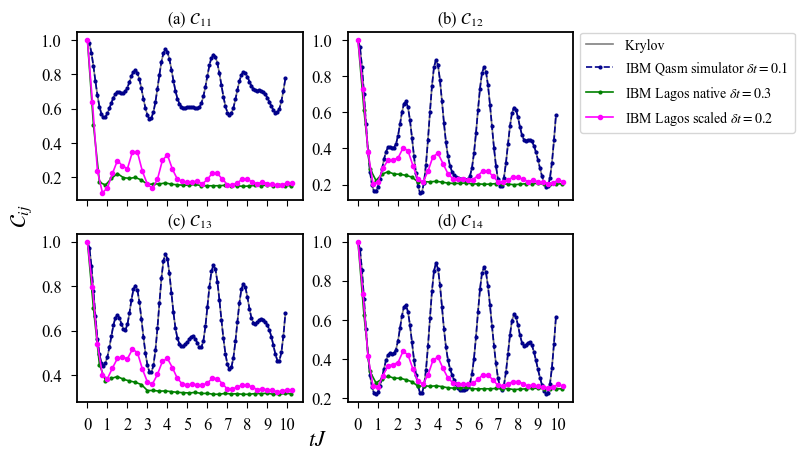

In [393]:
figf, axs = plt.subplots(2,2, sharex='col')
##611 plaquette corr
axs[0,0].plot(tlist6, k611,label='Krylov ',color='grey')
axs[0,0].plot(tlist6, k611,label='IBM Qasm simulator $\delta t = 0.1$ ',color='darkblue',marker='o',markersize=2,linestyle='dashed')
axs[0,0].plot(tlist6n,czzlist611n,label='IBM Lagos native $\delta t = 0.3$ ', marker='o', color='green',markersize=2)
axs[0,0].plot(tlist6c2, czzlist611c2,label='IBM Lagos scaled $\delta t = 0.2$ ', marker='o',color='magenta', markersize=3)

axs[0,0].set_title('(a) $\mathcal{C}_{11}$', fontsize=12)
plt.setp(axs,xticks=[0,1,2,3,4,5,6,7,8,9,10])
plt.sca(axs[0,0])
##612 plaquette corr
#axs[0,1].plot(ktlist4, clists4,label='ED',color='grey')
axs[0,1].plot(tlist6, k612,label='Krylov ',color='grey')
axs[0,1].plot(tlist6, k612,label='IBM Qasm simulator $\delta t = 0.1$ ',color='darkblue',marker='o',markersize=2,linestyle='dashed')
axs[0,1].plot(tlist6n,czzlist612n,label='IBM Lagos native $\delta t = 0.3$ ', marker='o', color='green',markersize=2)
axs[0,1].plot(tlist6c2, czzlist612c2,label='IBM Lagos scaled $\delta t = 0.2$ ', marker='o',color='magenta', markersize=3)

axs[0,1].set_title('(b) $\mathcal{C}_{12}$', fontsize=12)
##613plaquette corr
#axs[1,0].plot(tlist6, klist6,label='Krylov',color='darkslategray')
axs[1,0].plot(tlist6, k613,label='Krylov ',color='grey')
axs[1,0].plot(tlist6, k613,label='IBM Qasm simulator $\delta t = 0.1$ ',color='darkblue',marker='o',markersize=2,linestyle='dashed')
axs[1,0].plot(tlist6n,czzlist613n,label='IBM Lagos native $\delta t = 0.3$ ', marker='o', color='green',markersize=2)
axs[1,0].plot(tlist6c2, czzlist613c2,label='IBM Lagos scaled $\delta t = 0.2$ ', marker='o',color='magenta', markersize=3)

axs[1,0].set_title('(c) $\mathcal{C}_{13}$', fontsize=12)
##614plaquette corr
axs[1,1].plot(tlist6, k614,label='Krylov ',color='grey')
axs[1,1].plot(tlist6, k614,label='IBM Qasm simulator $\delta t = 0.1$ ',color='darkblue',marker='o',markersize=2,linestyle='dashed')
axs[1,1].plot(tlist6n,czzlist614n,label='IBM Lagos native $\delta t = 0.3$ ', marker='o', color='green',markersize=2)
axs[1,1].plot(tlist6c2, czzlist614c2,label='IBM Lagos scaled $\delta t = 0.2$ ', marker='o',color='magenta', markersize=3)

axs[1,1].set_title('(d) $\mathcal{C}_{14}$', fontsize=12)
#axs.set_xlabel=('$tJ$')
#axs[1,1].set_xlabel=('$tJ$')
for ax in axs.flat:
    ax.tick_params(axis='x', length=4)
    ax.tick_params(axis='y', length=4)
    
legends= [axs[0,1].legend()]

for legend in legends:
    legend.set_bbox_to_anchor((1,1.04))
figf.supxlabel('$t J$',fontsize=16)  
figf.supylabel('$\mathcal{C}_{ij}$ ' ,fontsize=16)  
#plt.tight_layout()

Text(0.02, 0.5, '$\\mathcal{C}_{ij}$ ')

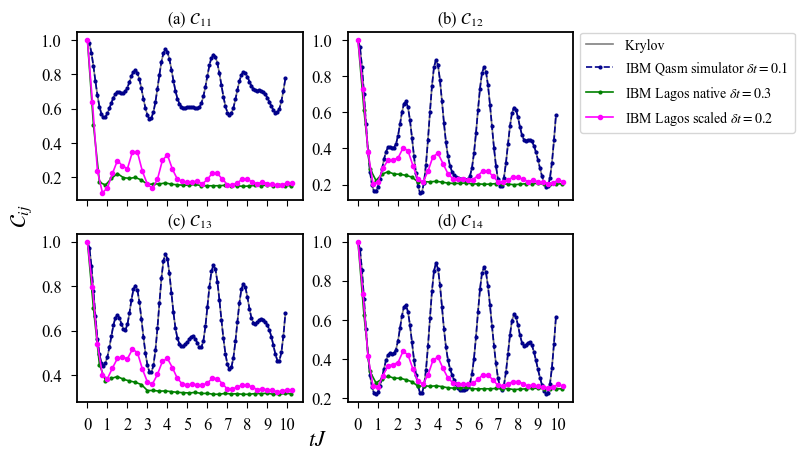

In [393]:
figf, axs = plt.subplots(2,2, sharex='col')
##811 plaquette corr
axs[0,0].plot(tlist6, k611,label='Krylov ',color='grey')
axs[0,0].plot(tlist6, k611,label='IBM Qasm simulator $\delta t = 0.1$ ',color='darkblue',marker='o',markersize=2,linestyle='dashed')
axs[0,0].plot(tlist6n,czzlist611n,label='IBM Lagos native $\delta t = 0.3$ ', marker='o', color='green',markersize=2)
axs[0,0].plot(tlist6c2, czzlist611c2,label='IBM Lagos scaled $\delta t = 0.2$ ', marker='o',color='magenta', markersize=3)

axs[0,0].set_title('(a) $\mathcal{C}_{11}$', fontsize=12)
plt.setp(axs,xticks=[0,1,2,3,4,5,6,7,8,9,10])
plt.sca(axs[0,0])
##612 plaquette corr
#axs[0,1].plot(ktlist4, clists4,label='ED',color='grey')
axs[0,1].plot(tlist6, k612,label='Krylov ',color='grey')
axs[0,1].plot(tlist6, k612,label='IBM Qasm simulator $\delta t = 0.1$ ',color='darkblue',marker='o',markersize=2,linestyle='dashed')
axs[0,1].plot(tlist6n,czzlist612n,label='IBM Lagos native $\delta t = 0.3$ ', marker='o', color='green',markersize=2)
axs[0,1].plot(tlist6c2, czzlist612c2,label='IBM Lagos scaled $\delta t = 0.2$ ', marker='o',color='magenta', markersize=3)

axs[0,1].set_title('(b) $\mathcal{C}_{12}$', fontsize=12)
##613plaquette corr
#axs[1,0].plot(tlist6, klist6,label='Krylov',color='darkslategray')
axs[1,0].plot(tlist6, k613,label='Krylov ',color='grey')
axs[1,0].plot(tlist6, k613,label='IBM Qasm simulator $\delta t = 0.1$ ',color='darkblue',marker='o',markersize=2,linestyle='dashed')
axs[1,0].plot(tlist6n,czzlist613n,label='IBM Lagos native $\delta t = 0.3$ ', marker='o', color='green',markersize=2)
axs[1,0].plot(tlist6c2, czzlist613c2,label='IBM Lagos scaled $\delta t = 0.2$ ', marker='o',color='magenta', markersize=3)

axs[1,0].set_title('(c) $\mathcal{C}_{13}$', fontsize=12)
##614plaquette corr
axs[1,1].plot(tlist6, k614,label='Krylov ',color='grey')
axs[1,1].plot(tlist6, k614,label='IBM Qasm simulator $\delta t = 0.1$ ',color='darkblue',marker='o',markersize=2,linestyle='dashed')
axs[1,1].plot(tlist6n,czzlist614n,label='IBM Lagos native $\delta t = 0.3$ ', marker='o', color='green',markersize=2)
axs[1,1].plot(tlist6c2, czzlist614c2,label='IBM Lagos scaled $\delta t = 0.2$ ', marker='o',color='magenta', markersize=3)

axs[1,1].set_title('(d) $\mathcal{C}_{14}$', fontsize=12)
#axs.set_xlabel=('$tJ$')
#axs[1,1].set_xlabel=('$tJ$')
for ax in axs.flat:
    ax.tick_params(axis='x', length=4)
    ax.tick_params(axis='y', length=4)
    
legends= [axs[0,1].legend()]

for legend in legends:
    legend.set_bbox_to_anchor((1,1.04))
figf.supxlabel('$t J$',fontsize=16)  
figf.supylabel('$\mathcal{C}_{ij}$ ' ,fontsize=16)  
#plt.tight_layout()

In [432]:
czzlist815siml2

[1.0,
 0.71165,
 0.4427,
 0.4177125,
 0.4643625,
 0.5267999999999999,
 0.5720875000000001,
 0.53125625,
 0.520975,
 0.506125,
 0.4692125000000001,
 0.45063749999999997,
 0.45524375,
 0.4966375,
 0.53348125,
 0.50714375,
 0.46336875000000005,
 0.45148125,
 0.4619375,
 0.47053124999999996,
 0.48094999999999993,
 0.47228749999999997,
 0.46687499999999993,
 0.46649999999999997,
 0.46304375000000003,
 0.45899999999999996,
 0.46175000000000005,
 0.466625,
 0.4660875,
 0.46345,
 0.46455,
 0.46029375000000006,
 0.45833124999999997,
 0.4642,
 0.46231875]

Text(0.02, 0.5, '$\\mathcal{C}_{ij}$ ')

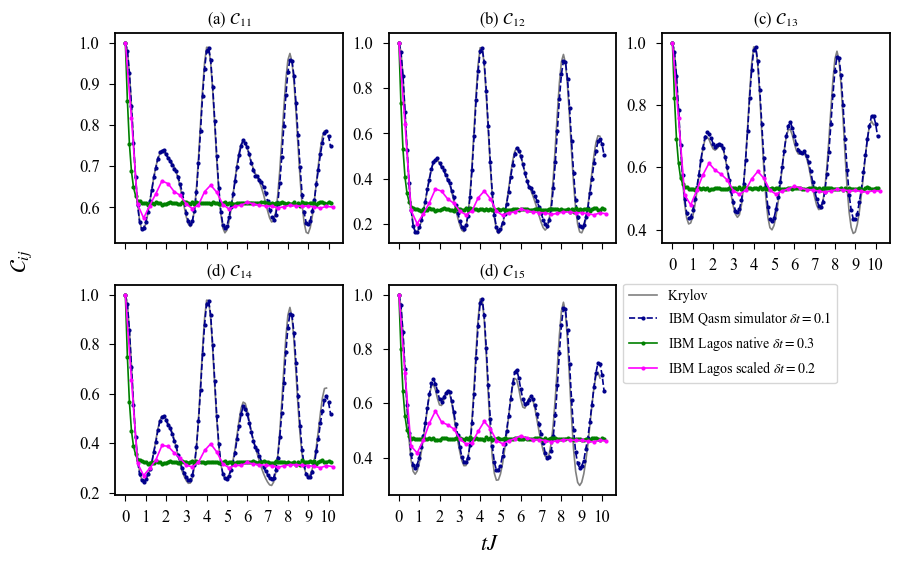

In [421]:
#figf, axs = plt.subplots(2,2, sharex='col')

import matplotlib as mpl

fig = plt.figure(figsize=(10,6))
spec = mpl.gridspec.GridSpec(ncols=3, nrows=2)

ax1 = fig.add_subplot(spec[0,0])
plt.tick_params('x', labelbottom=False)
ax2 = fig.add_subplot(spec[0,1])
plt.tick_params('x', labelbottom=False)
ax3 = fig.add_subplot(spec[0,2])
ax4 = fig.add_subplot(spec[1,0])
ax5 = fig.add_subplot(spec[1,1])
#ax1.get_shared_x_axes().join(ax1, ax4)
#ax2.get_shared_x_axes().join(ax2, ax5)
##811 plaquette corr
#ax1.plot(tlist6, k611,label='Krylov ',color='grey')
#ax1.plot(tlist6, k611,label='IBM Qasm simulator $\delta t = 0.1$ ',color='darkblue',marker='o',markersize=2,linestyle='dashed')
#ax1.plot(tlist6n,czzlist611n,label='IBM Lagos native $\delta t = 0.3$ ', marker='o', color='green',markersize=2)
#ax1.plot(tlist6c2, czzlist611c2,label='IBM Lagos scaled $\delta t = 0.2$ ', marker='o',color='magenta', markersize=3)
ax1.plot(tlist8, k811,label='Krylov ',color='grey')
ax1.plot(tlist8sim, czzlist811sim,label='IBM Qasm simulator $\delta t = 0.1$',color='darkblue',marker='o',markersize=2,linestyle='dashed')
ax1.plot(tlist8n3,czzlist811n3,label='IBM Lagos native $\delta t = 0.3$', marker='o', color='green',markersize=2)
ax1.plot(tlist8siml2, czzlist811siml2,label='IBM Lagos scaled $\delta t = 0.2$', marker='o',color='magenta', markersize=2)
ax1.set_title('(a) $\mathcal{C}_{11}$', fontsize=12)
#plt.setp(ax1,xticks=[0,1,2,3,4,5,6,7,8,9,10])
#plt.sca(ax1)
##612 plaquette corr
#axs[0,1].plot(ktlist4, clists4,label='ED',color='grey')
ax2.plot(tlist8, k812,label='Krylov ',color='grey')
ax2.plot(tlist8sim, czzlist812sim,label='IBM Qasm simulator $\delta t = 0.1$',color='darkblue',marker='o',markersize=2,linestyle='dashed')
ax2.plot(tlist8n3,czzlist812n3,label='IBM Lagos native $\delta t = 0.3$', marker='o', color='green',markersize=2)
ax2.plot(tlist8siml2, czzlist812siml2,label='IBM Lagos scaled $\delta t = 0.2$', marker='o',color='magenta', markersize=2)
ax2.set_title('(a) $\mathcal{C}_{11}$', fontsize=12)
ax2.set_title('(b) $\mathcal{C}_{12}$', fontsize=12)
##613plaquette corr
#axs[1,0].plot(tlist6, klist6,label='Krylov',color='darkslategray')
ax3.plot(tlist8, k813,label='Krylov ',color='grey')
ax3.plot(tlist8sim, czzlist813sim,label='IBM Qasm simulator $\delta t = 0.1$',color='darkblue',marker='o',markersize=2,linestyle='dashed')
ax3.plot(tlist8n3,czzlist813n3,label='IBM Lagos native $\delta t = 0.3$', marker='o', color='green',markersize=2)
ax3.plot(tlist8siml2, czzlist813siml2,label='IBM Lagos scaled $\delta t = 0.2$', marker='o',color='magenta', markersize=2)
ax3.set_title('(a) $\mathcal{C}_{11}$', fontsize=12)
ax3.set_title('(c) $\mathcal{C}_{13}$', fontsize=12)
##614plaquette corr
ax4.plot(tlist8, k814,label='Krylov ',color='grey')
ax4.plot(tlist8sim, czzlist814sim,label='IBM Qasm simulator $\delta t = 0.1$',color='darkblue',marker='o',markersize=2,linestyle='dashed')
ax4.plot(tlist8n3,czzlist814n3,label='IBM Lagos native $\delta t = 0.3$', marker='o', color='green',markersize=2)
ax4.plot(tlist8siml2, czzlist814siml2,label='IBM Lagos scaled $\delta t = 0.2$', marker='o',color='magenta', markersize=2)
ax4.set_title('(a) $\mathcal{C}_{11}$', fontsize=12)

ax4.set_title('(d) $\mathcal{C}_{14}$', fontsize=12)
#axs.set_xlabel=('$tJ$')
#axs[1,1].set_xlabel=('$tJ$')

ax5.plot(tlist8, k815,label='Krylov ',color='grey')
ax5.plot(tlist8sim, czzlist815sim,label='IBM Qasm simulator $\delta t = 0.1$',color='darkblue',marker='o',markersize=2,linestyle='dashed')
ax5.plot(tlist8n3,czzlist815n3,label='IBM Lagos native $\delta t = 0.3$', marker='o', color='green',markersize=2)
ax5.plot(tlist8siml2, czzlist815siml2,label='IBM Lagos scaled $\delta t = 0.2$', marker='o',color='magenta', markersize=2)
ax5.set_title('(a) $\mathcal{C}_{11}$', fontsize=12)
ax5.set_title('(d) $\mathcal{C}_{15}$', fontsize=12)

for ax in [ax1,ax2,ax4, ax3, ax5]:
    ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    ax.tick_params(axis='x', length=4)
    ax.tick_params(axis='y', length=4)

    
legends= [ax5.legend()]

for legend in legends:
    legend.set_bbox_to_anchor((1,1.04))
fig.supxlabel('$t J$',fontsize=16)  
fig.supylabel('$\mathcal{C}_{ij}$ ' ,fontsize=16)  
#plt.tight_layout()

In [402]:
czzlist614c2

[1.0,
 0.7339908999999999,
 0.415385056,
 0.261790064,
 0.2576419485,
 0.315259598,
 0.3655626565,
 0.37169262200000003,
 0.3814733835,
 0.4384942405,
 0.421795468,
 0.34735929,
 0.287558985,
 0.271891653,
 0.3178742885,
 0.393577383,
 0.4096954195,
 0.3515760545,
 0.30279246950000005,
 0.27802726050000004,
 0.27114381249999997,
 0.269877484,
 0.2705111695,
 0.2752263295,
 0.295376659,
 0.319827958,
 0.3177444145,
 0.293210413,
 0.264693794,
 0.2628102805,
 0.2713602925,
 0.28476124750000004,
 0.28382784650000004,
 0.2744104255,
 0.2607108315,
 0.268577681,
 0.2599110545,
 0.256294228,
 0.251610991,
 0.2554605545,
 0.269544184,
 0.261411214]

In [391]:
czzlist815sim

[1.0,
 0.96076875,
 0.8607562500000001,
 0.7263187500000002,
 0.59505625,
 0.4906312500000001,
 0.41515,
 0.3741,
 0.36320625,
 0.37475,
 0.4008749999999999,
 0.43936250000000004,
 0.48153124999999997,
 0.52721875,
 0.5844,
 0.6337375000000001,
 0.67368125,
 0.6894625,
 0.6721250000000001,
 0.6451437499999999,
 0.6141625000000001,
 0.6060312499999999,
 0.6218,
 0.6377312499999999,
 0.6453125,
 0.6406687500000001,
 0.60780625,
 0.568275,
 0.52566875,
 0.48235,
 0.44003125,
 0.40324375,
 0.38458125,
 0.38413125,
 0.40063125000000005,
 0.44555,
 0.5276687499999999,
 0.6350187500000002,
 0.7669499999999999,
 0.8853687500000001,
 0.9703687500000001,
 0.98331875,
 0.9237625,
 0.8047374999999999,
 0.6661374999999999,
 0.5411625,
 0.44229999999999997,
 0.38263125,
 0.3547375,
 0.3551437499999999,
 0.3709875,
 0.40818125000000005,
 0.45001874999999997,
 0.49920624999999996,
 0.55295,
 0.6152500000000001,
 0.6731500000000001,
 0.7134687499999999,
 0.7238625,
 0.6934187500000001,
 0.6517875000000

Text(0.02, 0.5, '$\\mathcal{C}_{ij}$ ')

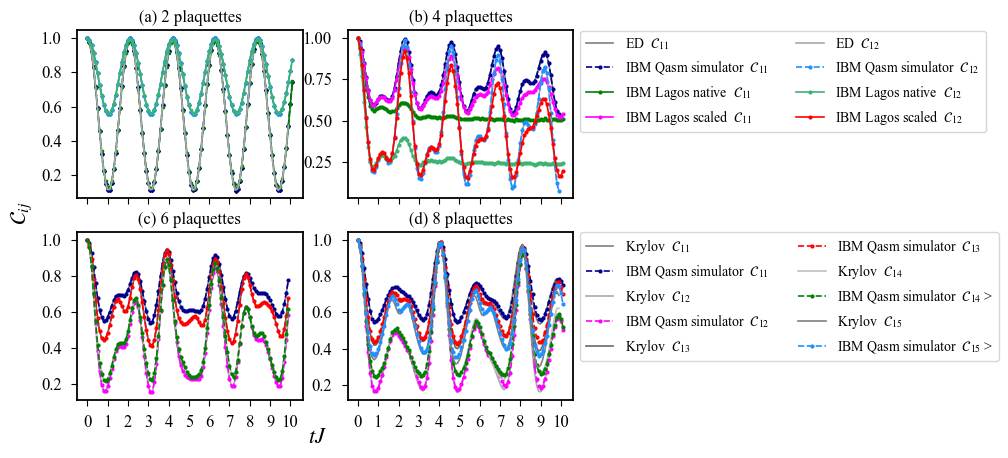

In [378]:
figf, axs = plt.subplots(2,2, sharex='col')
##2 plaquette corr
axs[0,0].plot(tlist2, kcorr211,label='ED  $\mathcal{C}_{11}$  ',color='grey')
axs[0,0].plot(tlist2n1,czzlist211n1,label='IBM Qasm simulator  $\mathcal{C}_{11}$ ',color='darkblue',marker='D',markersize=2,linestyle='dashed')
axs[0,0].plot(tlist2c1, czzlist211c1,label='IBM Lagos  ${\mathcal{C}_{11}$ ', marker='s', color='green',markersize=2)
axs[0,0].plot(tlist2, kcorr212,label='ED  $\mathcal{C}_{12}$  ',color='darkgrey')
axs[0,0].plot(tlist2n1,czzlist212n1,label='IBM Qasm simulator  $\mathcal{C}_{12}$ ',color='dodgerblue',marker='D',markersize=2,linestyle='dashed')
axs[0,0].plot(tlist2c1,czzlist212c1,label='IBM Lagos  $\mathcal{C}_{12}$ ', marker='s', color='mediumseagreen',markersize=2)
axs[0,0].set_title('(a) 2 plaquettes', fontsize=12)
plt.setp(axs,xticks=[0,1,2,3,4,5,6,7,8,9,10])
plt.sca(axs[0,0])
##4 plaquette corr
#axs[0,1].plot(ktlist4, clists4,label='ED',color='grey')
axs[0,1].plot(ktlist4, klist411,label='ED  $\mathcal{C}_{11}$  ',color='grey')
axs[0,1].plot(ktlist4, klist411,label='IBM Qasm simulator  $\mathcal{C}_{11}$',color='darkblue',marker='o',markersize=2,linestyle='dashed')
axs[0,1].plot(tlist4n1, czzlist411n1,label='IBM Lagos native  $\mathcal{C}_{11}$ ', marker='o', color='green',markersize=2)
axs[0,1].plot(tlist4c1, czzlist411c1,label='IBM Lagos scaled  $\mathcal{C}_{11}$ ', marker='o',color='magenta', markersize=2)

axs[0,1].plot(ktlist4, klist412,label='ED  $\mathcal{C}_{12}$  ',color='darkgrey')
axs[0,1].plot(ktlist4, klist412,label='IBM Qasm simulator  $\mathcal{C}_{12}$ ',color='dodgerblue',marker='o',markersize=2,linestyle='dashed')
axs[0,1].plot(tlist4n1, czzlist412n1,label='IBM Lagos native  $\mathcal{C}_{12}$ ', marker='o', color='mediumseagreen',markersize=2)
axs[0,1].plot(tlist4c1, czzlist412c1,label='IBM Lagos scaled  $\mathcal{C}_{12}$ ', marker='o',color='red', markersize=2)
axs[0,1].set_title('(b) 4 plaquettes', fontsize=12)
##6plaquette corr
#axs[1,0].plot(tlist6, klist6,label='Krylov',color='darkslategray')
axs[1,0].plot(tlist6, k611,label='Krylov  $\mathcal{C}_{11}$  ',color='grey')
axs[1,0].plot(tlist6, k611,label='IBM Qasm simulator  $\mathcal{C}_{11}$ ',color='darkblue',marker='o',markersize=2,linestyle='dashed')
axs[1,0].plot(tlist6, k612,label='Krylov  $\mathcal{C}_{12}$  ',color='darkgrey')
axs[1,0].plot(tlist6, k612,label='IBM Qasm simulator  $\mathcal{C}_{12}$ ',color='magenta',marker='o',markersize=2,linestyle='dashed')
axs[1,0].plot(tlist6, k613,label='Krylov  $\hat{\mathcal{C}}_{13}$  ',color='dimgrey')
axs[1,0].plot(tlist6, k613,label='IBM Qasm simulator  $\mathcal{C}_{13}$ ',color='red',marker='o',markersize=2,linestyle='dashed')
axs[1,0].plot(tlist6, k614,label='Krylov  $\mathcal{C}_{14}$  ',color='silver')
axs[1,0].plot(tlist6, k614,label='IBM Qasm simulator  $\mathcal{C}_{14}$ ',color='green',marker='o',markersize=2,linestyle='dashed')
axs[1,0].set_title('(c) 6 plaquettes', fontsize=12)
##8plaquette corr
axs[1,1].plot(tlist8, k811,label='Krylov  $\mathcal{C}_{11}$  ',color='grey')
axs[1,1].plot(tlist8sim, czzlist811sim,label='IBM Qasm simulator  $\mathcal{C}_{11}$ ',color='darkblue',marker='o',markersize=2,linestyle='dashed')
axs[1,1].plot(tlist8, k812,label='Krylov  $\mathcal{C}_{12}$  ',color='darkgrey')
axs[1,1].plot(tlist8sim, czzlist812sim,label='IBM Qasm simulator  $\mathcal{C}_{12}$ ',color='magenta',marker='o',markersize=2,linestyle='dashed')
axs[1,1].plot(tlist8, k813,label='Krylov  $\mathcal{C}_{13}$  ',color='dimgrey')
axs[1,1].plot(tlist8sim, czzlist813sim,label='IBM Qasm simulator  $\mathcal{C}_{13}$ ',color='red',marker='o',markersize=2,linestyle='dashed')
axs[1,1].plot(tlist8, k814,label='Krylov  $\mathcal{C}_{14}$  ',color='silver')
axs[1,1].plot(tlist8sim, czzlist814sim,label='IBM Qasm simulator  $\mathcal{C}_{14}$ >',color='green',marker='o',markersize=2,linestyle='dashed')
axs[1,1].plot(tlist8, k815,label='Krylov  $\mathcal{C}_{15}$  ',color='gray')
axs[1,1].plot(tlist8sim,czzlist815sim,label='IBM Qasm simulator  $\mathcal{C}_{15}$ >',color='dodgerblue',marker='o',markersize=2,linestyle='dashed')

axs[1,1].set_title('(d) 8 plaquettes', fontsize=12)
#axs.set_xlabel=('$tJ$')
#axs[1,1].set_xlabel=('$tJ$')
for ax in axs.flat:
    ax.tick_params(axis='x', length=4)
    ax.tick_params(axis='y', length=4)
    
legends= [axs[0,1].legend(ncol=2),axs[1,1].legend(ncol=2)]

for legend in legends:
    legend.set_bbox_to_anchor((1,1.04))
figf.supxlabel('$t J$',fontsize=16)  
figf.supylabel('$\mathcal{C}_{ij}$ ' ,fontsize=16)  
#plt.tight_layout()

Text(0.02, 0.5, '< $\\hat{\\mathcal{S}}$ >')

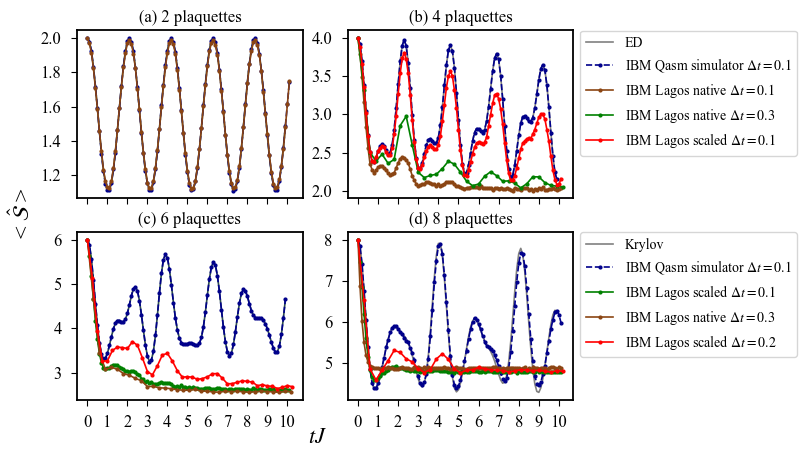

In [340]:
figf, axs = plt.subplots(2,2, sharex='col')
#axs[0,0].plot()
axs[0,0].plot(tlist2, klist2,label='ED',color='darkslategray')
axs[0,0].plot(tlist2n1, czzlists2n1,label='IBM Qasm simulator $\Delta t = 0.1$',color='darkblue',marker='o',markersize=2,linestyle='dashed')
axs[0,0].plot(tlist2c1, czzlists2c1,label='IBM Lagos $\Delta t = 0.1$', marker='o',color='saddlebrown', markersize=2)
axs[0,0].set_title('(a) 2 plaquettes', fontsize=12)
plt.setp(axs,xticks=[0,1,2,3,4,5,6,7,8,9,10])
plt.sca(axs[0,0])

axs[0,1].plot(ktlist4, clists4,label='ED',color='grey')
axs[0,1].plot(ktlist4, clists4,label='IBM Qasm simulator $\Delta t = 0.1$',color='darkblue',marker='o',markersize=2,linestyle='dashed')
axs[0,1].plot(tlist4n1, czzlists4n1,label='IBM Lagos native $\Delta t = 0.1$', marker='o', color='saddlebrown',markersize=2)
axs[0,1].plot(tlist4n3, czzlists4n3,label='IBM Lagos native $\Delta t = 0.3$', marker='o',color='green', markersize=2)
axs[0,1].plot(tlist4c1, czzlists4c1,label='IBM Lagos scaled $\Delta t = 0.1$', marker='o',color='red', markersize=2)
axs[0,1].set_title('(b) 4 plaquettes', fontsize=12)

axs[1,0].plot(tlist6, klist6,label='Krylov',color='darkslategray')
axs[1,0].plot(tlist6, klist6,label='IBM Qasm simulator $\Delta t = 0.1$',color='darkblue',marker='o',markersize=2,linestyle='dashed')
axs[1,0].plot(tlist6c1, czzlists6c1,label='IBM Lagos scaled $\Delta t = 0.1$', marker='o', color='green',markersize=2)
axs[1,0].plot(tlist6n, czzlists6n,label='IBM Lagos native $\Delta t = 0.3$', marker='o',color='saddlebrown', markersize=2)
axs[1,0].plot(tlist6c2, czzlists6c2,label='IBM Lagos scaled $\Delta t = 0.2$', marker='o', color='red',markersize=2)
axs[1,0].set_title('(c) 6 plaquettes', fontsize=12)

axs[1,1].plot(tlist8, k8,label='Krylov',color='grey')
axs[1,1].plot(tlist8sim, czzlists8sim,label='IBM Qasm simulator $\Delta t = 0.1$',color='darkblue',marker='o',markersize=2,linestyle='dashed')
axs[1,1].plot(tlist8siml1, czzlists8siml1,label='IBM Lagos scaled $\Delta t = 0.1$', marker='o', color='green',markersize=2)
axs[1,1].plot(tlist8n3, czzlists8n3,label='IBM Lagos native $\Delta t = 0.3$', marker='o',color='saddlebrown', markersize=2)
axs[1,1].plot(tlist8siml2, czzlists8siml2,label='IBM Lagos scaled $\Delta t = 0.2$', marker='o', color='red',markersize=2)
axs[1,1].set_title('(d) 8 plaquettes', fontsize=12)
#axs.set_xlabel=('$tJ$')
#axs[1,1].set_xlabel=('$tJ$')
for ax in axs.flat:
    ax.tick_params(axis='x', length=4)
    ax.tick_params(axis='y', length=4)
    
legends= [axs[0,1].legend(),axs[1,1].legend()]

for legend in legends:
    legend.set_bbox_to_anchor((1,1.04))
figf.supxlabel('$tJ$',fontsize=16)  
figf.supylabel('$\mathcal{C}_{ij}$' ,fontsize=16)  
#plt.tight_layout()

In [365]:
#tlist8sim
#tlist8n3
#czzlists6c2
#czzlists8siml1
#czzlists8n3
#tlist8siml2
czzlists8siml2

[8.0,
 6.5311,
 4.8616,
 4.594449999999999,
 4.837899999999999,
 5.0661,
 5.313249999999999,
 5.2636,
 5.10885,
 5.035299999999999,
 4.86645,
 4.775949999999999,
 4.849399999999998,
 5.106550000000001,
 5.232900000000001,
 5.0954999999999995,
 4.855149999999999,
 4.7707,
 4.82715,
 4.844600000000001,
 4.9007499999999995,
 4.8702,
 4.841899999999999,
 4.83015,
 4.8241,
 4.79275,
 4.8123499999999995,
 4.842899999999999,
 4.8346,
 4.8218499999999995,
 4.826899999999999,
 4.8088999999999995,
 4.7869,
 4.8225,
 4.805949999999999]

# Fidelity